Hartmann3 synthetic function:

GP EI: (exact GP EI gradients) vs. STP EI: (exact STP EI gradients)

https://www.sfu.ca/~ssurjano/hart3.html

In [ ]:
!pip install pyGPGO

  Created wheel for pyGPGO: filename=pyGPGO-0.4.0.dev1-cp36-none-any.whl size=19867 sha256=2ed707016b5e55e07650fda3482e4f141cd6f1438f5817ffbbd74752a548322a
  Stored in directory: /root/.cache/pip/wheels/d1/27/04/c4fa3bfe194d36e3cd51542132f43415a6813114a5e8301acb
Successfully built pyGPGO


In [ ]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
n_start_AcqFunc = 250 #multi-start iterations to avoid local optima in AcqFunc optimization

In [ ]:
### Inputs:

obj_func = 'Hartmann3'
n_test = n_start_AcqFunc # test points
df = 3 # nu

util_loser = 'dEI_GP'
util_winner = 'dEI_STP'
n_init = 5 # random initialisations

In [ ]:
### Objective function:

if obj_func == 'Hartmann3': # 3-D
            
    # True y bounds:
    y_lb = -3.86278
    operator = -1 # targets global minimum 
    y_global_orig = y_lb * operator # targets global minimum
            
    # Constraints:
    lb = 0
    ub = 1
    
    # Input array dimension(s):
    dim = 3

    # 3-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub]),
             'x3_training': ('cont', [lb, ub])}
    
    max_iter = (10 * dim)*0 + 100  # iterations of Bayesian optimisation
    
    # Test data:
    x1_test = np.linspace(lb, ub, n_test) 
    x2_test = np.linspace(lb, ub, n_test)
    x3_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test, x3_test))
    
    def f_syn_polarity(x1_training, x2_training, x3_training):
       
        value = np.array([x1_training, x2_training, x3_training])
      
        a = np.array([[3.0, 10, 30],
                      [0.1, 10, 35],
                      [3.0, 10, 30],
                      [0.1, 10, 35]])
        
        alpha = np.array([1.0, 1.2, 3.0, 3.2])
      
        p = np.array([[.3689, .1170, .2673],
                      [.4699, .4387, .7470],
                      [.1091, .8732, .5547],
                      [.3810, .5743, .8828]])
  
        s = 0
        for i in [0,1,2,3]:
            sm = a[i,0]*(value[0]-p[i,0])**2
            sm += a[i,1]*(value[1]-p[i,1])**2
            sm += a[i,2]*(value[2]-p[i,2])**2
            s += alpha[i]*np.exp(-sm)
        result = -s
        
        return operator * result

In [ ]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list

In [ ]:
### Set-seeds:

run_num_1 = 111
run_num_2 = 113
run_num_3 = 3333
run_num_4 = 444
run_num_5 = 5555
run_num_6 = 6
run_num_7 = 777
run_num_8 = 887
run_num_9 = 99
run_num_10 = 1000
run_num_11 = 1113
run_num_12 = 1234
run_num_13 = 2345
run_num_14 = 88
run_num_15 = 1556
run_num_16 = 1666
run_num_17 = 717
run_num_18 = 8
run_num_19 = 1998
run_num_20 = 2000

In [ ]:
### Derivatives - Squared-exponential covariance function:

def l2norm_(X, Xstar):
    
    return cdist(X, Xstar)

def kronDelta(X, Xstar):

    return cdist(X, Xstar) < np.finfo(np.float32).eps

class squaredExponentialDeriv(squaredExponential):
    
    def K(self, X, Xstar):
        
        r = (l2norm_(X, Xstar)/self.l)
        K = self.sigmaf * np.exp(-1/2*r **2) + self.sigman * kronDelta(X, Xstar)
        return K
    
    def dK(self, X, Xstar):
        
        r = (l2norm_(X, Xstar)/self.l)
        dK = self.sigmaf/self.l**2 * np.exp(-1/2 * r **2) * l2norm_(X, Xstar)
        return dK
    
        
    def d2K(self, X, Xstar):
        
        r = (l2norm_(X, Xstar)/self.l)
        d2K = self.sigmaf/self.l**2 * np.exp(-1/2 * r **2) * (r**2-1)
        return d2K
    
cov_func = squaredExponential()
d_cov_func = squaredExponentialDeriv()

In [ ]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-08, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'dEI_GP': self.dEI_GP,
            'dEI_STP': self.dEI_STP
        }

        self.f = mode_dict[mode]
    
    def dEI_GP(self, tau, mean, std, ds, dm, dvdv, d2v, d2m):
        z = -1 * (tau - mean - self.eps) / (std + self.eps)
        
        dsdx = ds / 2 * (std + self.eps)
        d2sdx = -dsdx**2 / ((std + self.eps)) - dvdv / (std + self.eps) - d2v / (std + self.eps)
        dmdx = (dm - z * dsdx) / (std + self.eps)
        d2mdx = (d2m - (z * d2sdx + 2 * dmdx * dsdx)) / (std + self.eps)
        
        f = (std + self.eps) * (z * norm.cdf(z) + norm.pdf(z)[0])
        df = (f / (std + self.eps) * dsdx + (std + self.eps) * norm.cdf(z) * dmdx)
        d2f = (f / (std + self.eps) * d2sdx + dsdx * dmdx * norm.cdf(z) \
            + d2mdx * (std + self.eps) * norm.cdf(z) + dsdx * norm.cdf(z) * dmdx \
            + norm.pdf(z)[0] * (std + self.eps) * dmdx)
            
        return f, df, d2f

    def dEI_STP(self, tau, mean, std, ds, dm, dvdv, d2v, d2m, nu=3.0):
    
        gamma = -1 * (tau - mean - self.eps) / (std + self.eps)
        dsdx = ds / 2 * (std + self.eps)
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        f = (std + self.eps) * (gamma * t.cdf(gamma, df=nu) + (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu))
        df = (gamma * t.cdf(gamma, df=nu) + (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma,df=nu)[0]) * dsdx \
             + (std + self.eps) * (t.cdf(gamma,df=nu) * dmdx + gamma * t.pdf(gamma, df=nu) * \
             (1 - (nu + gamma ** 2)/(nu - 1) + 2/(nu - 1) * dmdx))
        return f, df
    
    def _eval(self, tau, mean, std):
    
        return self.f(tau, mean, std, **self.params)
    
    def d_eval(self, tau, mean, std, ds, dm, dvdv, d2v, d2m):
    
        return self.f(tau, mean, std, ds, dm, dvdv, d2v, d2m, **self.params)

    def d_eval_stp(self, tau, mean, std, ds, dm, dvdv, d2v, d2m, nu=3.0):
    
        return self.f(tau, mean, std, ds, dm, dvdv, d2v, d2m, nu=3.0, **self.params)

In [ ]:
### Surrogate derivatives: 

from scipy.linalg import cholesky, solve

class dGaussianProcess(GaussianProcess):
    l = 1
    sigmaf = 1
    sigman = 1e-6

    def AcqGrad(self, Xstar, return_std=False):
        r_X = l2norm_(self.X, self.X)/self.l
        K = self.sigmaf * np.exp(-1/2*r_X **2) + self.sigman * kronDelta(self.X, self.X)
        L = cholesky(K).T
        alpha = solve(L.T, solve(L, self.y))
        Xstar = np.atleast_2d(Xstar)
        Kstar = squaredExponentialDeriv.K(self, self.X, Xstar).T
        dKstar = squaredExponentialDeriv.dK(self, self.X, Xstar).T
        d2Kstar = squaredExponentialDeriv.d2K(self, self.X, Xstar).T
        v = solve(self.L, Kstar.T)
        dv = solve(self.L, dKstar.T)
        d2v = solve(self.L, d2Kstar.T)
        
        ds = -2 * np.dot(dv.T, v)
        dvdv = np.dot(dv.T, dv)
        d2s = -2 * (dvdv + d2v)
        
        dm = np.dot(dKstar, alpha)
        d2m = np.dot(d2Kstar, alpha)
        return ds, dm, dvdv, d2v, d2m

class dtStudentProcess(tStudentProcess):
    l = 1
    sigmaf = 1
    sigman = 1e-6
    
    def AcqGrad(self, Xstar, return_std=False):
        r_X = l2norm_(self.X, self.X)/self.l
        K = self.sigmaf * np.exp(-1/2*r_X **2) + self.sigman * kronDelta(self.X, self.X)
        L = cholesky(self.K11).T
        alpha = solve(L.T, solve(L, self.y))
        Xstar = np.atleast_2d(Xstar)
        Kstar = squaredExponentialDeriv.K(self, self.X, Xstar).T
        dKstar = squaredExponentialDeriv.dK(self, self.X, Xstar).T
        d2Kstar = squaredExponentialDeriv.d2K(self, self.X, Xstar).T
        v = solve(L, Kstar.T)
        dv = solve(L, dKstar.T)
        d2v = solve(L, d2Kstar.T)
        
        ds = -2 * np.dot(dv.T, v)
        dvdv = np.dot(dv.T, dv)
        d2s = -2 * (dvdv + d2v)
        
        dm = np.dot(dKstar, alpha)
        d2m = np.dot(d2Kstar, alpha)
        return ds, dm, dvdv, d2v, d2m

In [ ]:
class dGPGO(GPGO):  
    n_start = n_start_AcqFunc
    eps = 1e-08
        
    def func(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + 1e-6)
        ds, dm, dvdv, d2v, d2m = self.GP.AcqGrad(xnew, return_std=True)
        f  = np.empty((self.n_start,))
        df = np.empty((self.n_start,))
        f  = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m)[0]
        df = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m)[1]
        df_array = np.full((len(xnew),),df)
        return f, df_array
        
    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.func,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

In [ ]:
## dGPGO_stp - BayesOpt derivatives' class: Student's-t

class dGPGO_stp(GPGO):  
    n_start = 100
        
    def func_stp(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + 1e-6)
        ds, dm, dvdv, d2v, d2m = self.GP.AcqGrad(xnew, return_std=True)
        f  = np.empty((self.n_start,))
        df = np.empty((self.n_start,))
        f  = -self.A.d_eval_stp(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m, nu=df)[0]
        df = -self.A.d_eval_stp(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m, nu=df)[1]
        df_array = np.full((len(xnew),),df)
        return f, df_array
        
    def d_optimizeAcq_stp(self, method='L-BFGS-B', n_start=n_start):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.func_stp,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq_stp()
            self.updateGP()
            self.logger._printCurrent(self)

In [ ]:
### d2GPGO - BayesOpt class: 

class d2GPGO(GPGO):  
    n_start = 100
    p = np.full((n_start,1),1)
    
    def func(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + 1e-6)
        ds, dm, dvdv, d2s, d2m = self.GP.AcqGrad(xnew, return_std=True)
        f  = np.empty((self.n_start,))
        df = np.empty((self.n_start,))
        f  = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2s=d2s, d2m=d2m)[0]
        df = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2s=d2s, d2m=d2m)[1]
        df_array = np.full((len(xnew),),df)
        return f, df_array
    
    def hessp_nonzero(self, xnew, p):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + 1e-6)
        ds, dm, dvdv, d2s, d2m = self.GP.AcqGrad(xnew, return_std=True)
        df2 = np.empty((self.n_start,))
        df2 = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2s=d2s, d2m=d2m)[2]
        H2 = np.empty((self.n_start,))
        df2 = np.asarray(df2)
        p = np.asarray(p)
        H2 = np.multiply(df2,p)
        return H2
    
    def d_optimizeAcq(self, method='Newton-CG', n_start=n_start):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.func,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 hessp = self.hessp_nonzero,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.best = x_best[np.argmin(f_best)]     
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

In [ ]:
start_lose = time.time()
start_lose

1613750433.009748

In [ ]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_loser_1 = dGaussianProcess(d_cov_func)

loser_1 = dGPGO(surrogate_loser_1, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_1.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.61217018 0.16906975 0.43605902]. 	  0.37345684462559386 	 2.3951473341797507
init   	 [0.76926247 0.2953253  0.14916296]. 	  0.296162062221701 	 2.3951473341797507
init   	 [0.02247832 0.42022449 0.23868214]. 	  0.2904113287153621 	 2.3951473341797507
init   	 [0.33765619 0.99071246 0.23772645]. 	  0.11013785080555143 	 2.3951473341797507
init   	 [0.08119266 0.66960024 0.62124292]. 	  2.3951473341797507 	 2.3951473341797507
1      	 [0.00485804 0.68286261 0.96018946]. 	  2.420367869177603 	 2.420367869177603
2      	 [0.02880528 0.86879906 0.77145199]. 	  1.7601887902025246 	 2.420367869177603
3      	 [0.07492704 0.49363721 0.85736657]. 	  3.6977257680054527 	 3.6977257680054527
4      	 [0.01690823 0.20303658 0.75373379]. 	  1.1282788852081818 	 3.6977257680054527
5      	 [0.8642259  0.77437694 0.99435991]. 	  1.4015971324220011 	 3.6977257680054527
6      	 [0.45635757 0.34106775 0.99893775]. 	  1.27643784689137

In [ ]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_loser_2 = dGaussianProcess(d_cov_func)

loser_2 = dGPGO(surrogate_loser_2, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_2.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.85198549 0.0739036  0.89493176]. 	  0.3999083566189884 	 2.6229838112516717
init   	 [0.43649355 0.12767773 0.57585787]. 	  0.24461577848211966 	 2.6229838112516717
init   	 [0.84047092 0.43512055 0.69591056]. 	  1.8897715258798413 	 2.6229838112516717
init   	 [0.6846381  0.70064837 0.77969426]. 	  2.6229838112516717 	 2.6229838112516717
init   	 [0.64274937 0.96102617 0.10846489]. 	  0.003309399496320042 	 2.6229838112516717
1      	 [0.84869923 0.93241717 0.93297728]. 	  0.833544515077231 	 2.6229838112516717
2      	 [0.02123335 0.81643687 0.92868758]. 	  1.7643065017177344 	 2.6229838112516717
3      	 [0.53772176 0.60822836 0.78939081]. 	  3.334335833419579 	 3.334335833419579
4      	 [0.41955576 0.63153118 0.95115261]. 	  2.832879013202632 	 3.334335833419579
5      	 [0.04108525 0.77996289 0.25475702]. 	  0.19144274065115907 	 3.334335833419579
6      	 [0.33921093 0.6247264  0.68984899]. 	  2.40183115085940

In [ ]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_loser_3 = dGaussianProcess(d_cov_func)

loser_3 = dGPGO(surrogate_loser_3, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_3.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.75157561 0.10925128 0.48612128]. 	  0.19395982560567754 	 0.5647137279144399
init   	 [0.49983118 0.65711    0.23588471]. 	  0.10633623603471726 	 0.5647137279144399
init   	 [0.61279489 0.1196524  0.7122023 ]. 	  0.5647137279144399 	 0.5647137279144399
init   	 [0.37256054 0.52476827 0.26328708]. 	  0.24645583811739444 	 0.5647137279144399
init   	 [0.62163122 0.44909976 0.21906361]. 	  0.2633149120115605 	 0.5647137279144399
1      	 [0.03146046 0.20692188 0.93064958]. 	  0.9684227062893344 	 0.9684227062893344
2      	 [0.22074887 0.05835947 0.90763313]. 	  0.3319318657983171 	 0.9684227062893344
3      	 [0.80398301 0.59732101 0.97755957]. 	  2.4285425171285553 	 2.4285425171285553
4      	 [0.5136305  0.6806365  0.98913253]. 	  2.0107525433877536 	 2.4285425171285553
5      	 [0.96047188 0.84635755 0.98454941]. 	  1.059610295269561 	 2.4285425171285553
6      	 [0.73881103 0.2852016  0.92866174]. 	  1.5694397586

In [ ]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_loser_4 = dGaussianProcess(d_cov_func)

loser_4 = dGPGO(surrogate_loser_4, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_4.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.83936105 0.82129497 0.64220716]. 	  0.8796727111154451 	 1.9592421489197056
init   	 [0.66722262 0.03913991 0.06567239]. 	  0.21283931850025994 	 1.9592421489197056
init   	 [0.27650064 0.3163605  0.19359241]. 	  0.5590312289203825 	 1.9592421489197056
init   	 [0.19709288 0.84920429 0.84235809]. 	  1.818649590001362 	 1.9592421489197056
init   	 [0.34736473 0.7397423  0.49340914]. 	  1.9592421489197056 	 1.9592421489197056
1      	 [0.22412884 0.99744654 0.22062981]. 	  0.08723427566372202 	 1.9592421489197056
2      	 [0.4057286  0.31242791 0.80779792]. 	  2.2369433002019576 	 2.2369433002019576
3      	 [0.32214328 0.501755   0.69916371]. 	  2.347550186167049 	 2.347550186167049
4      	 [0.39005329 0.54644944 0.69817317]. 	  2.3848842680130833 	 2.3848842680130833
5      	 [0.34533898 0.52489446 0.79943823]. 	  3.5836920400367456 	 3.5836920400367456
6      	 [0.63960296 0.91555258 0.0555591 ]. 	  0.0010744359811

In [ ]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_loser_5 = dGaussianProcess(d_cov_func)

loser_5 = dGPGO(surrogate_loser_5, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_5.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.55735327 0.54176063 0.56042378]. 	  0.9599610140567721 	 0.9810564697651996
init   	 [0.38204809 0.11909418 0.84599912]. 	  0.6913364116577386 	 0.9810564697651996
init   	 [0.73974161 0.93235756 0.85932801]. 	  0.9810564697651996 	 0.9810564697651996
init   	 [0.70810463 0.68096875 0.4086023 ]. 	  0.4017443293787304 	 0.9810564697651996
init   	 [0.77458462 0.9844762  0.96548486]. 	  0.4769494155906823 	 0.9810564697651996
1      	 [0.0655006  0.90661895 0.81035589]. 	  1.403888408720423 	 1.403888408720423
2      	 [0.41215072 0.7779011  0.74763494]. 	  2.1757126346478852 	 2.1757126346478852
3      	 [0.34717117 0.77095612 0.78484957]. 	  2.3966577054831983 	 2.3966577054831983
4      	 [0.30370554 0.5420168  0.98229967]. 	  2.396700843210034 	 2.396700843210034
5      	 [0.03830972 0.41319886 0.87948681]. 	  3.0868801903159286 	 3.0868801903159286
6      	 [0.0550351  0.47493583 0.91186515]. 	  3.247821453024615 

In [ ]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_loser_6 = dGaussianProcess(d_cov_func)

loser_6 = dGPGO(surrogate_loser_6, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_6.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.89286015 0.33197981 0.82122912]. 	  2.3879127825536575 	 2.5106636917702634
init   	 [0.04169663 0.10765668 0.59505206]. 	  0.2321934630074273 	 2.5106636917702634
init   	 [0.52981736 0.41880743 0.33540785]. 	  0.37989557867087576 	 2.5106636917702634
init   	 [0.62251943 0.43814143 0.73588211]. 	  2.5106636917702634 	 2.5106636917702634
init   	 [0.51803641 0.5788586  0.6453551 ]. 	  1.7289203948034264 	 2.5106636917702634
1      	 [0.62339102 0.39276721 0.97743955]. 	  1.8557550530508597 	 2.5106636917702634
2      	 [0.81081535 0.27720993 0.64760969]. 	  0.8549986775341755 	 2.5106636917702634
3      	 [0.97311854 0.60304551 0.92068359]. 	  3.2276797271364055 	 3.2276797271364055
4      	 [0.89264006 0.58864963 0.95652948]. 	  2.776092518207796 	 3.2276797271364055
5      	 [0.96507948 0.60085005 0.82529255]. 	  3.479322232477214 	 3.479322232477214
6      	 [0.95842992 0.48714277 0.81520669]. 	  3.42742225231012

In [ ]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_loser_7 = dGaussianProcess(d_cov_func)

loser_7 = dGPGO(surrogate_loser_7, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_7.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.15266373 0.30235661 0.06203641]. 	  0.1742288077468587 	 1.6237282255098657
init   	 [0.45986034 0.83525338 0.92699705]. 	  1.6237282255098657 	 1.6237282255098657
init   	 [0.72698898 0.76849622 0.26920507]. 	  0.08405715787489784 	 1.6237282255098657
init   	 [0.64402929 0.09337326 0.07968589]. 	  0.2756481743251193 	 1.6237282255098657
init   	 [0.58961375 0.34334054 0.98887615]. 	  1.4020548914621052 	 1.6237282255098657
1      	 [0.32658881 0.90655956 0.99955954]. 	  0.6793796294845356 	 1.6237282255098657
2      	 [0.97122775 0.93199907 0.87171651]. 	  0.9308657054768225 	 1.6237282255098657
3      	 [0.57909004 0.58214012 0.79783263]. 	  3.478089696581643 	 3.478089696581643
4      	 [0.49507021 0.39113672 0.52467305]. 	  0.478096743295257 	 3.478089696581643
5      	 [0.96188519 0.49079304 0.94964007]. 	  2.739322132683216 	 3.478089696581643
6      	 [0.90946938 0.60810834 0.78435192]. 	  3.0774531590511494 

In [ ]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_loser_8 = dGaussianProcess(d_cov_func)

loser_8 = dGPGO(surrogate_loser_8, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_8.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.10949987 0.04221501 0.59969258]. 	  0.15732379460832624 	 0.8830091449513892
init   	 [0.29987071 0.79661178 0.36619613]. 	  0.8830091449513892 	 0.8830091449513892
init   	 [0.88060834 0.29784163 0.32910326]. 	  0.2992873424905509 	 0.8830091449513892
init   	 [0.56871692 0.74392742 0.05385289]. 	  0.0051668955191694075 	 0.8830091449513892
init   	 [0.60207437 0.42931858 0.20547361]. 	  0.2908249205255991 	 0.8830091449513892
1      	 [0.19816249 0.92572195 0.98825083]. 	  0.653164991364588 	 0.8830091449513892
2      	 [0.03762084 0.88738442 0.32955494]. 	  0.6464733859302134 	 0.8830091449513892
3      	 [0.59298739 0.68240117 0.69116296]. 	  1.9678379589841422 	 1.9678379589841422
4      	 [0.99676486 0.73834616 0.85474135]. 	  2.622597831543382 	 2.622597831543382
5      	 [0.93909608 0.58044829 0.98333517]. 	  2.313423464876202 	 2.622597831543382
6      	 [0.99228465 0.88181182 0.94936817]. 	  1.0671609422162

In [ ]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_loser_9 = dGaussianProcess(d_cov_func)

loser_9 = dGPGO(surrogate_loser_9, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_9.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.67227856 0.4880784  0.82549517]. 	  3.595021899183128 	 3.595021899183128
init   	 [0.03144639 0.80804996 0.56561742]. 	  2.9633561694281085 	 3.595021899183128
init   	 [0.2976225  0.04669572 0.9906274 ]. 	  0.16382388103073592 	 3.595021899183128
init   	 [0.00682573 0.76979303 0.7467671 ]. 	  2.382987807172393 	 3.595021899183128
init   	 [0.37743894 0.49414745 0.92894839]. 	  3.1588932929069533 	 3.595021899183128
1      	 [0.52764856 0.9939604  0.48209367]. 	  1.3155723134440893 	 3.595021899183128
2      	 [0.00227164 0.46291529 0.00323185]. 	  0.024986269174128935 	 3.595021899183128
3      	 [0.74154712 0.47672217 0.94815008]. 	  2.7597734226906323 	 3.595021899183128
4      	 [0.48243272 0.44732888 0.61651095]. 	  1.1836247573325942 	 3.595021899183128
5      	 [0.70693919 0.69691564 0.77816739]. 	  2.61741563807694 	 3.595021899183128
6      	 [0.07934713 0.95674979 0.04699611]. 	  0.0013796279485809439 	 3

In [ ]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_loser_10 = dGaussianProcess(d_cov_func)

loser_10 = dGPGO(surrogate_loser_10, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_10.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.65358959 0.11500694 0.95028286]. 	  0.42730315147591735 	 1.1029187088185965
init   	 [0.4821914  0.87247454 0.21233268]. 	  0.06161964400032635 	 1.1029187088185965
init   	 [0.04070962 0.39719446 0.2331322 ]. 	  0.33269334660262956 	 1.1029187088185965
init   	 [0.84174072 0.20708234 0.74246953]. 	  1.1029187088185965 	 1.1029187088185965
init   	 [0.39215413 0.18225652 0.74353941]. 	  0.9779763535009853 	 1.1029187088185965
1      	 [0.86210958 0.05779215 0.34314786]. 	  0.3927532126432764 	 1.1029187088185965
2      	 [0.92518579 0.78050514 0.87881645]. 	  2.2443644989048672 	 2.2443644989048672
3      	 [0.98338289 0.93392737 0.81033881]. 	  0.8330483590093913 	 2.2443644989048672
4      	 [0.24984974 0.81883701 0.99874938]. 	  1.135383544316759 	 2.2443644989048672
5      	 [0.84241011 0.46743734 0.97175067]. 	  2.3195199773796715 	 2.3195199773796715
6      	 [0.77577588 0.62900507 0.95536967]. 	  2.7275368566

In [ ]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_loser_11 = dGaussianProcess(d_cov_func)

loser_11 = dGPGO(surrogate_loser_11, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_11.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.98103566 0.82124785 0.64589361]. 	  0.6570240879762975 	 0.687459437576373
init   	 [0.42368801 0.20231098 0.49190677]. 	  0.29901296656621285 	 0.687459437576373
init   	 [0.13855833 0.45252104 0.11373463]. 	  0.1378633538075966 	 0.687459437576373
init   	 [0.00292449 0.52342617 0.18997116]. 	  0.12299763462541902 	 0.687459437576373
init   	 [0.14171979 0.33586637 0.58369219]. 	  0.687459437576373 	 0.687459437576373
1      	 [0.23267662 0.55632866 0.98247629]. 	  2.401417505244251 	 2.401417505244251
2      	 [0.1018956  0.95528749 0.95450529]. 	  0.6625688909370097 	 2.401417505244251
3      	 [0.49069589 0.32394686 0.99166679]. 	  1.2576491073928158 	 2.401417505244251
4      	 [0.99622896 0.50984357 0.00987988]. 	  0.008998496185923171 	 2.401417505244251
5      	 [0.17147829 0.44852386 0.99855404]. 	  1.8327027793895603 	 2.401417505244251
6      	 [0.52755702 0.61099275 0.96085651]. 	  2.731594261003499 	 2.

In [ ]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_loser_12 = dGaussianProcess(d_cov_func)

loser_12 = dGPGO(surrogate_loser_12, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_12.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.19151945 0.62210877 0.43772774]. 	  1.1006281843679786 	 1.6482992955272024
init   	 [0.78535858 0.77997581 0.27259261]. 	  0.07153771680480671 	 1.6482992955272024
init   	 [0.27646426 0.80187218 0.95813935]. 	  1.6482992955272024 	 1.6482992955272024
init   	 [0.87593263 0.35781727 0.50099513]. 	  0.2282556248207173 	 1.6482992955272024
init   	 [0.68346294 0.71270203 0.37025075]. 	  0.33032494760932407 	 1.6482992955272024
1      	 [0.01398415 0.60897714 0.98856638]. 	  2.228026380269567 	 2.228026380269567
2      	 [0.03494356 0.11089546 0.89536938]. 	  0.5535687532914756 	 2.228026380269567
3      	 [0.00761147 0.89633798 0.99755295]. 	  0.7296905183544732 	 2.228026380269567
4      	 [0.42621529 0.52201143 0.94674436]. 	  2.981393016278439 	 2.981393016278439
5      	 [0.62997572 0.44202894 0.99618939]. 	  1.8391155649095643 	 2.981393016278439
6      	 [0.32429872 0.48995801 0.97777927]. 	  2.3563074830909687 

In [ ]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_loser_13 = dGaussianProcess(d_cov_func)

loser_13 = dGPGO(surrogate_loser_13, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_13.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.66064431 0.41360065 0.66810256]. 	  1.5457680899590245 	 2.6697919207500047
init   	 [0.22994342 0.80767834 0.63681846]. 	  2.6697919207500047 	 2.6697919207500047
init   	 [0.17219385 0.26038587 0.91531999]. 	  1.4685599870430508 	 2.6697919207500047
init   	 [0.46281551 0.12019095 0.88088551]. 	  0.639297028201682 	 2.6697919207500047
init   	 [0.22621895 0.81144033 0.44587892]. 	  1.960293029067079 	 2.6697919207500047
1      	 [0.54200533 0.91610447 0.94072107]. 	  0.9345749070922738 	 2.6697919207500047
2      	 [0.02210984 0.92408402 0.84182838]. 	  1.1986876793966825 	 2.6697919207500047
3      	 [0.2551603  0.64940006 0.63764251]. 	  2.2608836438455646 	 2.6697919207500047
4      	 [0.66842278 0.8625381  0.47685558]. 	  0.9979464612823808 	 2.6697919207500047
5      	 [0.28295395 0.99213626 0.55559161]. 	  2.407164166226089 	 2.6697919207500047
6      	 [0.88103078 0.40276708 0.88651999]. 	  2.915655348161583

In [ ]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_loser_14 = dGaussianProcess(d_cov_func)

loser_14 = dGPGO(surrogate_loser_14, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_14.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.64755105 0.50714969 0.52834138]. 	  0.5963212059988954 	 2.610000357863649
init   	 [0.8962852  0.69999119 0.7142971 ]. 	  1.7197848290620104 	 2.610000357863649
init   	 [0.71733838 0.22281946 0.17515452]. 	  0.48166052848103497 	 2.610000357863649
init   	 [0.45684149 0.92873843 0.00988589]. 	  0.0004588015757462679 	 2.610000357863649
init   	 [0.08992219 0.85020027 0.48562106]. 	  2.610000357863649 	 2.610000357863649
1      	 [0.07426471 0.99752623 0.88021278]. 	  0.6630933245090485 	 2.610000357863649
2      	 [0.00180211 0.46271645 0.11240184]. 	  0.09986378420438345 	 2.610000357863649
3      	 [0.04945322 0.96746298 0.34336512]. 	  0.71192198606886 	 2.610000357863649
4      	 [0.95164465 0.9953009  0.00385032]. 	  5.429819046242939e-05 	 2.610000357863649
5      	 [0.9979422  0.99655151 0.98186954]. 	  0.37591226277898976 	 2.610000357863649
6      	 [0.95837713 0.62910703 0.12515201]. 	  0.0147158625216219

In [ ]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_loser_15 = dGaussianProcess(d_cov_func)

loser_15 = dGPGO(surrogate_loser_15, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_15.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.57788186 0.25550133 0.25252687]. 	  0.7217338409961529 	 1.540625560354162
init   	 [0.70990435 0.44755236 0.22694296]. 	  0.23199690080875204 	 1.540625560354162
init   	 [0.40170957 0.88225774 0.43721347]. 	  1.540625560354162 	 1.540625560354162
init   	 [0.87842518 0.78052775 0.53421429]. 	  0.5653855252190516 	 1.540625560354162
init   	 [0.01173301 0.26575648 0.3311941 ]. 	  0.5019682819961726 	 1.540625560354162
1      	 [0.45870705 0.97826428 0.97993811]. 	  0.46749494069699443 	 1.540625560354162
2      	 [0.66075471 0.         0.61312367]. 	  0.12159642826997123 	 1.540625560354162
3      	 [0.46645428 0.99752683 0.41295545]. 	  0.9605705723922775 	 1.540625560354162
4      	 [0.34390964 0.64896828 0.49739212]. 	  1.5093166326574845 	 1.540625560354162
5      	 [0.05653148 0.81602006 0.23121467]. 	  0.13016751165670606 	 1.540625560354162
6      	 [0.29839982 0.94779509 0.61815286]. 	  2.376883919188496 	 2

In [ ]:

### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_loser_16 = dGaussianProcess(d_cov_func)

loser_16 = dGPGO(surrogate_loser_16, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_16.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.86394833 0.316366   0.67215078]. 	  1.1947633822631252 	 3.8084053754826726
init   	 [0.50791167 0.78166043 0.28368168]. 	  0.20052765717741963 	 3.8084053754826726
init   	 [0.23370878 0.56379969 0.87502436]. 	  3.8084053754826726 	 3.8084053754826726
init   	 [0.71894292 0.18213174 0.24380041]. 	  0.6532826728302027 	 3.8084053754826726
init   	 [0.08605673 0.53424539 0.83969965]. 	  3.8072565344663847 	 3.8084053754826726
1      	 [0.12378065 0.3168353  0.9881258 ]. 	  1.2451880833929392 	 3.8084053754826726
2      	 [0.27777137 0.94321124 0.96390235]. 	  0.6864412627036871 	 3.8084053754826726
3      	 [0.04467565 0.50685234 0.49507307]. 	  0.8672168540674181 	 3.8084053754826726
4      	 [0.00628562 0.62733695 0.98683809]. 	  2.216178855902818 	 3.8084053754826726
5      	 [0.24302952 0.56104258 0.71810923]. 	  2.714059998275844 	 3.8084053754826726
6      	 [0.96778771 0.7812586  0.04735995]. 	  0.0011023859383

In [ ]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_loser_17 = dGaussianProcess(d_cov_func)

loser_17 = dGPGO(surrogate_loser_17, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_17.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.65182403 0.73051962 0.19336736]. 	  0.03562358530655929 	 3.1179188940604616
init   	 [0.51967724 0.67638327 0.80444487]. 	  3.1179188940604616 	 3.1179188940604616
init   	 [0.53351286 0.90803418 0.44348113]. 	  1.1984486017622078 	 3.1179188940604616
init   	 [0.25597221 0.27866502 0.04332186]. 	  0.1645724004847893 	 3.1179188940604616
init   	 [0.46897499 0.9416138  0.60040624]. 	  1.9192522196289552 	 3.1179188940604616
1      	 [0.24286651 0.38597556 0.96454773]. 	  1.996297956656514 	 3.1179188940604616
2      	 [0.78722    0.79439557 0.98615055]. 	  1.382220738619041 	 3.1179188940604616
3      	 [0.48019116 0.49032971 0.69126343]. 	  2.1360120328634014 	 3.1179188940604616
4      	 [0.4607031  0.72735048 0.97289599]. 	  2.000642401584277 	 3.1179188940604616
5      	 [0.00166169 0.44190378 0.82055392]. 	  3.336924169425464 	 3.336924169425464
6      	 [0.84992296 0.83200048 0.62767412]. 	  0.8027149864585417

In [ ]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_loser_18 = dGaussianProcess(d_cov_func)

loser_18 = dGPGO(surrogate_loser_18, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_18.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.8734294  0.96854066 0.86919454]. 	  0.722531189286755 	 1.1210522139432408
init   	 [0.53085569 0.23272833 0.0113988 ]. 	  0.1133646794700679 	 1.1210522139432408
init   	 [0.43046882 0.40235136 0.52267467]. 	  0.5232646985053151 	 1.1210522139432408
init   	 [0.4783918  0.55535647 0.54338602]. 	  1.0390748854353227 	 1.1210522139432408
init   	 [0.76089558 0.71237457 0.6196821 ]. 	  1.1210522139432408 	 1.1210522139432408
1      	 [0.28982083 0.95201409 0.18404427]. 	  0.04220734680078784 	 1.1210522139432408
2      	 [0.12883542 0.98258307 0.90180597]. 	  0.6910738837771888 	 1.1210522139432408
3      	 [0.49148239 0.8099037  0.6976846 ]. 	  1.8373634823765186 	 1.8373634823765186
4      	 [0.46136123 0.85569499 0.88610921]. 	  1.63167944843026 	 1.8373634823765186
5      	 [0.49454713 0.93328953 0.56170327]. 	  1.9054625615284428 	 1.9054625615284428
6      	 [0.41435422 0.93277915 0.58517174]. 	  2.21082650358163

In [ ]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_loser_19 = dGaussianProcess(d_cov_func)

loser_19 = dGPGO(surrogate_loser_19, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_19.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.55944558 0.76149199 0.24453155]. 	  0.09433080659504385 	 2.524990008735946
init   	 [0.77168947 0.35447208 0.7966974 ]. 	  2.524990008735946 	 2.524990008735946
init   	 [0.34600002 0.44387444 0.30330359]. 	  0.3914194506273641 	 2.524990008735946
init   	 [0.44211392 0.57320936 0.06566402]. 	  0.036928944981920925 	 2.524990008735946
init   	 [0.02408889 0.82062263 0.36513765]. 	  0.9772047942100802 	 2.524990008735946
1      	 [0.96499061 0.19185662 0.98563058]. 	  0.5815385407774518 	 2.524990008735946
2      	 [0.35021227 0.89949578 0.95419986]. 	  0.9824452595236306 	 2.524990008735946
3      	 [0.8364035  0.47078086 0.70932116]. 	  2.156884519592091 	 2.524990008735946
4      	 [0.46047313 0.25352007 0.98033154]. 	  0.9460814398415793 	 2.524990008735946
5      	 [0.87336482 0.09118839 0.45818428]. 	  0.17563272101768643 	 2.524990008735946
6      	 [0.70411181 0.42279097 0.83675882]. 	  3.2477068869485466 	 3

In [ ]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_loser_20 = dGaussianProcess(d_cov_func)

loser_20 = dGPGO(surrogate_loser_20, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_20.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.57051729 0.56452876 0.48844183]. 	  0.675391399411646 	 0.675391399411646
init   	 [0.33647775 0.37586818 0.53203587]. 	  0.5331349538596052 	 0.675391399411646
init   	 [0.06810629 0.58452906 0.23789776]. 	  0.14747335095307315 	 0.675391399411646
init   	 [0.16075658 0.15211915 0.12706922]. 	  0.48089725804912437 	 0.675391399411646
init   	 [0.32744117 0.69415387 0.35896647]. 	  0.6289408047543804 	 0.675391399411646
1      	 [0.837611   0.97862966 0.10314233]. 	  0.0013418779384681767 	 0.675391399411646
2      	 [0.4192146  0.99013113 0.80759551]. 	  0.8040311121195758 	 0.8040311121195758
3      	 [0.58490171 0.         0.        ]. 	  0.08889155882157919 	 0.8040311121195758
4      	 [0.56803068 0.99098437 0.50767036]. 	  1.310904866486966 	 1.310904866486966
5      	 [0.84822682 0.9788853  0.85466061]. 	  0.6702188994918671 	 1.310904866486966
6      	 [0.84509259 0.         0.89862994]. 	  0.1919438454356508

In [ ]:
end_lose = time.time()
end_lose

time_lose = end_lose - start_lose
time_lose

start_win = time.time()
start_win

1613754075.8267817

In [ ]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_winner_1 = dtStudentProcess(d_cov_func, nu = df)

winner_1 = dGPGO_stp(surrogate_winner_1, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_1.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.61217018 0.16906975 0.43605902]. 	  0.37345684462559386 	 2.3951473341797507
init   	 [0.76926247 0.2953253  0.14916296]. 	  0.296162062221701 	 2.3951473341797507
init   	 [0.02247832 0.42022449 0.23868214]. 	  0.2904113287153621 	 2.3951473341797507
init   	 [0.33765619 0.99071246 0.23772645]. 	  0.11013785080555143 	 2.3951473341797507
init   	 [0.08119266 0.66960024 0.62124292]. 	  2.3951473341797507 	 2.3951473341797507
1      	 [0.21486674 0.88986562 0.98663162]. 	  0.8399484684199459 	 2.3951473341797507
2      	 [0.00360582 0.53556448 0.85125689]. 	  3.7984880293569576 	 3.7984880293569576
3      	 [0.00746842 0.39300358 0.94016277]. 	  2.339565033428072 	 3.7984880293569576
4      	 [0.02045433 0.98005749 0.77689925]. 	  1.0663122182934404 	 3.7984880293569576
5      	 [1.         1.         0.63197724]. 	  0.2844841012927049 	 3.7984880293569576
6      	 [1.         0.40299951 0.98550495]. 	  1.745005473931

In [ ]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_winner_2 = dtStudentProcess(d_cov_func, nu = df)

winner_2 = dGPGO_stp(surrogate_winner_2, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_2.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.85198549 0.0739036  0.89493176]. 	  0.3999083566189884 	 2.6229838112516717
init   	 [0.43649355 0.12767773 0.57585787]. 	  0.24461577848211966 	 2.6229838112516717
init   	 [0.84047092 0.43512055 0.69591056]. 	  1.8897715258798413 	 2.6229838112516717
init   	 [0.6846381  0.70064837 0.77969426]. 	  2.6229838112516717 	 2.6229838112516717
init   	 [0.64274937 0.96102617 0.10846489]. 	  0.003309399496320042 	 2.6229838112516717
1      	 [1. 1. 1.]. 	  0.31688362070415665 	 2.6229838112516717
2      	 [0.14306915 0.79984146 0.95066451]. 	  1.7295279521051767 	 2.6229838112516717
3      	 [0.64660874 0.52052301 1.        ]. 	  2.0287149797440898 	 2.6229838112516717
4      	 [0.0344432  0.84473497 0.3806316 ]. 	  1.183875430780772 	 2.6229838112516717
5      	 [0.47200517 0.80167582 0.68177245]. 	  1.923237487059919 	 2.6229838112516717
6      	 [0.04386287 0.07126412 0.99295526]. 	  0.2015240279352184 	 2.6229838112516

In [ ]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_winner_3 = dtStudentProcess(d_cov_func, nu = df)

winner_3 = dGPGO_stp(surrogate_winner_3, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_3.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.75157561 0.10925128 0.48612128]. 	  0.19395982560567754 	 0.5647137279144399
init   	 [0.49983118 0.65711    0.23588471]. 	  0.10633623603471726 	 0.5647137279144399
init   	 [0.61279489 0.1196524  0.7122023 ]. 	  0.5647137279144399 	 0.5647137279144399
init   	 [0.37256054 0.52476827 0.26328708]. 	  0.24645583811739444 	 0.5647137279144399
init   	 [0.62163122 0.44909976 0.21906361]. 	  0.2633149120115605 	 0.5647137279144399
1      	 [0.11772068 0.14251025 0.82235537]. 	  0.839257643081402 	 0.839257643081402
2      	 [0.39729708 0.30636754 0.99169899]. 	  1.1547534875345482 	 1.1547534875345482
3      	 [1. 1. 1.]. 	  0.31688362070415665 	 1.1547534875345482
4      	 [1.         0.37083139 1.        ]. 	  1.377347110906582 	 1.377347110906582
5      	 [0.05018267 0.95018324 0.96278164]. 	  0.6517797142407744 	 1.377347110906582
6      	 [0.62382355 0.12678978 1.        ]. 	  0.3136692003045174 	 1.377347110906582


In [ ]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_winner_4 = dtStudentProcess(d_cov_func, nu = df)

winner_4 = dGPGO_stp(surrogate_winner_4, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_4.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.83936105 0.82129497 0.64220716]. 	  0.8796727111154451 	 1.9592421489197056
init   	 [0.66722262 0.03913991 0.06567239]. 	  0.21283931850025994 	 1.9592421489197056
init   	 [0.27650064 0.3163605  0.19359241]. 	  0.5590312289203825 	 1.9592421489197056
init   	 [0.19709288 0.84920429 0.84235809]. 	  1.818649590001362 	 1.9592421489197056
init   	 [0.34736473 0.7397423  0.49340914]. 	  1.9592421489197056 	 1.9592421489197056
1      	 [0.21048118 0.93760955 0.49255286]. 	  2.5000045668352646 	 2.5000045668352646
2      	 [0.25699436 1.         0.31999912]. 	  0.458716587368803 	 2.5000045668352646
3      	 [0.95116641 0.09652518 0.85252192]. 	  0.5523366117056545 	 2.5000045668352646
4      	 [0.08941848 0.68882157 0.52760471]. 	  2.241403189529865 	 2.5000045668352646
5      	 [0.0276134  0.97437238 0.74375161]. 	  1.2994309356976668 	 2.5000045668352646
6      	 [0.00000000e+00 2.28814054e-04 3.10598464e-01]. 	  0.54

In [ ]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_winner_5 = dtStudentProcess(d_cov_func, nu = df)

winner_5 = dGPGO_stp(surrogate_winner_5, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_5.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.55735327 0.54176063 0.56042378]. 	  0.9599610140567721 	 0.9810564697651996
init   	 [0.38204809 0.11909418 0.84599912]. 	  0.6913364116577386 	 0.9810564697651996
init   	 [0.73974161 0.93235756 0.85932801]. 	  0.9810564697651996 	 0.9810564697651996
init   	 [0.70810463 0.68096875 0.4086023 ]. 	  0.4017443293787304 	 0.9810564697651996
init   	 [0.77458462 0.9844762  0.96548486]. 	  0.4769494155906823 	 0.9810564697651996
1      	 [0.0655006  0.90661895 0.81035589]. 	  1.403888408720423 	 1.403888408720423
2      	 [0.92779976 0.07015106 0.89872933]. 	  0.3773619776486492 	 1.403888408720423
3      	 [0.27569625 0.57072658 0.98063269]. 	  2.4396972199311326 	 2.4396972199311326
4      	 [0.09076092 0.6934661  0.10195884]. 	  0.017216492127189086 	 2.4396972199311326
5      	 [0.49156068 0.54645261 0.99634753]. 	  2.1427947791105715 	 2.4396972199311326
6      	 [0. 0. 0.]. 	  0.06797411659013229 	 2.439697219931132

In [ ]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_winner_6 = dtStudentProcess(d_cov_func, nu = df)

winner_6 = dGPGO_stp(surrogate_winner_6, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_6.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.89286015 0.33197981 0.82122912]. 	  2.3879127825536575 	 2.5106636917702634
init   	 [0.04169663 0.10765668 0.59505206]. 	  0.2321934630074273 	 2.5106636917702634
init   	 [0.52981736 0.41880743 0.33540785]. 	  0.37989557867087576 	 2.5106636917702634
init   	 [0.62251943 0.43814143 0.73588211]. 	  2.5106636917702634 	 2.5106636917702634
init   	 [0.51803641 0.5788586  0.6453551 ]. 	  1.7289203948034264 	 2.5106636917702634
1      	 [0.41616836 0.50270913 1.        ]. 	  2.003569905312153 	 2.5106636917702634
2      	 [1. 1. 1.]. 	  0.31688362070426773 	 2.5106636917702634
3      	 [7.01278723e-01 2.96538793e-05 7.52090014e-01]. 	  0.2391592414044164 	 2.5106636917702634
4      	 [0.9915895  0.97629604 0.1207269 ]. 	  0.0010193129366017407 	 2.5106636917702634
5      	 [0.77911799 0.49064389 0.86773373]. 	  3.6177139156214015 	 3.6177139156214015
6      	 [0. 0. 0.]. 	  0.06797411659013229 	 3.6177139156214015
7    

In [ ]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_winner_7 = dtStudentProcess(d_cov_func, nu = df)

winner_7 = dGPGO_stp(surrogate_winner_7, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_7.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.15266373 0.30235661 0.06203641]. 	  0.1742288077468587 	 1.6237282255098657
init   	 [0.45986034 0.83525338 0.92699705]. 	  1.6237282255098657 	 1.6237282255098657
init   	 [0.72698898 0.76849622 0.26920507]. 	  0.08405715787489784 	 1.6237282255098657
init   	 [0.64402929 0.09337326 0.07968589]. 	  0.2756481743251193 	 1.6237282255098657
init   	 [0.58961375 0.34334054 0.98887615]. 	  1.4020548914621052 	 1.6237282255098657
1      	 [0.32658881 0.90655956 0.99955954]. 	  0.6793796294845356 	 1.6237282255098657
2      	 [1. 1. 1.]. 	  0.31688362070415665 	 1.6237282255098657
3      	 [0.53962879 0.5080036  0.69379946]. 	  2.1648797626688916 	 2.1648797626688916
4      	 [0.26931907 0.0131842  0.45075835]. 	  0.32800509361940383 	 2.1648797626688916
5      	 [0.96465563 0.05659614 0.70853251]. 	  0.3326255074889067 	 2.1648797626688916
6      	 [0.6603142  0.60444276 0.80980003]. 	  3.4854949158354174 	 3.485494915835

In [ ]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_winner_8 = dtStudentProcess(d_cov_func, nu = df)

winner_8 = dGPGO_stp(surrogate_winner_8, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_8.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.10949987 0.04221501 0.59969258]. 	  0.15732379460832624 	 0.8830091449513892
init   	 [0.29987071 0.79661178 0.36619613]. 	  0.8830091449513892 	 0.8830091449513892
init   	 [0.88060834 0.29784163 0.32910326]. 	  0.2992873424905509 	 0.8830091449513892
init   	 [0.56871692 0.74392742 0.05385289]. 	  0.0051668955191694075 	 0.8830091449513892
init   	 [0.60207437 0.42931858 0.20547361]. 	  0.2908249205255991 	 0.8830091449513892
1      	 [0.19816249 0.92572195 0.98825083]. 	  0.653164991364588 	 0.8830091449513892
2      	 [0.05873617 0.76376549 0.5062624 ]. 	  2.533200470083819 	 2.533200470083819
3      	 [0.         0.77579428 0.17635921]. 	  0.04269446845757009 	 2.533200470083819
4      	 [0.01278056 0.62403244 0.7742854 ]. 	  3.220802474836915 	 3.220802474836915
5      	 [1.         0.98666533 0.57906757]. 	  0.2834056192282322 	 3.220802474836915
6      	 [0.94240998 0.06075377 0.99233876]. 	  0.18000071269831

In [ ]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_winner_9 = dtStudentProcess(d_cov_func, nu = df)

winner_9 = dGPGO_stp(surrogate_winner_9, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_9.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.67227856 0.4880784  0.82549517]. 	  3.595021899183128 	 3.595021899183128
init   	 [0.03144639 0.80804996 0.56561742]. 	  2.9633561694281085 	 3.595021899183128
init   	 [0.2976225  0.04669572 0.9906274 ]. 	  0.16382388103073592 	 3.595021899183128
init   	 [0.00682573 0.76979303 0.7467671 ]. 	  2.382987807172393 	 3.595021899183128
init   	 [0.37743894 0.49414745 0.92894839]. 	  3.1588932929069533 	 3.595021899183128
1      	 [0.71850638 0.95798    0.01578222]. 	  0.00023878367703005274 	 3.595021899183128
2      	 [0.83558683 1.         1.        ]. 	  0.3232519075869797 	 3.595021899183128
3      	 [0.20604197 0.13669155 0.        ]. 	  0.10786090493290197 	 3.595021899183128
4      	 [0.3891611  0.58254751 0.51403442]. 	  1.161104395746776 	 3.595021899183128
5      	 [0.91816595 0.02645044 0.95803148]. 	  0.17202834392072675 	 3.595021899183128
6      	 [0.0422304  0.93936415 0.09868535]. 	  0.005890517292476375

In [ ]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_winner_10 = dtStudentProcess(d_cov_func, nu = df)

winner_10 = dGPGO_stp(surrogate_winner_10, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_10.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.65358959 0.11500694 0.95028286]. 	  0.42730315147591735 	 1.1029187088185965
init   	 [0.4821914  0.87247454 0.21233268]. 	  0.06161964400032635 	 1.1029187088185965
init   	 [0.04070962 0.39719446 0.2331322 ]. 	  0.33269334660262956 	 1.1029187088185965
init   	 [0.84174072 0.20708234 0.74246953]. 	  1.1029187088185965 	 1.1029187088185965
init   	 [0.39215413 0.18225652 0.74353941]. 	  0.9779763535009853 	 1.1029187088185965
1      	 [0.65784615 0.04582828 0.06191159]. 	  0.20874301192282538 	 1.1029187088185965
2      	 [1.         1.         0.61575848]. 	  0.279962367227583 	 1.1029187088185965
3      	 [0.03722426 0.76271424 0.89011521]. 	  2.5039656647591935 	 2.5039656647591935
4      	 [0.22863866 0.97985539 0.90346034]. 	  0.701041138870608 	 2.5039656647591935
5      	 [0.92830026 0.45165443 0.23873242]. 	  0.1280612981169345 	 2.5039656647591935
6      	 [0.02218954 0.56584252 0.99967923]. 	  2.0671413800

In [ ]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_winner_11 = dtStudentProcess(d_cov_func, nu = df)

winner_11 = dGPGO_stp(surrogate_winner_11, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_11.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.98103566 0.82124785 0.64589361]. 	  0.6570240879762975 	 0.687459437576373
init   	 [0.42368801 0.20231098 0.49190677]. 	  0.29901296656621285 	 0.687459437576373
init   	 [0.13855833 0.45252104 0.11373463]. 	  0.1378633538075966 	 0.687459437576373
init   	 [0.00292449 0.52342617 0.18997116]. 	  0.12299763462541902 	 0.687459437576373
init   	 [0.14171979 0.33586637 0.58369219]. 	  0.687459437576373 	 0.687459437576373
1      	 [0.12079179 0.77654487 0.96338253]. 	  1.7738982229354225 	 1.7738982229354225
2      	 [0.37773613 0.90983731 0.98563524]. 	  0.7437141448718427 	 1.7738982229354225
3      	 [0.86329302 0.95392965 0.17714534]. 	  0.007430275313978778 	 1.7738982229354225
4      	 [0.10922994 0.17736885 0.99587964]. 	  0.4885993482312173 	 1.7738982229354225
5      	 [0.9835545  0.11597814 0.06639528]. 	  0.09591588417042099 	 1.7738982229354225
6      	 [0.08566516 0.78639295 0.95162181]. 	  1.8201152663121

In [ ]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_winner_12 = dtStudentProcess(d_cov_func, nu = df)

winner_12 = dGPGO_stp(surrogate_winner_12, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_12.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.19151945 0.62210877 0.43772774]. 	  1.1006281843679786 	 1.6482992955272024
init   	 [0.78535858 0.77997581 0.27259261]. 	  0.07153771680480671 	 1.6482992955272024
init   	 [0.27646426 0.80187218 0.95813935]. 	  1.6482992955272024 	 1.6482992955272024
init   	 [0.87593263 0.35781727 0.50099513]. 	  0.2282556248207173 	 1.6482992955272024
init   	 [0.68346294 0.71270203 0.37025075]. 	  0.33032494760932407 	 1.6482992955272024
1      	 [0.16570843 0.50099046 0.99020406]. 	  2.1626237414715326 	 2.1626237414715326
2      	 [0.02211118 0.60598834 0.96479652]. 	  2.6499602294128 	 2.6499602294128
3      	 [0.03494356 0.11089546 0.89536938]. 	  0.5535687532914902 	 2.6499602294128
4      	 [0.3618351  0.09124352 0.04525353]. 	  0.22629573118038726 	 2.6499602294128
5      	 [1.         0.89979403 1.        ]. 	  0.6756198771367927 	 2.6499602294128
6      	 [1.         0.33176464 1.        ]. 	  1.1682275318591013 	 2.649

In [ ]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_winner_13 = dtStudentProcess(d_cov_func, nu = df)

winner_13 = dGPGO_stp(surrogate_winner_13, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_13.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.66064431 0.41360065 0.66810256]. 	  1.5457680899590245 	 2.6697919207500047
init   	 [0.22994342 0.80767834 0.63681846]. 	  2.6697919207500047 	 2.6697919207500047
init   	 [0.17219385 0.26038587 0.91531999]. 	  1.4685599870430508 	 2.6697919207500047
init   	 [0.46281551 0.12019095 0.88088551]. 	  0.639297028201682 	 2.6697919207500047
init   	 [0.22621895 0.81144033 0.44587892]. 	  1.960293029067079 	 2.6697919207500047
1      	 [0.54200533 0.91610447 0.94072107]. 	  0.9345749070922738 	 2.6697919207500047
2      	 [0.7588835  0.04191388 0.        ]. 	  0.07022027748232866 	 2.6697919207500047
3      	 [0.05541546 0.94065901 0.80220177]. 	  1.1967277289563476 	 2.6697919207500047
4      	 [0. 0. 0.]. 	  0.06797411659013229 	 2.6697919207500047
5      	 [0.28301857 0.52277045 0.61206645]. 	  1.5608086633585552 	 2.6697919207500047
6      	 [0.98298275 0.97667444 0.25901417]. 	  0.020009018713604432 	 2.6697919207500

In [ ]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_winner_14 = dtStudentProcess(d_cov_func, nu = df)

winner_14 = dGPGO_stp(surrogate_winner_14, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_14.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.64755105 0.50714969 0.52834138]. 	  0.5963212059988954 	 2.610000357863649
init   	 [0.8962852  0.69999119 0.7142971 ]. 	  1.7197848290620104 	 2.610000357863649
init   	 [0.71733838 0.22281946 0.17515452]. 	  0.48166052848103497 	 2.610000357863649
init   	 [0.45684149 0.92873843 0.00988589]. 	  0.0004588015757462679 	 2.610000357863649
init   	 [0.08992219 0.85020027 0.48562106]. 	  2.610000357863649 	 2.610000357863649
1      	 [0.07426471 0.99752623 0.88021278]. 	  0.6630933245090485 	 2.610000357863649
2      	 [0. 0. 0.]. 	  0.06797411659013229 	 2.610000357863649
3      	 [0.05593593 0.92782293 0.12748656]. 	  0.012672955321826789 	 2.610000357863649
4      	 [0.95952385 0.93006517 0.49119923]. 	  0.3087320747445975 	 2.610000357863649
5      	 [1. 1. 1.]. 	  0.31688362070415665 	 2.610000357863649
6      	 [0.00730931 0.11567641 0.88194619]. 	  0.6042436909172579 	 2.610000357863649
7      	 [1.         0.416

In [ ]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_winner_15 = dtStudentProcess(d_cov_func, nu = df)

winner_15 = dGPGO_stp(surrogate_winner_15, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_15.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.57788186 0.25550133 0.25252687]. 	  0.7217338409961529 	 1.540625560354162
init   	 [0.70990435 0.44755236 0.22694296]. 	  0.23199690080875204 	 1.540625560354162
init   	 [0.40170957 0.88225774 0.43721347]. 	  1.540625560354162 	 1.540625560354162
init   	 [0.87842518 0.78052775 0.53421429]. 	  0.5653855252190516 	 1.540625560354162
init   	 [0.01173301 0.26575648 0.3311941 ]. 	  0.5019682819961726 	 1.540625560354162
1      	 [0.45870705 0.97826428 0.97993811]. 	  0.46749494069699443 	 1.540625560354162
2      	 [0.61363169 0.18622958 0.87189166]. 	  1.0703600264488446 	 1.540625560354162
3      	 [0.09227183 0.81916727 0.00548775]. 	  0.0010765794632989615 	 1.540625560354162
4      	 [0.21073675 0.01432789 0.73403043]. 	  0.26152355349459466 	 1.540625560354162
5      	 [0.99573902 0.01517269 0.64475385]. 	  0.15727336529876818 	 1.540625560354162
6      	 [0.38381079 0.63032456 0.59174642]. 	  1.7929491953576413

In [ ]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_winner_16 = dtStudentProcess(d_cov_func, nu = df)

winner_16 = dGPGO_stp(surrogate_winner_16, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_16.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.86394833 0.316366   0.67215078]. 	  1.1947633822631252 	 3.8084053754826726
init   	 [0.50791167 0.78166043 0.28368168]. 	  0.20052765717741963 	 3.8084053754826726
init   	 [0.23370878 0.56379969 0.87502436]. 	  3.8084053754826726 	 3.8084053754826726
init   	 [0.71894292 0.18213174 0.24380041]. 	  0.6532826728302027 	 3.8084053754826726
init   	 [0.08605673 0.53424539 0.83969965]. 	  3.8072565344663847 	 3.8084053754826726
1      	 [0.12378065 0.3168353  0.9881258 ]. 	  1.2451880833929392 	 3.8084053754826726
2      	 [0.43751288 0.99716585 0.9184722 ]. 	  0.5658696288532565 	 3.8084053754826726
3      	 [0.00079078 0.37359448 0.05575504]. 	  0.09018015970730735 	 3.8084053754826726
4      	 [0.04303693 0.77790727 0.67451221]. 	  2.525927331723419 	 3.8084053754826726
5      	 [0.1791477  0.27045394 0.4805428 ]. 	  0.32665169496759633 	 3.8084053754826726
6      	 [1.         0.74031197 1.        ]. 	  1.4961400660

In [ ]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_winner_17 = dtStudentProcess(d_cov_func, nu = df)

winner_17 = dGPGO_stp(surrogate_winner_17, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_17.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.65182403 0.73051962 0.19336736]. 	  0.03562358530655929 	 3.1179188940604616
init   	 [0.51967724 0.67638327 0.80444487]. 	  3.1179188940604616 	 3.1179188940604616
init   	 [0.53351286 0.90803418 0.44348113]. 	  1.1984486017622078 	 3.1179188940604616
init   	 [0.25597221 0.27866502 0.04332186]. 	  0.1645724004847893 	 3.1179188940604616
init   	 [0.46897499 0.9416138  0.60040624]. 	  1.9192522196289552 	 3.1179188940604616
1      	 [0.29257102 0.50094609 0.95504032]. 	  2.7826880300942056 	 3.1179188940604616
2      	 [1.         0.91755974 0.99235036]. 	  0.6380235073581602 	 3.1179188940604616
3      	 [0.96549181 0.00777775 0.83384522]. 	  0.2552756670586951 	 3.1179188940604616
4      	 [0.56076796 0.51246641 1.        ]. 	  2.0202487820395723 	 3.1179188940604616
5      	 [0.0361042  0.4497348  0.59208935]. 	  1.1296017707686048 	 3.1179188940604616
6      	 [0.58797707 0.02589365 0.28736139]. 	  0.78763559977

In [ ]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_winner_18 = dtStudentProcess(d_cov_func, nu = df)

winner_18 = dGPGO_stp(surrogate_winner_18, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_18.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.8734294  0.96854066 0.86919454]. 	  0.722531189286755 	 1.1210522139432408
init   	 [0.53085569 0.23272833 0.0113988 ]. 	  0.1133646794700679 	 1.1210522139432408
init   	 [0.43046882 0.40235136 0.52267467]. 	  0.5232646985053151 	 1.1210522139432408
init   	 [0.4783918  0.55535647 0.54338602]. 	  1.0390748854353227 	 1.1210522139432408
init   	 [0.76089558 0.71237457 0.6196821 ]. 	  1.1210522139432408 	 1.1210522139432408
1      	 [0.28982083 0.95201409 0.18404427]. 	  0.04220734680078784 	 1.1210522139432408
2      	 [0.41853451 0.83371647 0.99652243]. 	  1.0729547127186516 	 1.1210522139432408
3      	 [0.23440392 0.97313544 0.73996844]. 	  1.3119915230800792 	 1.3119915230800792
4      	 [0.91119252 0.82772995 0.04090539]. 	  0.0007242881617636472 	 1.3119915230800792
5      	 [0.43732151 0.9981121  0.6553951 ]. 	  1.4965532396704693 	 1.4965532396704693
6      	 [0. 0. 0.]. 	  0.06797411659013229 	 1.49655323967

In [ ]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_winner_19 = dtStudentProcess(d_cov_func, nu = df)

winner_19 = dGPGO_stp(surrogate_winner_19, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_19.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.55944558 0.76149199 0.24453155]. 	  0.09433080659504385 	 2.524990008735946
init   	 [0.77168947 0.35447208 0.7966974 ]. 	  2.524990008735946 	 2.524990008735946
init   	 [0.34600002 0.44387444 0.30330359]. 	  0.3914194506273641 	 2.524990008735946
init   	 [0.44211392 0.57320936 0.06566402]. 	  0.036928944981920925 	 2.524990008735946
init   	 [0.02408889 0.82062263 0.36513765]. 	  0.9772047942100802 	 2.524990008735946
1      	 [0.96499061 0.19185662 0.98563058]. 	  0.5815385407774518 	 2.524990008735946
2      	 [0.58107578 1.         0.97833739]. 	  0.3920260648497956 	 2.524990008735946
3      	 [0.03364059 0.33501849 0.98410297]. 	  1.3937191686454828 	 2.524990008735946
4      	 [0.97920914 0.18641683 0.18896551]. 	  0.2593776366232241 	 2.524990008735946
5      	 [0.34258892 0.53005922 0.95805702]. 	  2.811103961367011 	 2.811103961367011
6      	 [0.99834065 0.76273865 0.92519452]. 	  2.1664117465720585 	 2.

In [ ]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_winner_20 = dtStudentProcess(d_cov_func, nu = df)

winner_20 = dGPGO_stp(surrogate_winner_20, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_20.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.57051729 0.56452876 0.48844183]. 	  0.675391399411646 	 0.675391399411646
init   	 [0.33647775 0.37586818 0.53203587]. 	  0.5331349538596052 	 0.675391399411646
init   	 [0.06810629 0.58452906 0.23789776]. 	  0.14747335095307315 	 0.675391399411646
init   	 [0.16075658 0.15211915 0.12706922]. 	  0.48089725804912437 	 0.675391399411646
init   	 [0.32744117 0.69415387 0.35896647]. 	  0.6289408047543804 	 0.675391399411646
1      	 [0.54663172 0.95772822 0.99370791]. 	  0.4914614738653129 	 0.675391399411646
2      	 [0.70037193 0.92655252 0.12231107]. 	  0.0042900165483392835 	 0.675391399411646
3      	 [0.68785815 0.         0.15055791]. 	  0.4270118956001242 	 0.675391399411646
4      	 [0.4361005  0.85722007 0.67848242]. 	  1.8810566804197788 	 1.8810566804197788
5      	 [0.04282238 0.98714938 0.99662789]. 	  0.3795921540393995 	 1.8810566804197788
6      	 [1.         1.         0.61301975]. 	  0.2792785005328274

In [ ]:
end_win = time.time()
end_win

time_win = end_win - start_win
time_win

26974.72700047493

In [ ]:
### Training regret minimization: run number = 1

loser_output_1 = np.append(np.max(loser_1.GP.y[0:n_init]),loser_1.GP.y[n_init:(n_init+max_iter)]) 
winner_output_1 = np.append(np.max(winner_1.GP.y[0:n_init]),winner_1.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_1 = np.log(y_global_orig - loser_output_1)
regret_winner_1 = np.log(y_global_orig - winner_output_1)

train_regret_loser_1 = min_max_array(regret_loser_1)
train_regret_winner_1 = min_max_array(regret_winner_1)

min_train_regret_loser_1 = min(train_regret_loser_1)
min_train_regret_winner_1 = min(train_regret_winner_1)

min_train_regret_loser_1, min_train_regret_winner_1

(-3.282774727971788, -5.152773543538455)

In [ ]:
### Training regret minimization: run number = 2

loser_output_2 = np.append(np.max(loser_2.GP.y[0:n_init]),loser_2.GP.y[n_init:(n_init+max_iter)]) 
winner_output_2 = np.append(np.max(winner_2.GP.y[0:n_init]),winner_2.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_2 = np.log(y_global_orig - loser_output_2)
regret_winner_2 = np.log(y_global_orig - winner_output_2)

train_regret_loser_2 = min_max_array(regret_loser_2)
train_regret_winner_2 = min_max_array(regret_winner_2)

min_train_regret_loser_2 = min(train_regret_loser_2)
min_train_regret_winner_2 = min(train_regret_winner_2)

min_train_regret_loser_2, min_train_regret_winner_2

(-1.8749236392611095, -3.873937455516698)

In [ ]:
### Training regret minimization: run number = 3

loser_output_3 = np.append(np.max(loser_3.GP.y[0:n_init]),loser_3.GP.y[n_init:(n_init+max_iter)]) 
winner_output_3 = np.append(np.max(winner_3.GP.y[0:n_init]),winner_3.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_3 = np.log(y_global_orig - loser_output_3)
regret_winner_3 = np.log(y_global_orig - winner_output_3)

train_regret_loser_3 = min_max_array(regret_loser_3)
train_regret_winner_3 = min_max_array(regret_winner_3)

min_train_regret_loser_3 = min(train_regret_loser_3)
min_train_regret_winner_3 = min(train_regret_winner_3)

min_train_regret_loser_3, min_train_regret_winner_3

(-2.6160962144747533, -4.00662361760166)

In [ ]:
### Training regret minimization: run number = 4

loser_output_4 = np.append(np.max(loser_4.GP.y[0:n_init]),loser_4.GP.y[n_init:(n_init+max_iter)]) 
winner_output_4 = np.append(np.max(winner_4.GP.y[0:n_init]),winner_4.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_4 = np.log(y_global_orig - loser_output_4)
regret_winner_4 = np.log(y_global_orig - winner_output_4)

train_regret_loser_4 = min_max_array(regret_loser_4)
train_regret_winner_4 = min_max_array(regret_winner_4)

min_train_regret_loser_4 = min(train_regret_loser_4)
min_train_regret_winner_4 = min(train_regret_winner_4)

min_train_regret_loser_4, min_train_regret_winner_4

(-2.854269340274048, -4.138050253947486)

In [ ]:
### Training regret minimization: run number = 5

loser_output_5 = np.append(np.max(loser_5.GP.y[0:n_init]),loser_5.GP.y[n_init:(n_init+max_iter)]) 
winner_output_5 = np.append(np.max(winner_5.GP.y[0:n_init]),winner_5.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_5 = np.log(y_global_orig - loser_output_5)
regret_winner_5 = np.log(y_global_orig - winner_output_5)

train_regret_loser_5 = min_max_array(regret_loser_5)
train_regret_winner_5 = min_max_array(regret_winner_5)

min_train_regret_loser_5 = min(train_regret_loser_5)
min_train_regret_winner_5 = min(train_regret_winner_5)

min_train_regret_loser_5, min_train_regret_winner_5

(-2.9864402258065152, -3.910868736002907)

In [ ]:
### Training regret minimization: run number = 6

loser_output_6 = np.append(np.max(loser_6.GP.y[0:n_init]),loser_6.GP.y[n_init:(n_init+max_iter)]) 
winner_output_6 = np.append(np.max(winner_6.GP.y[0:n_init]),winner_6.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_6 = np.log(y_global_orig - loser_output_6)
regret_winner_6 = np.log(y_global_orig - winner_output_6)

train_regret_loser_6 = min_max_array(regret_loser_6)
train_regret_winner_6 = min_max_array(regret_winner_6)

min_train_regret_loser_6 = min(train_regret_loser_6)
min_train_regret_winner_6 = min(train_regret_winner_6)

min_train_regret_loser_6, min_train_regret_winner_6

(-2.652528982265508, -3.9366572690110004)

In [ ]:
### Training regret minimization: run number = 7

loser_output_7 = np.append(np.max(loser_7.GP.y[0:n_init]),loser_7.GP.y[n_init:(n_init+max_iter)]) 
winner_output_7 = np.append(np.max(winner_7.GP.y[0:n_init]),winner_7.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_7 = np.log(y_global_orig - loser_output_7)
regret_winner_7 = np.log(y_global_orig - winner_output_7)

train_regret_loser_7 = min_max_array(regret_loser_7)
train_regret_winner_7 = min_max_array(regret_winner_7)

min_train_regret_loser_7 = min(train_regret_loser_7)
min_train_regret_winner_7 = min(train_regret_winner_7)

min_train_regret_loser_7, min_train_regret_winner_7

(-2.427527665591056, -3.667069349629895)

In [ ]:
### Training regret minimization: run number = 8

loser_output_8 = np.append(np.max(loser_8.GP.y[0:n_init]),loser_8.GP.y[n_init:(n_init+max_iter)]) 
winner_output_8 = np.append(np.max(winner_8.GP.y[0:n_init]),winner_8.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_8 = np.log(y_global_orig - loser_output_8)
regret_winner_8 = np.log(y_global_orig - winner_output_8)

train_regret_loser_8 = min_max_array(regret_loser_8)
train_regret_winner_8 = min_max_array(regret_winner_8)

min_train_regret_loser_8 = min(train_regret_loser_8)
min_train_regret_winner_8 = min(train_regret_winner_8)

min_train_regret_loser_8, min_train_regret_winner_8

(-2.405697629363659, -5.162454868881835)

In [ ]:
### Training regret minimization: run number = 9

loser_output_9 = np.append(np.max(loser_9.GP.y[0:n_init]),loser_9.GP.y[n_init:(n_init+max_iter)]) 
winner_output_9 = np.append(np.max(winner_9.GP.y[0:n_init]),winner_9.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_9 = np.log(y_global_orig - loser_output_9)
regret_winner_9 = np.log(y_global_orig - winner_output_9)

train_regret_loser_9 = min_max_array(regret_loser_9)
train_regret_winner_9 = min_max_array(regret_winner_9)

min_train_regret_loser_9 = min(train_regret_loser_9)
min_train_regret_winner_9 = min(train_regret_winner_9)

min_train_regret_loser_9, min_train_regret_winner_9

(-3.732056583522499, -4.520780727500641)

In [ ]:
### Training regret minimization: run number = 10

loser_output_10 = np.append(np.max(loser_10.GP.y[0:n_init]),loser_10.GP.y[n_init:(n_init+max_iter)]) 
winner_output_10 = np.append(np.max(winner_10.GP.y[0:n_init]),winner_10.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_10 = np.log(y_global_orig - loser_output_10)
regret_winner_10 = np.log(y_global_orig - winner_output_10)

train_regret_loser_10 = min_max_array(regret_loser_10)
train_regret_winner_10 = min_max_array(regret_winner_10)

min_train_regret_loser_10 = min(train_regret_loser_10)
min_train_regret_winner_10 = min(train_regret_winner_10)

min_train_regret_loser_10, min_train_regret_winner_10

(-3.301444590661275, -4.737286933990644)

In [ ]:
### Training regret minimization: run number = 11

loser_output_11 = np.append(np.max(loser_11.GP.y[0:n_init]),loser_11.GP.y[n_init:(n_init+max_iter)]) 
winner_output_11 = np.append(np.max(winner_11.GP.y[0:n_init]),winner_11.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_11 = np.log(y_global_orig - loser_output_11)
regret_winner_11 = np.log(y_global_orig - winner_output_11)

train_regret_loser_11 = min_max_array(regret_loser_11)
train_regret_winner_11 = min_max_array(regret_winner_11)

min_train_regret_loser_11 = min(train_regret_loser_11)
min_train_regret_winner_11 = min(train_regret_winner_11)

min_train_regret_loser_11, min_train_regret_winner_11

(-4.451291654399481, -4.451291654399481)

In [ ]:
### Training regret minimization: run number = 12

loser_output_12 = np.append(np.max(loser_12.GP.y[0:n_init]),loser_12.GP.y[n_init:(n_init+max_iter)]) 
winner_output_12 = np.append(np.max(winner_12.GP.y[0:n_init]),winner_12.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_12 = np.log(y_global_orig - loser_output_12)
regret_winner_12 = np.log(y_global_orig - winner_output_12)

train_regret_loser_12 = min_max_array(regret_loser_12)
train_regret_winner_12 = min_max_array(regret_winner_12)

min_train_regret_loser_12 = min(train_regret_loser_12)
min_train_regret_winner_12 = min(train_regret_winner_12)

min_train_regret_loser_12, min_train_regret_winner_12

(-3.1007531149503116, -3.986245054196053)

In [ ]:
### Training regret minimization: run number = 13

loser_output_13 = np.append(np.max(loser_13.GP.y[0:n_init]),loser_13.GP.y[n_init:(n_init+max_iter)]) 
winner_output_13 = np.append(np.max(winner_13.GP.y[0:n_init]),winner_13.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_13 = np.log(y_global_orig - loser_output_13)
regret_winner_13 = np.log(y_global_orig - winner_output_13)

train_regret_loser_13 = min_max_array(regret_loser_13)
train_regret_winner_13 = min_max_array(regret_winner_13)

min_train_regret_loser_13 = min(train_regret_loser_13)
min_train_regret_winner_13 = min(train_regret_winner_13)

min_train_regret_loser_13, min_train_regret_winner_13

(-1.9578012996071412, -3.5516346141870754)

In [ ]:
### Training regret minimization: run number = 14

loser_output_14 = np.append(np.max(loser_14.GP.y[0:n_init]),loser_14.GP.y[n_init:(n_init+max_iter)]) 
winner_output_14 = np.append(np.max(winner_14.GP.y[0:n_init]),winner_14.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_14 = np.log(y_global_orig - loser_output_14)
regret_winner_14 = np.log(y_global_orig - winner_output_14)

train_regret_loser_14 = min_max_array(regret_loser_14)
train_regret_winner_14 = min_max_array(regret_winner_14)

min_train_regret_loser_14 = min(train_regret_loser_14)
min_train_regret_winner_14 = min(train_regret_winner_14)

min_train_regret_loser_14, min_train_regret_winner_14

(-1.4423529446398398, -4.1099834541932925)

In [ ]:
### Training regret minimization: run number = 15

loser_output_15 = np.append(np.max(loser_15.GP.y[0:n_init]),loser_15.GP.y[n_init:(n_init+max_iter)]) 
winner_output_15 = np.append(np.max(winner_15.GP.y[0:n_init]),winner_15.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_15 = np.log(y_global_orig - loser_output_15)
regret_winner_15 = np.log(y_global_orig - winner_output_15)

train_regret_loser_15 = min_max_array(regret_loser_15)
train_regret_winner_15 = min_max_array(regret_winner_15)

min_train_regret_loser_15 = min(train_regret_loser_15)
min_train_regret_winner_15 = min(train_regret_winner_15)

min_train_regret_loser_15, min_train_regret_winner_15

(-2.431852117724113, -3.9202771857447423)

In [ ]:
### Training regret minimization: run number = 16

loser_output_16 = np.append(np.max(loser_16.GP.y[0:n_init]),loser_16.GP.y[n_init:(n_init+max_iter)]) 
winner_output_16 = np.append(np.max(winner_16.GP.y[0:n_init]),winner_16.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_16 = np.log(y_global_orig - loser_output_16)
regret_winner_16 = np.log(y_global_orig - winner_output_16)

train_regret_loser_16 = min_max_array(regret_loser_16)
train_regret_winner_16 = min_max_array(regret_winner_16)

min_train_regret_loser_16 = min(train_regret_loser_16)
min_train_regret_winner_16 = min(train_regret_winner_16)

min_train_regret_loser_16, min_train_regret_winner_16

(-3.2310411317387597, -4.7607200502259)

In [ ]:
### Training regret minimization: run number = 17

loser_output_17 = np.append(np.max(loser_17.GP.y[0:n_init]),loser_17.GP.y[n_init:(n_init+max_iter)]) 
winner_output_17 = np.append(np.max(winner_17.GP.y[0:n_init]),winner_17.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_17 = np.log(y_global_orig - loser_output_17)
regret_winner_17 = np.log(y_global_orig - winner_output_17)

train_regret_loser_17 = min_max_array(regret_loser_17)
train_regret_winner_17 = min_max_array(regret_winner_17)

min_train_regret_loser_17 = min(train_regret_loser_17)
min_train_regret_winner_17 = min(train_regret_winner_17)

min_train_regret_loser_17, min_train_regret_winner_17

(-2.02432998517116, -4.129223724280089)

In [ ]:
### Training regret minimization: run number = 18

loser_output_18 = np.append(np.max(loser_18.GP.y[0:n_init]),loser_18.GP.y[n_init:(n_init+max_iter)]) 
winner_output_18 = np.append(np.max(winner_18.GP.y[0:n_init]),winner_18.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_18 = np.log(y_global_orig - loser_output_18)
regret_winner_18 = np.log(y_global_orig - winner_output_18)

train_regret_loser_18 = min_max_array(regret_loser_18)
train_regret_winner_18 = min_max_array(regret_winner_18)

min_train_regret_loser_18 = min(train_regret_loser_18)
min_train_regret_winner_18 = min(train_regret_winner_18)

min_train_regret_loser_18, min_train_regret_winner_18

(-2.3352725279655404, -4.993015377261186)

In [ ]:
### Training regret minimization: run number = 19

loser_output_19 = np.append(np.max(loser_19.GP.y[0:n_init]),loser_19.GP.y[n_init:(n_init+max_iter)]) 
winner_output_19 = np.append(np.max(winner_19.GP.y[0:n_init]),winner_19.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_19 = np.log(y_global_orig - loser_output_19)
regret_winner_19 = np.log(y_global_orig - winner_output_19)

train_regret_loser_19 = min_max_array(regret_loser_19)
train_regret_winner_19 = min_max_array(regret_winner_19)

min_train_regret_loser_19 = min(train_regret_loser_19)
min_train_regret_winner_19 = min(train_regret_winner_19)

min_train_regret_loser_19, min_train_regret_winner_19

(-1.2665005804060472, -5.800751766048649)

In [ ]:
### Training regret minimization: run number = 20

loser_output_20 = np.append(np.max(loser_20.GP.y[0:n_init]),loser_20.GP.y[n_init:(n_init+max_iter)]) 
winner_output_20 = np.append(np.max(winner_20.GP.y[0:n_init]),winner_20.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_20 = np.log(y_global_orig - loser_output_20)
regret_winner_20 = np.log(y_global_orig - winner_output_20)

train_regret_loser_20 = min_max_array(regret_loser_20)
train_regret_winner_20 = min_max_array(regret_winner_20)

min_train_regret_loser_20 = min(train_regret_loser_20)
min_train_regret_winner_20 = min(train_regret_winner_20)

min_train_regret_loser_20, min_train_regret_winner_20

(-2.167359607010987, -5.029567075974041)

In [ ]:
# Iteration1 :

slice1 = 0

loser1 = [train_regret_loser_1[slice1],
       train_regret_loser_2[slice1],
       train_regret_loser_3[slice1],
       train_regret_loser_4[slice1],
       train_regret_loser_5[slice1],
       train_regret_loser_6[slice1],
       train_regret_loser_7[slice1],
       train_regret_loser_8[slice1],
       train_regret_loser_9[slice1],
       train_regret_loser_10[slice1],
       train_regret_loser_11[slice1],
       train_regret_loser_12[slice1],
       train_regret_loser_13[slice1],
       train_regret_loser_14[slice1],
       train_regret_loser_15[slice1],
       train_regret_loser_16[slice1],
       train_regret_loser_17[slice1],
       train_regret_loser_18[slice1],
       train_regret_loser_19[slice1],
       train_regret_loser_20[slice1]]

winner1 = [train_regret_winner_1[slice1],
       train_regret_winner_2[slice1],
       train_regret_winner_3[slice1],
       train_regret_winner_4[slice1],
       train_regret_winner_5[slice1],
       train_regret_winner_6[slice1],
       train_regret_winner_7[slice1],
       train_regret_winner_8[slice1],
       train_regret_winner_9[slice1],
       train_regret_winner_10[slice1],
       train_regret_winner_11[slice1],
       train_regret_winner_12[slice1],
       train_regret_winner_13[slice1],
       train_regret_winner_14[slice1],
       train_regret_winner_15[slice1],
       train_regret_winner_16[slice1],
       train_regret_winner_17[slice1],
       train_regret_winner_18[slice1],
       train_regret_winner_19[slice1],
       train_regret_winner_20[slice1]]

loser1_results = pd.DataFrame(loser1).sort_values(by=[0], ascending=False)
winner1_results = pd.DataFrame(winner1).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser1 = np.asarray(loser1_results[4:5][0])[0]
median_loser1 = np.asarray(loser1_results[9:10][0])[0]
upper_loser1 = np.asarray(loser1_results[14:15][0])[0]

lower_winner1 = np.asarray(winner1_results[4:5][0])[0]
median_winner1 = np.asarray(winner1_results[9:10][0])[0]
upper_winner1 = np.asarray(winner1_results[14:15][0])[0]

In [ ]:
# Iteration11 :

slice11 = 10

loser11 = [train_regret_loser_1[slice11],
       train_regret_loser_2[slice11],
       train_regret_loser_3[slice11],
       train_regret_loser_4[slice11],
       train_regret_loser_5[slice11],
       train_regret_loser_6[slice11],
       train_regret_loser_7[slice11],
       train_regret_loser_8[slice11],
       train_regret_loser_9[slice11],
       train_regret_loser_10[slice11],
       train_regret_loser_11[slice11],
       train_regret_loser_12[slice11],
       train_regret_loser_13[slice11],
       train_regret_loser_14[slice11],
       train_regret_loser_15[slice11],
       train_regret_loser_16[slice11],
       train_regret_loser_17[slice11],
       train_regret_loser_18[slice11],
       train_regret_loser_19[slice11],
       train_regret_loser_20[slice11]]

winner11 = [train_regret_winner_1[slice11],
       train_regret_winner_2[slice11],
       train_regret_winner_3[slice11],
       train_regret_winner_4[slice11],
       train_regret_winner_5[slice11],
       train_regret_winner_6[slice11],
       train_regret_winner_7[slice11],
       train_regret_winner_8[slice11],
       train_regret_winner_9[slice11],
       train_regret_winner_10[slice11],
       train_regret_winner_11[slice11],
       train_regret_winner_12[slice11],
       train_regret_winner_13[slice11],
       train_regret_winner_14[slice11],
       train_regret_winner_15[slice11],
       train_regret_winner_16[slice11],
       train_regret_winner_17[slice11],
       train_regret_winner_18[slice11],
       train_regret_winner_19[slice11],
       train_regret_winner_20[slice11]]

loser11_results = pd.DataFrame(loser11).sort_values(by=[0], ascending=False)
winner11_results = pd.DataFrame(winner11).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser11 = np.asarray(loser11_results[4:5][0])[0]
median_loser11 = np.asarray(loser11_results[9:10][0])[0]
upper_loser11 = np.asarray(loser11_results[14:15][0])[0]

lower_winner11 = np.asarray(winner11_results[4:5][0])[0]
median_winner11 = np.asarray(winner11_results[9:10][0])[0]
upper_winner11 = np.asarray(winner11_results[14:15][0])[0]

In [ ]:
# Iteration21 :

slice21 = 20

loser21 = [train_regret_loser_1[slice21],
       train_regret_loser_2[slice21],
       train_regret_loser_3[slice21],
       train_regret_loser_4[slice21],
       train_regret_loser_5[slice21],
       train_regret_loser_6[slice21],
       train_regret_loser_7[slice21],
       train_regret_loser_8[slice21],
       train_regret_loser_9[slice21],
       train_regret_loser_10[slice21],
       train_regret_loser_11[slice21],
       train_regret_loser_12[slice21],
       train_regret_loser_13[slice21],
       train_regret_loser_14[slice21],
       train_regret_loser_15[slice21],
       train_regret_loser_16[slice21],
       train_regret_loser_17[slice21],
       train_regret_loser_18[slice21],
       train_regret_loser_19[slice21],
       train_regret_loser_20[slice21]]

winner21 = [train_regret_winner_1[slice21],
       train_regret_winner_2[slice21],
       train_regret_winner_3[slice21],
       train_regret_winner_4[slice21],
       train_regret_winner_5[slice21],
       train_regret_winner_6[slice21],
       train_regret_winner_7[slice21],
       train_regret_winner_8[slice21],
       train_regret_winner_9[slice21],
       train_regret_winner_10[slice21],
       train_regret_winner_11[slice21],
       train_regret_winner_12[slice21],
       train_regret_winner_13[slice21],
       train_regret_winner_14[slice21],
       train_regret_winner_15[slice21],
       train_regret_winner_16[slice21],
       train_regret_winner_17[slice21],
       train_regret_winner_18[slice21],
       train_regret_winner_19[slice21],
       train_regret_winner_20[slice21]]

loser21_results = pd.DataFrame(loser21).sort_values(by=[0], ascending=False)
winner21_results = pd.DataFrame(winner21).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser21 = np.asarray(loser21_results[4:5][0])[0]
median_loser21 = np.asarray(loser21_results[9:10][0])[0]
upper_loser21 = np.asarray(loser21_results[14:15][0])[0]

lower_winner21 = np.asarray(winner21_results[4:5][0])[0]
median_winner21 = np.asarray(winner21_results[9:10][0])[0]
upper_winner21 = np.asarray(winner21_results[14:15][0])[0]

In [ ]:
# Iteration31 :

slice31 = 30

loser31 = [train_regret_loser_1[slice31],
       train_regret_loser_2[slice31],
       train_regret_loser_3[slice31],
       train_regret_loser_4[slice31],
       train_regret_loser_5[slice31],
       train_regret_loser_6[slice31],
       train_regret_loser_7[slice31],
       train_regret_loser_8[slice31],
       train_regret_loser_9[slice31],
       train_regret_loser_10[slice31],
       train_regret_loser_11[slice31],
       train_regret_loser_12[slice31],
       train_regret_loser_13[slice31],
       train_regret_loser_14[slice31],
       train_regret_loser_15[slice31],
       train_regret_loser_16[slice31],
       train_regret_loser_17[slice31],
       train_regret_loser_18[slice31],
       train_regret_loser_19[slice31],
       train_regret_loser_20[slice31]]

winner31 = [train_regret_winner_1[slice31],
       train_regret_winner_2[slice31],
       train_regret_winner_3[slice31],
       train_regret_winner_4[slice31],
       train_regret_winner_5[slice31],
       train_regret_winner_6[slice31],
       train_regret_winner_7[slice31],
       train_regret_winner_8[slice31],
       train_regret_winner_9[slice31],
       train_regret_winner_10[slice31],
       train_regret_winner_11[slice31],
       train_regret_winner_12[slice31],
       train_regret_winner_13[slice31],
       train_regret_winner_14[slice31],
       train_regret_winner_15[slice31],
       train_regret_winner_16[slice31],
       train_regret_winner_17[slice31],
       train_regret_winner_18[slice31],
       train_regret_winner_19[slice31],
       train_regret_winner_20[slice31]]

loser31_results = pd.DataFrame(loser31).sort_values(by=[0], ascending=False)
winner31_results = pd.DataFrame(winner31).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser31 = np.asarray(loser31_results[4:5][0])[0]
median_loser31 = np.asarray(loser31_results[9:10][0])[0]
upper_loser31 = np.asarray(loser31_results[14:15][0])[0]

lower_winner31 = np.asarray(winner31_results[4:5][0])[0]
median_winner31 = np.asarray(winner31_results[9:10][0])[0]
upper_winner31 = np.asarray(winner31_results[14:15][0])[0]

In [ ]:
# Iteration41 :

slice41 = 40

loser41 = [train_regret_loser_1[slice41],
       train_regret_loser_2[slice41],
       train_regret_loser_3[slice41],
       train_regret_loser_4[slice41],
       train_regret_loser_5[slice41],
       train_regret_loser_6[slice41],
       train_regret_loser_7[slice41],
       train_regret_loser_8[slice41],
       train_regret_loser_9[slice41],
       train_regret_loser_10[slice41],
       train_regret_loser_11[slice41],
       train_regret_loser_12[slice41],
       train_regret_loser_13[slice41],
       train_regret_loser_14[slice41],
       train_regret_loser_15[slice41],
       train_regret_loser_16[slice41],
       train_regret_loser_17[slice41],
       train_regret_loser_18[slice41],
       train_regret_loser_19[slice41],
       train_regret_loser_20[slice41]]

winner41 = [train_regret_winner_1[slice41],
       train_regret_winner_2[slice41],
       train_regret_winner_3[slice41],
       train_regret_winner_4[slice41],
       train_regret_winner_5[slice41],
       train_regret_winner_6[slice41],
       train_regret_winner_7[slice41],
       train_regret_winner_8[slice41],
       train_regret_winner_9[slice41],
       train_regret_winner_10[slice41],
       train_regret_winner_11[slice41],
       train_regret_winner_12[slice41],
       train_regret_winner_13[slice41],
       train_regret_winner_14[slice41],
       train_regret_winner_15[slice41],
       train_regret_winner_16[slice41],
       train_regret_winner_17[slice41],
       train_regret_winner_18[slice41],
       train_regret_winner_19[slice41],
       train_regret_winner_20[slice41]]

loser41_results = pd.DataFrame(loser41).sort_values(by=[0], ascending=False)
winner41_results = pd.DataFrame(winner41).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser41 = np.asarray(loser41_results[4:5][0])[0]
median_loser41 = np.asarray(loser41_results[9:10][0])[0]
upper_loser41 = np.asarray(loser41_results[14:15][0])[0]

lower_winner41 = np.asarray(winner41_results[4:5][0])[0]
median_winner41 = np.asarray(winner41_results[9:10][0])[0]
upper_winner41 = np.asarray(winner41_results[14:15][0])[0]

In [ ]:
# Iteration51 :

slice51 = 50

loser51 = [train_regret_loser_1[slice51],
       train_regret_loser_2[slice51],
       train_regret_loser_3[slice51],
       train_regret_loser_4[slice51],
       train_regret_loser_5[slice51],
       train_regret_loser_6[slice51],
       train_regret_loser_7[slice51],
       train_regret_loser_8[slice51],
       train_regret_loser_9[slice51],
       train_regret_loser_10[slice51],
       train_regret_loser_11[slice51],
       train_regret_loser_12[slice51],
       train_regret_loser_13[slice51],
       train_regret_loser_14[slice51],
       train_regret_loser_15[slice51],
       train_regret_loser_16[slice51],
       train_regret_loser_17[slice51],
       train_regret_loser_18[slice51],
       train_regret_loser_19[slice51],
       train_regret_loser_20[slice51]]

winner51 = [train_regret_winner_1[slice51],
       train_regret_winner_2[slice51],
       train_regret_winner_3[slice51],
       train_regret_winner_4[slice51],
       train_regret_winner_5[slice51],
       train_regret_winner_6[slice51],
       train_regret_winner_7[slice51],
       train_regret_winner_8[slice51],
       train_regret_winner_9[slice51],
       train_regret_winner_10[slice51],
       train_regret_winner_11[slice51],
       train_regret_winner_12[slice51],
       train_regret_winner_13[slice51],
       train_regret_winner_14[slice51],
       train_regret_winner_15[slice51],
       train_regret_winner_16[slice51],
       train_regret_winner_17[slice51],
       train_regret_winner_18[slice51],
       train_regret_winner_19[slice51],
       train_regret_winner_20[slice51]]

loser51_results = pd.DataFrame(loser51).sort_values(by=[0], ascending=False)
winner51_results = pd.DataFrame(winner51).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser51 = np.asarray(loser51_results[4:5][0])[0]
median_loser51 = np.asarray(loser51_results[9:10][0])[0]
upper_loser51 = np.asarray(loser51_results[14:15][0])[0]

lower_winner51 = np.asarray(winner51_results[4:5][0])[0]
median_winner51 = np.asarray(winner51_results[9:10][0])[0]
upper_winner51 = np.asarray(winner51_results[14:15][0])[0]

In [ ]:
# Iteration61 :

slice61 = 60

loser61 = [train_regret_loser_1[slice61],
       train_regret_loser_2[slice61],
       train_regret_loser_3[slice61],
       train_regret_loser_4[slice61],
       train_regret_loser_5[slice61],
       train_regret_loser_6[slice61],
       train_regret_loser_7[slice61],
       train_regret_loser_8[slice61],
       train_regret_loser_9[slice61],
       train_regret_loser_10[slice61],
       train_regret_loser_11[slice61],
       train_regret_loser_12[slice61],
       train_regret_loser_13[slice61],
       train_regret_loser_14[slice61],
       train_regret_loser_15[slice61],
       train_regret_loser_16[slice61],
       train_regret_loser_17[slice61],
       train_regret_loser_18[slice61],
       train_regret_loser_19[slice61],
       train_regret_loser_20[slice61]]

winner61 = [train_regret_winner_1[slice61],
       train_regret_winner_2[slice61],
       train_regret_winner_3[slice61],
       train_regret_winner_4[slice61],
       train_regret_winner_5[slice61],
       train_regret_winner_6[slice61],
       train_regret_winner_7[slice61],
       train_regret_winner_8[slice61],
       train_regret_winner_9[slice61],
       train_regret_winner_10[slice61],
       train_regret_winner_11[slice61],
       train_regret_winner_12[slice61],
       train_regret_winner_13[slice61],
       train_regret_winner_14[slice61],
       train_regret_winner_15[slice61],
       train_regret_winner_16[slice61],
       train_regret_winner_17[slice61],
       train_regret_winner_18[slice61],
       train_regret_winner_19[slice61],
       train_regret_winner_20[slice61]]

loser61_results = pd.DataFrame(loser61).sort_values(by=[0], ascending=False)
winner61_results = pd.DataFrame(winner61).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser61 = np.asarray(loser61_results[4:5][0])[0]
median_loser61 = np.asarray(loser61_results[9:10][0])[0]
upper_loser61 = np.asarray(loser61_results[14:15][0])[0]

lower_winner61 = np.asarray(winner61_results[4:5][0])[0]
median_winner61 = np.asarray(winner61_results[9:10][0])[0]
upper_winner61 = np.asarray(winner61_results[14:15][0])[0]

In [ ]:
# Iteration71 :

slice71 = 70

loser71 = [train_regret_loser_1[slice71],
       train_regret_loser_2[slice71],
       train_regret_loser_3[slice71],
       train_regret_loser_4[slice71],
       train_regret_loser_5[slice71],
       train_regret_loser_6[slice71],
       train_regret_loser_7[slice71],
       train_regret_loser_8[slice71],
       train_regret_loser_9[slice71],
       train_regret_loser_10[slice71],
       train_regret_loser_11[slice71],
       train_regret_loser_12[slice71],
       train_regret_loser_13[slice71],
       train_regret_loser_14[slice71],
       train_regret_loser_15[slice71],
       train_regret_loser_16[slice71],
       train_regret_loser_17[slice71],
       train_regret_loser_18[slice71],
       train_regret_loser_19[slice71],
       train_regret_loser_20[slice71]]

winner71 = [train_regret_winner_1[slice71],
       train_regret_winner_2[slice71],
       train_regret_winner_3[slice71],
       train_regret_winner_4[slice71],
       train_regret_winner_5[slice71],
       train_regret_winner_6[slice71],
       train_regret_winner_7[slice71],
       train_regret_winner_8[slice71],
       train_regret_winner_9[slice71],
       train_regret_winner_10[slice71],
       train_regret_winner_11[slice71],
       train_regret_winner_12[slice71],
       train_regret_winner_13[slice71],
       train_regret_winner_14[slice71],
       train_regret_winner_15[slice71],
       train_regret_winner_16[slice71],
       train_regret_winner_17[slice71],
       train_regret_winner_18[slice71],
       train_regret_winner_19[slice71],
       train_regret_winner_20[slice71]]

loser71_results = pd.DataFrame(loser71).sort_values(by=[0], ascending=False)
winner71_results = pd.DataFrame(winner71).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser71 = np.asarray(loser71_results[4:5][0])[0]
median_loser71 = np.asarray(loser71_results[9:10][0])[0]
upper_loser71 = np.asarray(loser71_results[14:15][0])[0]

lower_winner71 = np.asarray(winner71_results[4:5][0])[0]
median_winner71 = np.asarray(winner71_results[9:10][0])[0]
upper_winner71 = np.asarray(winner71_results[14:15][0])[0]

In [ ]:
# Iteration81 :

slice81 = 80

loser81 = [train_regret_loser_1[slice81],
       train_regret_loser_2[slice81],
       train_regret_loser_3[slice81],
       train_regret_loser_4[slice81],
       train_regret_loser_5[slice81],
       train_regret_loser_6[slice81],
       train_regret_loser_7[slice81],
       train_regret_loser_8[slice81],
       train_regret_loser_9[slice81],
       train_regret_loser_10[slice81],
       train_regret_loser_11[slice81],
       train_regret_loser_12[slice81],
       train_regret_loser_13[slice81],
       train_regret_loser_14[slice81],
       train_regret_loser_15[slice81],
       train_regret_loser_16[slice81],
       train_regret_loser_17[slice81],
       train_regret_loser_18[slice81],
       train_regret_loser_19[slice81],
       train_regret_loser_20[slice81]]

winner81 = [train_regret_winner_1[slice81],
       train_regret_winner_2[slice81],
       train_regret_winner_3[slice81],
       train_regret_winner_4[slice81],
       train_regret_winner_5[slice81],
       train_regret_winner_6[slice81],
       train_regret_winner_7[slice81],
       train_regret_winner_8[slice81],
       train_regret_winner_9[slice81],
       train_regret_winner_10[slice81],
       train_regret_winner_11[slice81],
       train_regret_winner_12[slice81],
       train_regret_winner_13[slice81],
       train_regret_winner_14[slice81],
       train_regret_winner_15[slice81],
       train_regret_winner_16[slice81],
       train_regret_winner_17[slice81],
       train_regret_winner_18[slice81],
       train_regret_winner_19[slice81],
       train_regret_winner_20[slice81]]

loser81_results = pd.DataFrame(loser81).sort_values(by=[0], ascending=False)
winner81_results = pd.DataFrame(winner81).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser81 = np.asarray(loser81_results[4:5][0])[0]
median_loser81 = np.asarray(loser81_results[9:10][0])[0]
upper_loser81 = np.asarray(loser81_results[14:15][0])[0]

lower_winner81 = np.asarray(winner81_results[4:5][0])[0]
median_winner81 = np.asarray(winner81_results[9:10][0])[0]
upper_winner81 = np.asarray(winner81_results[14:15][0])[0]

In [ ]:
# Iteration91 :

slice91 = 90

loser91 = [train_regret_loser_1[slice91],
       train_regret_loser_2[slice91],
       train_regret_loser_3[slice91],
       train_regret_loser_4[slice91],
       train_regret_loser_5[slice91],
       train_regret_loser_6[slice91],
       train_regret_loser_7[slice91],
       train_regret_loser_8[slice91],
       train_regret_loser_9[slice91],
       train_regret_loser_10[slice91],
       train_regret_loser_11[slice91],
       train_regret_loser_12[slice91],
       train_regret_loser_13[slice91],
       train_regret_loser_14[slice91],
       train_regret_loser_15[slice91],
       train_regret_loser_16[slice91],
       train_regret_loser_17[slice91],
       train_regret_loser_18[slice91],
       train_regret_loser_19[slice91],
       train_regret_loser_20[slice91]]

winner91 = [train_regret_winner_1[slice91],
       train_regret_winner_2[slice91],
       train_regret_winner_3[slice91],
       train_regret_winner_4[slice91],
       train_regret_winner_5[slice91],
       train_regret_winner_6[slice91],
       train_regret_winner_7[slice91],
       train_regret_winner_8[slice91],
       train_regret_winner_9[slice91],
       train_regret_winner_10[slice91],
       train_regret_winner_11[slice91],
       train_regret_winner_12[slice91],
       train_regret_winner_13[slice91],
       train_regret_winner_14[slice91],
       train_regret_winner_15[slice91],
       train_regret_winner_16[slice91],
       train_regret_winner_17[slice91],
       train_regret_winner_18[slice91],
       train_regret_winner_19[slice91],
       train_regret_winner_20[slice91]]

loser91_results = pd.DataFrame(loser91).sort_values(by=[0], ascending=False)
winner91_results = pd.DataFrame(winner91).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser91 = np.asarray(loser91_results[4:5][0])[0]
median_loser91 = np.asarray(loser91_results[9:10][0])[0]
upper_loser91 = np.asarray(loser91_results[14:15][0])[0]

lower_winner91 = np.asarray(winner91_results[4:5][0])[0]
median_winner91 = np.asarray(winner91_results[9:10][0])[0]
upper_winner91 = np.asarray(winner91_results[14:15][0])[0]

In [ ]:
# Iteration101 :

slice101 = 100

loser101 = [train_regret_loser_1[slice101],
       train_regret_loser_2[slice101],
       train_regret_loser_3[slice101],
       train_regret_loser_4[slice101],
       train_regret_loser_5[slice101],
       train_regret_loser_6[slice101],
       train_regret_loser_7[slice101],
       train_regret_loser_8[slice101],
       train_regret_loser_9[slice101],
       train_regret_loser_10[slice101],
       train_regret_loser_11[slice101],
       train_regret_loser_12[slice101],
       train_regret_loser_13[slice101],
       train_regret_loser_14[slice101],
       train_regret_loser_15[slice101],
       train_regret_loser_16[slice101],
       train_regret_loser_17[slice101],
       train_regret_loser_18[slice101],
       train_regret_loser_19[slice101],
       train_regret_loser_20[slice101]]

winner101 = [train_regret_winner_1[slice101],
       train_regret_winner_2[slice101],
       train_regret_winner_3[slice101],
       train_regret_winner_4[slice101],
       train_regret_winner_5[slice101],
       train_regret_winner_6[slice101],
       train_regret_winner_7[slice101],
       train_regret_winner_8[slice101],
       train_regret_winner_9[slice101],
       train_regret_winner_10[slice101],
       train_regret_winner_11[slice101],
       train_regret_winner_12[slice101],
       train_regret_winner_13[slice101],
       train_regret_winner_14[slice101],
       train_regret_winner_15[slice101],
       train_regret_winner_16[slice101],
       train_regret_winner_17[slice101],
       train_regret_winner_18[slice101],
       train_regret_winner_19[slice101],
       train_regret_winner_20[slice101]]

loser101_results = pd.DataFrame(loser101).sort_values(by=[0], ascending=False)
winner101_results = pd.DataFrame(winner101).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser101 = np.asarray(loser101_results[4:5][0])[0]
median_loser101 = np.asarray(loser101_results[9:10][0])[0]
upper_loser101 = np.asarray(loser101_results[14:15][0])[0]

lower_winner101 = np.asarray(winner101_results[4:5][0])[0]
median_winner101 = np.asarray(winner101_results[9:10][0])[0]
upper_winner101 = np.asarray(winner101_results[14:15][0])[0]

In [ ]:
# Iteration2 :

slice2 = 1

loser2 = [train_regret_loser_1[slice2],
       train_regret_loser_2[slice2],
       train_regret_loser_3[slice2],
       train_regret_loser_4[slice2],
       train_regret_loser_5[slice2],
       train_regret_loser_6[slice2],
       train_regret_loser_7[slice2],
       train_regret_loser_8[slice2],
       train_regret_loser_9[slice2],
       train_regret_loser_10[slice2],
       train_regret_loser_11[slice2],
       train_regret_loser_12[slice2],
       train_regret_loser_13[slice2],
       train_regret_loser_14[slice2],
       train_regret_loser_15[slice2],
       train_regret_loser_16[slice2],
       train_regret_loser_17[slice2],
       train_regret_loser_18[slice2],
       train_regret_loser_19[slice2],
       train_regret_loser_20[slice2]]

winner2 = [train_regret_winner_1[slice2],
       train_regret_winner_2[slice2],
       train_regret_winner_3[slice2],
       train_regret_winner_4[slice2],
       train_regret_winner_5[slice2],
       train_regret_winner_6[slice2],
       train_regret_winner_7[slice2],
       train_regret_winner_8[slice2],
       train_regret_winner_9[slice2],
       train_regret_winner_10[slice2],
       train_regret_winner_11[slice2],
       train_regret_winner_12[slice2],
       train_regret_winner_13[slice2],
       train_regret_winner_14[slice2],
       train_regret_winner_15[slice2],
       train_regret_winner_16[slice2],
       train_regret_winner_17[slice2],
       train_regret_winner_18[slice2],
       train_regret_winner_19[slice2],
       train_regret_winner_20[slice2]]

loser2_results = pd.DataFrame(loser2).sort_values(by=[0], ascending=False)
winner2_results = pd.DataFrame(winner2).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser2 = np.asarray(loser2_results[4:5][0])[0]
median_loser2 = np.asarray(loser2_results[9:10][0])[0]
upper_loser2 = np.asarray(loser2_results[14:15][0])[0]

lower_winner2 = np.asarray(winner2_results[4:5][0])[0]
median_winner2 = np.asarray(winner2_results[9:10][0])[0]
upper_winner2 = np.asarray(winner2_results[14:15][0])[0]

In [ ]:
# Iteration12 :

slice12 = 11

loser12 = [train_regret_loser_1[slice12],
       train_regret_loser_2[slice12],
       train_regret_loser_3[slice12],
       train_regret_loser_4[slice12],
       train_regret_loser_5[slice12],
       train_regret_loser_6[slice12],
       train_regret_loser_7[slice12],
       train_regret_loser_8[slice12],
       train_regret_loser_9[slice12],
       train_regret_loser_10[slice12],
       train_regret_loser_11[slice12],
       train_regret_loser_12[slice12],
       train_regret_loser_13[slice12],
       train_regret_loser_14[slice12],
       train_regret_loser_15[slice12],
       train_regret_loser_16[slice12],
       train_regret_loser_17[slice12],
       train_regret_loser_18[slice12],
       train_regret_loser_19[slice12],
       train_regret_loser_20[slice12]]

winner12 = [train_regret_winner_1[slice12],
       train_regret_winner_2[slice12],
       train_regret_winner_3[slice12],
       train_regret_winner_4[slice12],
       train_regret_winner_5[slice12],
       train_regret_winner_6[slice12],
       train_regret_winner_7[slice12],
       train_regret_winner_8[slice12],
       train_regret_winner_9[slice12],
       train_regret_winner_10[slice12],
       train_regret_winner_11[slice12],
       train_regret_winner_12[slice12],
       train_regret_winner_13[slice12],
       train_regret_winner_14[slice12],
       train_regret_winner_15[slice12],
       train_regret_winner_16[slice12],
       train_regret_winner_17[slice12],
       train_regret_winner_18[slice12],
       train_regret_winner_19[slice12],
       train_regret_winner_20[slice12]]

loser12_results = pd.DataFrame(loser12).sort_values(by=[0], ascending=False)
winner12_results = pd.DataFrame(winner12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser12 = np.asarray(loser12_results[4:5][0])[0]
median_loser12 = np.asarray(loser12_results[9:10][0])[0]
upper_loser12 = np.asarray(loser12_results[14:15][0])[0]

lower_winner12 = np.asarray(winner12_results[4:5][0])[0]
median_winner12 = np.asarray(winner12_results[9:10][0])[0]
upper_winner12 = np.asarray(winner12_results[14:15][0])[0]

In [ ]:
# Iteration22 :

slice22 = 21

loser22 = [train_regret_loser_1[slice22],
       train_regret_loser_2[slice22],
       train_regret_loser_3[slice22],
       train_regret_loser_4[slice22],
       train_regret_loser_5[slice22],
       train_regret_loser_6[slice22],
       train_regret_loser_7[slice22],
       train_regret_loser_8[slice22],
       train_regret_loser_9[slice22],
       train_regret_loser_10[slice22],
       train_regret_loser_11[slice22],
       train_regret_loser_12[slice22],
       train_regret_loser_13[slice22],
       train_regret_loser_14[slice22],
       train_regret_loser_15[slice22],
       train_regret_loser_16[slice22],
       train_regret_loser_17[slice22],
       train_regret_loser_18[slice22],
       train_regret_loser_19[slice22],
       train_regret_loser_20[slice22]]

winner22 = [train_regret_winner_1[slice22],
       train_regret_winner_2[slice22],
       train_regret_winner_3[slice22],
       train_regret_winner_4[slice22],
       train_regret_winner_5[slice22],
       train_regret_winner_6[slice22],
       train_regret_winner_7[slice22],
       train_regret_winner_8[slice22],
       train_regret_winner_9[slice22],
       train_regret_winner_10[slice22],
       train_regret_winner_11[slice22],
       train_regret_winner_12[slice22],
       train_regret_winner_13[slice22],
       train_regret_winner_14[slice22],
       train_regret_winner_15[slice22],
       train_regret_winner_16[slice22],
       train_regret_winner_17[slice22],
       train_regret_winner_18[slice22],
       train_regret_winner_19[slice22],
       train_regret_winner_20[slice22]]

loser22_results = pd.DataFrame(loser22).sort_values(by=[0], ascending=False)
winner22_results = pd.DataFrame(winner22).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser22 = np.asarray(loser22_results[4:5][0])[0]
median_loser22 = np.asarray(loser22_results[9:10][0])[0]
upper_loser22 = np.asarray(loser22_results[14:15][0])[0]

lower_winner22 = np.asarray(winner22_results[4:5][0])[0]
median_winner22 = np.asarray(winner22_results[9:10][0])[0]
upper_winner22 = np.asarray(winner22_results[14:15][0])[0]

In [ ]:
# Iteration32 :

slice32 = 31

loser32 = [train_regret_loser_1[slice32],
       train_regret_loser_2[slice32],
       train_regret_loser_3[slice32],
       train_regret_loser_4[slice32],
       train_regret_loser_5[slice32],
       train_regret_loser_6[slice32],
       train_regret_loser_7[slice32],
       train_regret_loser_8[slice32],
       train_regret_loser_9[slice32],
       train_regret_loser_10[slice32],
       train_regret_loser_11[slice32],
       train_regret_loser_12[slice32],
       train_regret_loser_13[slice32],
       train_regret_loser_14[slice32],
       train_regret_loser_15[slice32],
       train_regret_loser_16[slice32],
       train_regret_loser_17[slice32],
       train_regret_loser_18[slice32],
       train_regret_loser_19[slice32],
       train_regret_loser_20[slice32]]

winner32 = [train_regret_winner_1[slice32],
       train_regret_winner_2[slice32],
       train_regret_winner_3[slice32],
       train_regret_winner_4[slice32],
       train_regret_winner_5[slice32],
       train_regret_winner_6[slice32],
       train_regret_winner_7[slice32],
       train_regret_winner_8[slice32],
       train_regret_winner_9[slice32],
       train_regret_winner_10[slice32],
       train_regret_winner_11[slice32],
       train_regret_winner_12[slice32],
       train_regret_winner_13[slice32],
       train_regret_winner_14[slice32],
       train_regret_winner_15[slice32],
       train_regret_winner_16[slice32],
       train_regret_winner_17[slice32],
       train_regret_winner_18[slice32],
       train_regret_winner_19[slice32],
       train_regret_winner_20[slice32]]

loser32_results = pd.DataFrame(loser32).sort_values(by=[0], ascending=False)
winner32_results = pd.DataFrame(winner32).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser32 = np.asarray(loser32_results[4:5][0])[0]
median_loser32 = np.asarray(loser32_results[9:10][0])[0]
upper_loser32 = np.asarray(loser32_results[14:15][0])[0]

lower_winner32 = np.asarray(winner32_results[4:5][0])[0]
median_winner32 = np.asarray(winner32_results[9:10][0])[0]
upper_winner32 = np.asarray(winner32_results[14:15][0])[0]

In [ ]:
# Iteration42 :

slice42 = 41

loser42 = [train_regret_loser_1[slice42],
       train_regret_loser_2[slice42],
       train_regret_loser_3[slice42],
       train_regret_loser_4[slice42],
       train_regret_loser_5[slice42],
       train_regret_loser_6[slice42],
       train_regret_loser_7[slice42],
       train_regret_loser_8[slice42],
       train_regret_loser_9[slice42],
       train_regret_loser_10[slice42],
       train_regret_loser_11[slice42],
       train_regret_loser_12[slice42],
       train_regret_loser_13[slice42],
       train_regret_loser_14[slice42],
       train_regret_loser_15[slice42],
       train_regret_loser_16[slice42],
       train_regret_loser_17[slice42],
       train_regret_loser_18[slice42],
       train_regret_loser_19[slice42],
       train_regret_loser_20[slice42]]

winner42 = [train_regret_winner_1[slice42],
       train_regret_winner_2[slice42],
       train_regret_winner_3[slice42],
       train_regret_winner_4[slice42],
       train_regret_winner_5[slice42],
       train_regret_winner_6[slice42],
       train_regret_winner_7[slice42],
       train_regret_winner_8[slice42],
       train_regret_winner_9[slice42],
       train_regret_winner_10[slice42],
       train_regret_winner_11[slice42],
       train_regret_winner_12[slice42],
       train_regret_winner_13[slice42],
       train_regret_winner_14[slice42],
       train_regret_winner_15[slice42],
       train_regret_winner_16[slice42],
       train_regret_winner_17[slice42],
       train_regret_winner_18[slice42],
       train_regret_winner_19[slice42],
       train_regret_winner_20[slice42]]

loser42_results = pd.DataFrame(loser42).sort_values(by=[0], ascending=False)
winner42_results = pd.DataFrame(winner42).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser42 = np.asarray(loser42_results[4:5][0])[0]
median_loser42 = np.asarray(loser42_results[9:10][0])[0]
upper_loser42 = np.asarray(loser42_results[14:15][0])[0]

lower_winner42 = np.asarray(winner42_results[4:5][0])[0]
median_winner42 = np.asarray(winner42_results[9:10][0])[0]
upper_winner42 = np.asarray(winner42_results[14:15][0])[0]

In [ ]:
# Iteration52 :

slice52 = 51

loser52 = [train_regret_loser_1[slice52],
       train_regret_loser_2[slice52],
       train_regret_loser_3[slice52],
       train_regret_loser_4[slice52],
       train_regret_loser_5[slice52],
       train_regret_loser_6[slice52],
       train_regret_loser_7[slice52],
       train_regret_loser_8[slice52],
       train_regret_loser_9[slice52],
       train_regret_loser_10[slice52],
       train_regret_loser_11[slice52],
       train_regret_loser_12[slice52],
       train_regret_loser_13[slice52],
       train_regret_loser_14[slice52],
       train_regret_loser_15[slice52],
       train_regret_loser_16[slice52],
       train_regret_loser_17[slice52],
       train_regret_loser_18[slice52],
       train_regret_loser_19[slice52],
       train_regret_loser_20[slice52]]

winner52 = [train_regret_winner_1[slice52],
       train_regret_winner_2[slice52],
       train_regret_winner_3[slice52],
       train_regret_winner_4[slice52],
       train_regret_winner_5[slice52],
       train_regret_winner_6[slice52],
       train_regret_winner_7[slice52],
       train_regret_winner_8[slice52],
       train_regret_winner_9[slice52],
       train_regret_winner_10[slice52],
       train_regret_winner_11[slice52],
       train_regret_winner_12[slice52],
       train_regret_winner_13[slice52],
       train_regret_winner_14[slice52],
       train_regret_winner_15[slice52],
       train_regret_winner_16[slice52],
       train_regret_winner_17[slice52],
       train_regret_winner_18[slice52],
       train_regret_winner_19[slice52],
       train_regret_winner_20[slice52]]

loser52_results = pd.DataFrame(loser52).sort_values(by=[0], ascending=False)
winner52_results = pd.DataFrame(winner52).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser52 = np.asarray(loser52_results[4:5][0])[0]
median_loser52 = np.asarray(loser52_results[9:10][0])[0]
upper_loser52 = np.asarray(loser52_results[14:15][0])[0]

lower_winner52 = np.asarray(winner52_results[4:5][0])[0]
median_winner52 = np.asarray(winner52_results[9:10][0])[0]
upper_winner52 = np.asarray(winner52_results[14:15][0])[0]

In [ ]:
# Iteration62 :

slice62 = 61

loser62 = [train_regret_loser_1[slice62],
       train_regret_loser_2[slice62],
       train_regret_loser_3[slice62],
       train_regret_loser_4[slice62],
       train_regret_loser_5[slice62],
       train_regret_loser_6[slice62],
       train_regret_loser_7[slice62],
       train_regret_loser_8[slice62],
       train_regret_loser_9[slice62],
       train_regret_loser_10[slice62],
       train_regret_loser_11[slice62],
       train_regret_loser_12[slice62],
       train_regret_loser_13[slice62],
       train_regret_loser_14[slice62],
       train_regret_loser_15[slice62],
       train_regret_loser_16[slice62],
       train_regret_loser_17[slice62],
       train_regret_loser_18[slice62],
       train_regret_loser_19[slice62],
       train_regret_loser_20[slice62]]

winner62 = [train_regret_winner_1[slice62],
       train_regret_winner_2[slice62],
       train_regret_winner_3[slice62],
       train_regret_winner_4[slice62],
       train_regret_winner_5[slice62],
       train_regret_winner_6[slice62],
       train_regret_winner_7[slice62],
       train_regret_winner_8[slice62],
       train_regret_winner_9[slice62],
       train_regret_winner_10[slice62],
       train_regret_winner_11[slice62],
       train_regret_winner_12[slice62],
       train_regret_winner_13[slice62],
       train_regret_winner_14[slice62],
       train_regret_winner_15[slice62],
       train_regret_winner_16[slice62],
       train_regret_winner_17[slice62],
       train_regret_winner_18[slice62],
       train_regret_winner_19[slice62],
       train_regret_winner_20[slice62]]

loser62_results = pd.DataFrame(loser62).sort_values(by=[0], ascending=False)
winner62_results = pd.DataFrame(winner62).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser62 = np.asarray(loser62_results[4:5][0])[0]
median_loser62 = np.asarray(loser62_results[9:10][0])[0]
upper_loser62 = np.asarray(loser62_results[14:15][0])[0]

lower_winner62 = np.asarray(winner62_results[4:5][0])[0]
median_winner62 = np.asarray(winner62_results[9:10][0])[0]
upper_winner62 = np.asarray(winner62_results[14:15][0])[0]

In [ ]:
# Iteration72 :

slice72 = 71

loser72 = [train_regret_loser_1[slice72],
       train_regret_loser_2[slice72],
       train_regret_loser_3[slice72],
       train_regret_loser_4[slice72],
       train_regret_loser_5[slice72],
       train_regret_loser_6[slice72],
       train_regret_loser_7[slice72],
       train_regret_loser_8[slice72],
       train_regret_loser_9[slice72],
       train_regret_loser_10[slice72],
       train_regret_loser_11[slice72],
       train_regret_loser_12[slice72],
       train_regret_loser_13[slice72],
       train_regret_loser_14[slice72],
       train_regret_loser_15[slice72],
       train_regret_loser_16[slice72],
       train_regret_loser_17[slice72],
       train_regret_loser_18[slice72],
       train_regret_loser_19[slice72],
       train_regret_loser_20[slice72]]

winner72 = [train_regret_winner_1[slice72],
       train_regret_winner_2[slice72],
       train_regret_winner_3[slice72],
       train_regret_winner_4[slice72],
       train_regret_winner_5[slice72],
       train_regret_winner_6[slice72],
       train_regret_winner_7[slice72],
       train_regret_winner_8[slice72],
       train_regret_winner_9[slice72],
       train_regret_winner_10[slice72],
       train_regret_winner_11[slice72],
       train_regret_winner_12[slice72],
       train_regret_winner_13[slice72],
       train_regret_winner_14[slice72],
       train_regret_winner_15[slice72],
       train_regret_winner_16[slice72],
       train_regret_winner_17[slice72],
       train_regret_winner_18[slice72],
       train_regret_winner_19[slice72],
       train_regret_winner_20[slice72]]

loser72_results = pd.DataFrame(loser72).sort_values(by=[0], ascending=False)
winner72_results = pd.DataFrame(winner72).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser72 = np.asarray(loser72_results[4:5][0])[0]
median_loser72 = np.asarray(loser72_results[9:10][0])[0]
upper_loser72 = np.asarray(loser72_results[14:15][0])[0]

lower_winner72 = np.asarray(winner72_results[4:5][0])[0]
median_winner72 = np.asarray(winner72_results[9:10][0])[0]
upper_winner72 = np.asarray(winner72_results[14:15][0])[0]

In [ ]:
# Iteration82 :

slice82 = 81

loser82 = [train_regret_loser_1[slice82],
       train_regret_loser_2[slice82],
       train_regret_loser_3[slice82],
       train_regret_loser_4[slice82],
       train_regret_loser_5[slice82],
       train_regret_loser_6[slice82],
       train_regret_loser_7[slice82],
       train_regret_loser_8[slice82],
       train_regret_loser_9[slice82],
       train_regret_loser_10[slice82],
       train_regret_loser_11[slice82],
       train_regret_loser_12[slice82],
       train_regret_loser_13[slice82],
       train_regret_loser_14[slice82],
       train_regret_loser_15[slice82],
       train_regret_loser_16[slice82],
       train_regret_loser_17[slice82],
       train_regret_loser_18[slice82],
       train_regret_loser_19[slice82],
       train_regret_loser_20[slice82]]

winner82 = [train_regret_winner_1[slice82],
       train_regret_winner_2[slice82],
       train_regret_winner_3[slice82],
       train_regret_winner_4[slice82],
       train_regret_winner_5[slice82],
       train_regret_winner_6[slice82],
       train_regret_winner_7[slice82],
       train_regret_winner_8[slice82],
       train_regret_winner_9[slice82],
       train_regret_winner_10[slice82],
       train_regret_winner_11[slice82],
       train_regret_winner_12[slice82],
       train_regret_winner_13[slice82],
       train_regret_winner_14[slice82],
       train_regret_winner_15[slice82],
       train_regret_winner_16[slice82],
       train_regret_winner_17[slice82],
       train_regret_winner_18[slice82],
       train_regret_winner_19[slice82],
       train_regret_winner_20[slice82]]

loser82_results = pd.DataFrame(loser82).sort_values(by=[0], ascending=False)
winner82_results = pd.DataFrame(winner82).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser82 = np.asarray(loser82_results[4:5][0])[0]
median_loser82 = np.asarray(loser82_results[9:10][0])[0]
upper_loser82 = np.asarray(loser82_results[14:15][0])[0]

lower_winner82 = np.asarray(winner82_results[4:5][0])[0]
median_winner82 = np.asarray(winner82_results[9:10][0])[0]
upper_winner82 = np.asarray(winner82_results[14:15][0])[0]

In [ ]:
# Iteration92 :

slice92 = 91

loser92 = [train_regret_loser_1[slice92],
       train_regret_loser_2[slice92],
       train_regret_loser_3[slice92],
       train_regret_loser_4[slice92],
       train_regret_loser_5[slice92],
       train_regret_loser_6[slice92],
       train_regret_loser_7[slice92],
       train_regret_loser_8[slice92],
       train_regret_loser_9[slice92],
       train_regret_loser_10[slice92],
       train_regret_loser_11[slice92],
       train_regret_loser_12[slice92],
       train_regret_loser_13[slice92],
       train_regret_loser_14[slice92],
       train_regret_loser_15[slice92],
       train_regret_loser_16[slice92],
       train_regret_loser_17[slice92],
       train_regret_loser_18[slice92],
       train_regret_loser_19[slice92],
       train_regret_loser_20[slice92]]

winner92 = [train_regret_winner_1[slice92],
       train_regret_winner_2[slice92],
       train_regret_winner_3[slice92],
       train_regret_winner_4[slice92],
       train_regret_winner_5[slice92],
       train_regret_winner_6[slice92],
       train_regret_winner_7[slice92],
       train_regret_winner_8[slice92],
       train_regret_winner_9[slice92],
       train_regret_winner_10[slice92],
       train_regret_winner_11[slice92],
       train_regret_winner_12[slice92],
       train_regret_winner_13[slice92],
       train_regret_winner_14[slice92],
       train_regret_winner_15[slice92],
       train_regret_winner_16[slice92],
       train_regret_winner_17[slice92],
       train_regret_winner_18[slice92],
       train_regret_winner_19[slice92],
       train_regret_winner_20[slice92]]

loser92_results = pd.DataFrame(loser92).sort_values(by=[0], ascending=False)
winner92_results = pd.DataFrame(winner92).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser92 = np.asarray(loser92_results[4:5][0])[0]
median_loser92 = np.asarray(loser92_results[9:10][0])[0]
upper_loser92 = np.asarray(loser92_results[14:15][0])[0]

lower_winner92 = np.asarray(winner92_results[4:5][0])[0]
median_winner92 = np.asarray(winner92_results[9:10][0])[0]
upper_winner92 = np.asarray(winner92_results[14:15][0])[0]

In [ ]:
# Iteration3 :

slice3 = 2

loser3 = [train_regret_loser_1[slice3],
       train_regret_loser_2[slice3],
       train_regret_loser_3[slice3],
       train_regret_loser_4[slice3],
       train_regret_loser_5[slice3],
       train_regret_loser_6[slice3],
       train_regret_loser_7[slice3],
       train_regret_loser_8[slice3],
       train_regret_loser_9[slice3],
       train_regret_loser_10[slice3],
       train_regret_loser_11[slice3],
       train_regret_loser_12[slice3],
       train_regret_loser_13[slice3],
       train_regret_loser_14[slice3],
       train_regret_loser_15[slice3],
       train_regret_loser_16[slice3],
       train_regret_loser_17[slice3],
       train_regret_loser_18[slice3],
       train_regret_loser_19[slice3],
       train_regret_loser_20[slice3]]

winner3 = [train_regret_winner_1[slice3],
       train_regret_winner_2[slice3],
       train_regret_winner_3[slice3],
       train_regret_winner_4[slice3],
       train_regret_winner_5[slice3],
       train_regret_winner_6[slice3],
       train_regret_winner_7[slice3],
       train_regret_winner_8[slice3],
       train_regret_winner_9[slice3],
       train_regret_winner_10[slice3],
       train_regret_winner_11[slice3],
       train_regret_winner_12[slice3],
       train_regret_winner_13[slice3],
       train_regret_winner_14[slice3],
       train_regret_winner_15[slice3],
       train_regret_winner_16[slice3],
       train_regret_winner_17[slice3],
       train_regret_winner_18[slice3],
       train_regret_winner_19[slice3],
       train_regret_winner_20[slice3]]

loser3_results = pd.DataFrame(loser3).sort_values(by=[0], ascending=False)
winner3_results = pd.DataFrame(winner3).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser3 = np.asarray(loser3_results[4:5][0])[0]
median_loser3 = np.asarray(loser3_results[9:10][0])[0]
upper_loser3 = np.asarray(loser3_results[14:15][0])[0]

lower_winner3 = np.asarray(winner3_results[4:5][0])[0]
median_winner3 = np.asarray(winner3_results[9:10][0])[0]
upper_winner3 = np.asarray(winner3_results[14:15][0])[0]

In [ ]:
# Iteration13 :

slice13 = 12

loser13 = [train_regret_loser_1[slice13],
       train_regret_loser_2[slice13],
       train_regret_loser_3[slice13],
       train_regret_loser_4[slice13],
       train_regret_loser_5[slice13],
       train_regret_loser_6[slice13],
       train_regret_loser_7[slice13],
       train_regret_loser_8[slice13],
       train_regret_loser_9[slice13],
       train_regret_loser_10[slice13],
       train_regret_loser_11[slice13],
       train_regret_loser_12[slice13],
       train_regret_loser_13[slice13],
       train_regret_loser_14[slice13],
       train_regret_loser_15[slice13],
       train_regret_loser_16[slice13],
       train_regret_loser_17[slice13],
       train_regret_loser_18[slice13],
       train_regret_loser_19[slice13],
       train_regret_loser_20[slice13]]

winner13 = [train_regret_winner_1[slice13],
       train_regret_winner_2[slice13],
       train_regret_winner_3[slice13],
       train_regret_winner_4[slice13],
       train_regret_winner_5[slice13],
       train_regret_winner_6[slice13],
       train_regret_winner_7[slice13],
       train_regret_winner_8[slice13],
       train_regret_winner_9[slice13],
       train_regret_winner_10[slice13],
       train_regret_winner_11[slice13],
       train_regret_winner_12[slice13],
       train_regret_winner_13[slice13],
       train_regret_winner_14[slice13],
       train_regret_winner_15[slice13],
       train_regret_winner_16[slice13],
       train_regret_winner_17[slice13],
       train_regret_winner_18[slice13],
       train_regret_winner_19[slice13],
       train_regret_winner_20[slice13]]

loser13_results = pd.DataFrame(loser12).sort_values(by=[0], ascending=False)
winner13_results = pd.DataFrame(winner12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser13 = np.asarray(loser13_results[4:5][0])[0]
median_loser13 = np.asarray(loser13_results[9:10][0])[0]
upper_loser13 = np.asarray(loser13_results[14:15][0])[0]

lower_winner13 = np.asarray(winner13_results[4:5][0])[0]
median_winner13 = np.asarray(winner13_results[9:10][0])[0]
upper_winner13 = np.asarray(winner13_results[14:15][0])[0]

In [ ]:
# Iteration23 :

slice23 = 22

loser23 = [train_regret_loser_1[slice23],
       train_regret_loser_2[slice23],
       train_regret_loser_3[slice23],
       train_regret_loser_4[slice23],
       train_regret_loser_5[slice23],
       train_regret_loser_6[slice23],
       train_regret_loser_7[slice23],
       train_regret_loser_8[slice23],
       train_regret_loser_9[slice23],
       train_regret_loser_10[slice23],
       train_regret_loser_11[slice23],
       train_regret_loser_12[slice23],
       train_regret_loser_13[slice23],
       train_regret_loser_14[slice23],
       train_regret_loser_15[slice23],
       train_regret_loser_16[slice23],
       train_regret_loser_17[slice23],
       train_regret_loser_18[slice23],
       train_regret_loser_19[slice23],
       train_regret_loser_20[slice23]]

winner23 = [train_regret_winner_1[slice23],
       train_regret_winner_2[slice23],
       train_regret_winner_3[slice23],
       train_regret_winner_4[slice23],
       train_regret_winner_5[slice23],
       train_regret_winner_6[slice23],
       train_regret_winner_7[slice23],
       train_regret_winner_8[slice23],
       train_regret_winner_9[slice23],
       train_regret_winner_10[slice23],
       train_regret_winner_11[slice23],
       train_regret_winner_12[slice23],
       train_regret_winner_13[slice23],
       train_regret_winner_14[slice23],
       train_regret_winner_15[slice23],
       train_regret_winner_16[slice23],
       train_regret_winner_17[slice23],
       train_regret_winner_18[slice23],
       train_regret_winner_19[slice23],
       train_regret_winner_20[slice23]]

loser23_results = pd.DataFrame(loser23).sort_values(by=[0], ascending=False)
winner23_results = pd.DataFrame(winner23).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser23 = np.asarray(loser23_results[4:5][0])[0]
median_loser23 = np.asarray(loser23_results[9:10][0])[0]
upper_loser23 = np.asarray(loser23_results[14:15][0])[0]

lower_winner23 = np.asarray(winner23_results[4:5][0])[0]
median_winner23 = np.asarray(winner23_results[9:10][0])[0]
upper_winner23 = np.asarray(winner23_results[14:15][0])[0]

In [ ]:
# Iteration33 :

slice33 = 32

loser33 = [train_regret_loser_1[slice33],
       train_regret_loser_2[slice33],
       train_regret_loser_3[slice33],
       train_regret_loser_4[slice33],
       train_regret_loser_5[slice33],
       train_regret_loser_6[slice33],
       train_regret_loser_7[slice33],
       train_regret_loser_8[slice33],
       train_regret_loser_9[slice33],
       train_regret_loser_10[slice33],
       train_regret_loser_11[slice33],
       train_regret_loser_12[slice33],
       train_regret_loser_13[slice33],
       train_regret_loser_14[slice33],
       train_regret_loser_15[slice33],
       train_regret_loser_16[slice33],
       train_regret_loser_17[slice33],
       train_regret_loser_18[slice33],
       train_regret_loser_19[slice33],
       train_regret_loser_20[slice33]]

winner33 = [train_regret_winner_1[slice33],
       train_regret_winner_2[slice33],
       train_regret_winner_3[slice33],
       train_regret_winner_4[slice33],
       train_regret_winner_5[slice33],
       train_regret_winner_6[slice33],
       train_regret_winner_7[slice33],
       train_regret_winner_8[slice33],
       train_regret_winner_9[slice33],
       train_regret_winner_10[slice33],
       train_regret_winner_11[slice33],
       train_regret_winner_12[slice33],
       train_regret_winner_13[slice33],
       train_regret_winner_14[slice33],
       train_regret_winner_15[slice33],
       train_regret_winner_16[slice33],
       train_regret_winner_17[slice33],
       train_regret_winner_18[slice33],
       train_regret_winner_19[slice33],
       train_regret_winner_20[slice33]]

loser33_results = pd.DataFrame(loser33).sort_values(by=[0], ascending=False)
winner33_results = pd.DataFrame(winner33).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser33 = np.asarray(loser33_results[4:5][0])[0]
median_loser33 = np.asarray(loser33_results[9:10][0])[0]
upper_loser33 = np.asarray(loser33_results[14:15][0])[0]

lower_winner33 = np.asarray(winner33_results[4:5][0])[0]
median_winner33 = np.asarray(winner33_results[9:10][0])[0]
upper_winner33 = np.asarray(winner33_results[14:15][0])[0]

In [ ]:
# Iteration43 :

slice43 = 42

loser43 = [train_regret_loser_1[slice43],
       train_regret_loser_2[slice43],
       train_regret_loser_3[slice43],
       train_regret_loser_4[slice43],
       train_regret_loser_5[slice43],
       train_regret_loser_6[slice43],
       train_regret_loser_7[slice43],
       train_regret_loser_8[slice43],
       train_regret_loser_9[slice43],
       train_regret_loser_10[slice43],
       train_regret_loser_11[slice43],
       train_regret_loser_12[slice43],
       train_regret_loser_13[slice43],
       train_regret_loser_14[slice43],
       train_regret_loser_15[slice43],
       train_regret_loser_16[slice43],
       train_regret_loser_17[slice43],
       train_regret_loser_18[slice43],
       train_regret_loser_19[slice43],
       train_regret_loser_20[slice43]]

winner43 = [train_regret_winner_1[slice43],
       train_regret_winner_2[slice43],
       train_regret_winner_3[slice43],
       train_regret_winner_4[slice43],
       train_regret_winner_5[slice43],
       train_regret_winner_6[slice43],
       train_regret_winner_7[slice43],
       train_regret_winner_8[slice43],
       train_regret_winner_9[slice43],
       train_regret_winner_10[slice43],
       train_regret_winner_11[slice43],
       train_regret_winner_12[slice43],
       train_regret_winner_13[slice43],
       train_regret_winner_14[slice43],
       train_regret_winner_15[slice43],
       train_regret_winner_16[slice43],
       train_regret_winner_17[slice43],
       train_regret_winner_18[slice43],
       train_regret_winner_19[slice43],
       train_regret_winner_20[slice43]]

loser43_results = pd.DataFrame(loser43).sort_values(by=[0], ascending=False)
winner43_results = pd.DataFrame(winner43).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser43 = np.asarray(loser43_results[4:5][0])[0]
median_loser43 = np.asarray(loser43_results[9:10][0])[0]
upper_loser43 = np.asarray(loser43_results[14:15][0])[0]

lower_winner43 = np.asarray(winner43_results[4:5][0])[0]
median_winner43 = np.asarray(winner43_results[9:10][0])[0]
upper_winner43 = np.asarray(winner43_results[14:15][0])[0]

In [ ]:
# Iteration53 :

slice53 = 52

loser53 = [train_regret_loser_1[slice53],
       train_regret_loser_2[slice53],
       train_regret_loser_3[slice53],
       train_regret_loser_4[slice53],
       train_regret_loser_5[slice53],
       train_regret_loser_6[slice53],
       train_regret_loser_7[slice53],
       train_regret_loser_8[slice53],
       train_regret_loser_9[slice53],
       train_regret_loser_10[slice53],
       train_regret_loser_11[slice53],
       train_regret_loser_12[slice53],
       train_regret_loser_13[slice53],
       train_regret_loser_14[slice53],
       train_regret_loser_15[slice53],
       train_regret_loser_16[slice53],
       train_regret_loser_17[slice53],
       train_regret_loser_18[slice53],
       train_regret_loser_19[slice53],
       train_regret_loser_20[slice53]]

winner53 = [train_regret_winner_1[slice53],
       train_regret_winner_2[slice53],
       train_regret_winner_3[slice53],
       train_regret_winner_4[slice53],
       train_regret_winner_5[slice53],
       train_regret_winner_6[slice53],
       train_regret_winner_7[slice53],
       train_regret_winner_8[slice53],
       train_regret_winner_9[slice53],
       train_regret_winner_10[slice53],
       train_regret_winner_11[slice53],
       train_regret_winner_12[slice53],
       train_regret_winner_13[slice53],
       train_regret_winner_14[slice53],
       train_regret_winner_15[slice53],
       train_regret_winner_16[slice53],
       train_regret_winner_17[slice53],
       train_regret_winner_18[slice53],
       train_regret_winner_19[slice53],
       train_regret_winner_20[slice53]]

loser53_results = pd.DataFrame(loser53).sort_values(by=[0], ascending=False)
winner53_results = pd.DataFrame(winner53).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser53 = np.asarray(loser53_results[4:5][0])[0]
median_loser53 = np.asarray(loser53_results[9:10][0])[0]
upper_loser53 = np.asarray(loser53_results[14:15][0])[0]

lower_winner53 = np.asarray(winner53_results[4:5][0])[0]
median_winner53 = np.asarray(winner53_results[9:10][0])[0]
upper_winner53 = np.asarray(winner53_results[14:15][0])[0]

In [ ]:
# Iteration63 :

slice63 = 62

loser63 = [train_regret_loser_1[slice63],
       train_regret_loser_2[slice63],
       train_regret_loser_3[slice63],
       train_regret_loser_4[slice63],
       train_regret_loser_5[slice63],
       train_regret_loser_6[slice63],
       train_regret_loser_7[slice63],
       train_regret_loser_8[slice63],
       train_regret_loser_9[slice63],
       train_regret_loser_10[slice63],
       train_regret_loser_11[slice63],
       train_regret_loser_12[slice63],
       train_regret_loser_13[slice63],
       train_regret_loser_14[slice63],
       train_regret_loser_15[slice63],
       train_regret_loser_16[slice63],
       train_regret_loser_17[slice63],
       train_regret_loser_18[slice63],
       train_regret_loser_19[slice63],
       train_regret_loser_20[slice63]]

winner63 = [train_regret_winner_1[slice63],
       train_regret_winner_2[slice63],
       train_regret_winner_3[slice63],
       train_regret_winner_4[slice63],
       train_regret_winner_5[slice63],
       train_regret_winner_6[slice63],
       train_regret_winner_7[slice63],
       train_regret_winner_8[slice63],
       train_regret_winner_9[slice63],
       train_regret_winner_10[slice63],
       train_regret_winner_11[slice63],
       train_regret_winner_12[slice63],
       train_regret_winner_13[slice63],
       train_regret_winner_14[slice63],
       train_regret_winner_15[slice63],
       train_regret_winner_16[slice63],
       train_regret_winner_17[slice63],
       train_regret_winner_18[slice63],
       train_regret_winner_19[slice63],
       train_regret_winner_20[slice63]]

loser63_results = pd.DataFrame(loser63).sort_values(by=[0], ascending=False)
winner63_results = pd.DataFrame(winner63).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser63 = np.asarray(loser63_results[4:5][0])[0]
median_loser63 = np.asarray(loser63_results[9:10][0])[0]
upper_loser63 = np.asarray(loser63_results[14:15][0])[0]

lower_winner63 = np.asarray(winner63_results[4:5][0])[0]
median_winner63 = np.asarray(winner63_results[9:10][0])[0]
upper_winner63 = np.asarray(winner63_results[14:15][0])[0]

In [ ]:
# Iteration73 :

slice73 = 72

loser73 = [train_regret_loser_1[slice73],
       train_regret_loser_2[slice73],
       train_regret_loser_3[slice73],
       train_regret_loser_4[slice73],
       train_regret_loser_5[slice73],
       train_regret_loser_6[slice73],
       train_regret_loser_7[slice73],
       train_regret_loser_8[slice73],
       train_regret_loser_9[slice73],
       train_regret_loser_10[slice73],
       train_regret_loser_11[slice73],
       train_regret_loser_12[slice73],
       train_regret_loser_13[slice73],
       train_regret_loser_14[slice73],
       train_regret_loser_15[slice73],
       train_regret_loser_16[slice73],
       train_regret_loser_17[slice73],
       train_regret_loser_18[slice73],
       train_regret_loser_19[slice73],
       train_regret_loser_20[slice73]]

winner73 = [train_regret_winner_1[slice73],
       train_regret_winner_2[slice73],
       train_regret_winner_3[slice73],
       train_regret_winner_4[slice73],
       train_regret_winner_5[slice73],
       train_regret_winner_6[slice73],
       train_regret_winner_7[slice73],
       train_regret_winner_8[slice73],
       train_regret_winner_9[slice73],
       train_regret_winner_10[slice73],
       train_regret_winner_11[slice73],
       train_regret_winner_12[slice73],
       train_regret_winner_13[slice73],
       train_regret_winner_14[slice73],
       train_regret_winner_15[slice73],
       train_regret_winner_16[slice73],
       train_regret_winner_17[slice73],
       train_regret_winner_18[slice73],
       train_regret_winner_19[slice73],
       train_regret_winner_20[slice73]]

loser73_results = pd.DataFrame(loser73).sort_values(by=[0], ascending=False)
winner73_results = pd.DataFrame(winner73).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser73 = np.asarray(loser73_results[4:5][0])[0]
median_loser73 = np.asarray(loser73_results[9:10][0])[0]
upper_loser73 = np.asarray(loser73_results[14:15][0])[0]

lower_winner73 = np.asarray(winner73_results[4:5][0])[0]
median_winner73 = np.asarray(winner73_results[9:10][0])[0]
upper_winner73 = np.asarray(winner73_results[14:15][0])[0]

In [ ]:
# Iteration83 :

slice83 = 82

loser83 = [train_regret_loser_1[slice83],
       train_regret_loser_2[slice83],
       train_regret_loser_3[slice83],
       train_regret_loser_4[slice83],
       train_regret_loser_5[slice83],
       train_regret_loser_6[slice83],
       train_regret_loser_7[slice83],
       train_regret_loser_8[slice83],
       train_regret_loser_9[slice83],
       train_regret_loser_10[slice83],
       train_regret_loser_11[slice83],
       train_regret_loser_12[slice83],
       train_regret_loser_13[slice83],
       train_regret_loser_14[slice83],
       train_regret_loser_15[slice83],
       train_regret_loser_16[slice83],
       train_regret_loser_17[slice83],
       train_regret_loser_18[slice83],
       train_regret_loser_19[slice83],
       train_regret_loser_20[slice83]]

winner83 = [train_regret_winner_1[slice83],
       train_regret_winner_2[slice83],
       train_regret_winner_3[slice83],
       train_regret_winner_4[slice83],
       train_regret_winner_5[slice83],
       train_regret_winner_6[slice83],
       train_regret_winner_7[slice83],
       train_regret_winner_8[slice83],
       train_regret_winner_9[slice83],
       train_regret_winner_10[slice83],
       train_regret_winner_11[slice83],
       train_regret_winner_12[slice83],
       train_regret_winner_13[slice83],
       train_regret_winner_14[slice83],
       train_regret_winner_15[slice83],
       train_regret_winner_16[slice83],
       train_regret_winner_17[slice83],
       train_regret_winner_18[slice83],
       train_regret_winner_19[slice83],
       train_regret_winner_20[slice83]]

loser83_results = pd.DataFrame(loser83).sort_values(by=[0], ascending=False)
winner83_results = pd.DataFrame(winner83).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser83 = np.asarray(loser83_results[4:5][0])[0]
median_loser83 = np.asarray(loser83_results[9:10][0])[0]
upper_loser83 = np.asarray(loser83_results[14:15][0])[0]

lower_winner83 = np.asarray(winner83_results[4:5][0])[0]
median_winner83 = np.asarray(winner83_results[9:10][0])[0]
upper_winner83 = np.asarray(winner83_results[14:15][0])[0]

In [ ]:
# Iteration93 :

slice93 = 92

loser93 = [train_regret_loser_1[slice93],
       train_regret_loser_2[slice93],
       train_regret_loser_3[slice93],
       train_regret_loser_4[slice93],
       train_regret_loser_5[slice93],
       train_regret_loser_6[slice93],
       train_regret_loser_7[slice93],
       train_regret_loser_8[slice93],
       train_regret_loser_9[slice93],
       train_regret_loser_10[slice93],
       train_regret_loser_11[slice93],
       train_regret_loser_12[slice93],
       train_regret_loser_13[slice93],
       train_regret_loser_14[slice93],
       train_regret_loser_15[slice93],
       train_regret_loser_16[slice93],
       train_regret_loser_17[slice93],
       train_regret_loser_18[slice93],
       train_regret_loser_19[slice93],
       train_regret_loser_20[slice93]]

winner93 = [train_regret_winner_1[slice93],
       train_regret_winner_2[slice93],
       train_regret_winner_3[slice93],
       train_regret_winner_4[slice93],
       train_regret_winner_5[slice93],
       train_regret_winner_6[slice93],
       train_regret_winner_7[slice93],
       train_regret_winner_8[slice93],
       train_regret_winner_9[slice93],
       train_regret_winner_10[slice93],
       train_regret_winner_11[slice93],
       train_regret_winner_12[slice93],
       train_regret_winner_13[slice93],
       train_regret_winner_14[slice93],
       train_regret_winner_15[slice93],
       train_regret_winner_16[slice93],
       train_regret_winner_17[slice93],
       train_regret_winner_18[slice93],
       train_regret_winner_19[slice93],
       train_regret_winner_20[slice93]]

loser93_results = pd.DataFrame(loser93).sort_values(by=[0], ascending=False)
winner93_results = pd.DataFrame(winner93).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser93 = np.asarray(loser93_results[4:5][0])[0]
median_loser93 = np.asarray(loser93_results[9:10][0])[0]
upper_loser93 = np.asarray(loser93_results[14:15][0])[0]

lower_winner93 = np.asarray(winner93_results[4:5][0])[0]
median_winner93 = np.asarray(winner93_results[9:10][0])[0]
upper_winner93 = np.asarray(winner93_results[14:15][0])[0]

In [ ]:
# Iteration4 :

slice4 = 3

loser4 = [train_regret_loser_1[slice4],
       train_regret_loser_2[slice4],
       train_regret_loser_3[slice4],
       train_regret_loser_4[slice4],
       train_regret_loser_5[slice4],
       train_regret_loser_6[slice4],
       train_regret_loser_7[slice4],
       train_regret_loser_8[slice4],
       train_regret_loser_9[slice4],
       train_regret_loser_10[slice4],
       train_regret_loser_11[slice4],
       train_regret_loser_12[slice4],
       train_regret_loser_13[slice4],
       train_regret_loser_14[slice4],
       train_regret_loser_15[slice4],
       train_regret_loser_16[slice4],
       train_regret_loser_17[slice4],
       train_regret_loser_18[slice4],
       train_regret_loser_19[slice4],
       train_regret_loser_20[slice4]]

winner4 = [train_regret_winner_1[slice4],
       train_regret_winner_2[slice4],
       train_regret_winner_3[slice4],
       train_regret_winner_4[slice4],
       train_regret_winner_5[slice4],
       train_regret_winner_6[slice4],
       train_regret_winner_7[slice4],
       train_regret_winner_8[slice4],
       train_regret_winner_9[slice4],
       train_regret_winner_10[slice4],
       train_regret_winner_11[slice4],
       train_regret_winner_12[slice4],
       train_regret_winner_13[slice4],
       train_regret_winner_14[slice4],
       train_regret_winner_15[slice4],
       train_regret_winner_16[slice4],
       train_regret_winner_17[slice4],
       train_regret_winner_18[slice4],
       train_regret_winner_19[slice4],
       train_regret_winner_20[slice4]]

loser4_results = pd.DataFrame(loser4).sort_values(by=[0], ascending=False)
winner4_results = pd.DataFrame(winner4).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser4 = np.asarray(loser4_results[4:5][0])[0]
median_loser4 = np.asarray(loser4_results[9:10][0])[0]
upper_loser4 = np.asarray(loser4_results[14:15][0])[0]

lower_winner4 = np.asarray(winner4_results[4:5][0])[0]
median_winner4 = np.asarray(winner4_results[9:10][0])[0]
upper_winner4 = np.asarray(winner4_results[14:15][0])[0]

In [ ]:
# Iteration14 :

slice14 = 13

loser14 = [train_regret_loser_1[slice14],
       train_regret_loser_2[slice14],
       train_regret_loser_3[slice14],
       train_regret_loser_4[slice14],
       train_regret_loser_5[slice14],
       train_regret_loser_6[slice14],
       train_regret_loser_7[slice14],
       train_regret_loser_8[slice14],
       train_regret_loser_9[slice14],
       train_regret_loser_10[slice14],
       train_regret_loser_11[slice14],
       train_regret_loser_12[slice14],
       train_regret_loser_13[slice14],
       train_regret_loser_14[slice14],
       train_regret_loser_15[slice14],
       train_regret_loser_16[slice14],
       train_regret_loser_17[slice14],
       train_regret_loser_18[slice14],
       train_regret_loser_19[slice14],
       train_regret_loser_20[slice14]]

winner14 = [train_regret_winner_1[slice14],
       train_regret_winner_2[slice14],
       train_regret_winner_3[slice14],
       train_regret_winner_4[slice14],
       train_regret_winner_5[slice14],
       train_regret_winner_6[slice14],
       train_regret_winner_7[slice14],
       train_regret_winner_8[slice14],
       train_regret_winner_9[slice14],
       train_regret_winner_10[slice14],
       train_regret_winner_11[slice14],
       train_regret_winner_12[slice14],
       train_regret_winner_13[slice14],
       train_regret_winner_14[slice14],
       train_regret_winner_15[slice14],
       train_regret_winner_16[slice14],
       train_regret_winner_17[slice14],
       train_regret_winner_18[slice14],
       train_regret_winner_19[slice14],
       train_regret_winner_20[slice14]]

loser14_results = pd.DataFrame(loser14).sort_values(by=[0], ascending=False)
winner14_results = pd.DataFrame(winner14).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser14 = np.asarray(loser14_results[4:5][0])[0]
median_loser14 = np.asarray(loser14_results[9:10][0])[0]
upper_loser14 = np.asarray(loser14_results[14:15][0])[0]

lower_winner14 = np.asarray(winner14_results[4:5][0])[0]
median_winner14 = np.asarray(winner14_results[9:10][0])[0]
upper_winner14 = np.asarray(winner14_results[14:15][0])[0]

In [ ]:
# Iteration24 :

slice24 = 23

loser24 = [train_regret_loser_1[slice24],
       train_regret_loser_2[slice24],
       train_regret_loser_3[slice24],
       train_regret_loser_4[slice24],
       train_regret_loser_5[slice24],
       train_regret_loser_6[slice24],
       train_regret_loser_7[slice24],
       train_regret_loser_8[slice24],
       train_regret_loser_9[slice24],
       train_regret_loser_10[slice24],
       train_regret_loser_11[slice24],
       train_regret_loser_12[slice24],
       train_regret_loser_13[slice24],
       train_regret_loser_14[slice24],
       train_regret_loser_15[slice24],
       train_regret_loser_16[slice24],
       train_regret_loser_17[slice24],
       train_regret_loser_18[slice24],
       train_regret_loser_19[slice24],
       train_regret_loser_20[slice24]]

winner24 = [train_regret_winner_1[slice24],
       train_regret_winner_2[slice24],
       train_regret_winner_3[slice24],
       train_regret_winner_4[slice24],
       train_regret_winner_5[slice24],
       train_regret_winner_6[slice24],
       train_regret_winner_7[slice24],
       train_regret_winner_8[slice24],
       train_regret_winner_9[slice24],
       train_regret_winner_10[slice24],
       train_regret_winner_11[slice24],
       train_regret_winner_12[slice24],
       train_regret_winner_13[slice24],
       train_regret_winner_14[slice24],
       train_regret_winner_15[slice24],
       train_regret_winner_16[slice24],
       train_regret_winner_17[slice24],
       train_regret_winner_18[slice24],
       train_regret_winner_19[slice24],
       train_regret_winner_20[slice24]]

loser24_results = pd.DataFrame(loser24).sort_values(by=[0], ascending=False)
winner24_results = pd.DataFrame(winner24).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser24 = np.asarray(loser24_results[4:5][0])[0]
median_loser24 = np.asarray(loser24_results[9:10][0])[0]
upper_loser24 = np.asarray(loser24_results[14:15][0])[0]

lower_winner24 = np.asarray(winner24_results[4:5][0])[0]
median_winner24 = np.asarray(winner24_results[9:10][0])[0]
upper_winner24 = np.asarray(winner24_results[14:15][0])[0]

In [ ]:
# Iteration34 :

slice34 = 33

loser34 = [train_regret_loser_1[slice34],
       train_regret_loser_2[slice34],
       train_regret_loser_3[slice34],
       train_regret_loser_4[slice34],
       train_regret_loser_5[slice34],
       train_regret_loser_6[slice34],
       train_regret_loser_7[slice34],
       train_regret_loser_8[slice34],
       train_regret_loser_9[slice34],
       train_regret_loser_10[slice34],
       train_regret_loser_11[slice34],
       train_regret_loser_12[slice34],
       train_regret_loser_13[slice34],
       train_regret_loser_14[slice34],
       train_regret_loser_15[slice34],
       train_regret_loser_16[slice34],
       train_regret_loser_17[slice34],
       train_regret_loser_18[slice34],
       train_regret_loser_19[slice34],
       train_regret_loser_20[slice34]]

winner34 = [train_regret_winner_1[slice34],
       train_regret_winner_2[slice34],
       train_regret_winner_3[slice34],
       train_regret_winner_4[slice34],
       train_regret_winner_5[slice34],
       train_regret_winner_6[slice34],
       train_regret_winner_7[slice34],
       train_regret_winner_8[slice34],
       train_regret_winner_9[slice34],
       train_regret_winner_10[slice34],
       train_regret_winner_11[slice34],
       train_regret_winner_12[slice34],
       train_regret_winner_13[slice34],
       train_regret_winner_14[slice34],
       train_regret_winner_15[slice34],
       train_regret_winner_16[slice34],
       train_regret_winner_17[slice34],
       train_regret_winner_18[slice34],
       train_regret_winner_19[slice34],
       train_regret_winner_20[slice34]]

loser34_results = pd.DataFrame(loser34).sort_values(by=[0], ascending=False)
winner34_results = pd.DataFrame(winner34).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser34 = np.asarray(loser34_results[4:5][0])[0]
median_loser34 = np.asarray(loser34_results[9:10][0])[0]
upper_loser34 = np.asarray(loser34_results[14:15][0])[0]

lower_winner34 = np.asarray(winner34_results[4:5][0])[0]
median_winner34 = np.asarray(winner34_results[9:10][0])[0]
upper_winner34 = np.asarray(winner34_results[14:15][0])[0]

In [ ]:
# Iteration44 :

slice44 = 43

loser44 = [train_regret_loser_1[slice44],
       train_regret_loser_2[slice44],
       train_regret_loser_3[slice44],
       train_regret_loser_4[slice44],
       train_regret_loser_5[slice44],
       train_regret_loser_6[slice44],
       train_regret_loser_7[slice44],
       train_regret_loser_8[slice44],
       train_regret_loser_9[slice44],
       train_regret_loser_10[slice44],
       train_regret_loser_11[slice44],
       train_regret_loser_12[slice44],
       train_regret_loser_13[slice44],
       train_regret_loser_14[slice44],
       train_regret_loser_15[slice44],
       train_regret_loser_16[slice44],
       train_regret_loser_17[slice44],
       train_regret_loser_18[slice44],
       train_regret_loser_19[slice44],
       train_regret_loser_20[slice44]]

winner44 = [train_regret_winner_1[slice44],
       train_regret_winner_2[slice44],
       train_regret_winner_3[slice44],
       train_regret_winner_4[slice44],
       train_regret_winner_5[slice44],
       train_regret_winner_6[slice44],
       train_regret_winner_7[slice44],
       train_regret_winner_8[slice44],
       train_regret_winner_9[slice44],
       train_regret_winner_10[slice44],
       train_regret_winner_11[slice44],
       train_regret_winner_12[slice44],
       train_regret_winner_13[slice44],
       train_regret_winner_14[slice44],
       train_regret_winner_15[slice44],
       train_regret_winner_16[slice44],
       train_regret_winner_17[slice44],
       train_regret_winner_18[slice44],
       train_regret_winner_19[slice44],
       train_regret_winner_20[slice44]]

loser44_results = pd.DataFrame(loser44).sort_values(by=[0], ascending=False)
winner44_results = pd.DataFrame(winner44).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser44 = np.asarray(loser44_results[4:5][0])[0]
median_loser44 = np.asarray(loser44_results[9:10][0])[0]
upper_loser44 = np.asarray(loser44_results[14:15][0])[0]

lower_winner44 = np.asarray(winner44_results[4:5][0])[0]
median_winner44 = np.asarray(winner44_results[9:10][0])[0]
upper_winner44 = np.asarray(winner44_results[14:15][0])[0]

In [ ]:
# Iteration54 :

slice54 = 53

loser54 = [train_regret_loser_1[slice54],
       train_regret_loser_2[slice54],
       train_regret_loser_3[slice54],
       train_regret_loser_4[slice54],
       train_regret_loser_5[slice54],
       train_regret_loser_6[slice54],
       train_regret_loser_7[slice54],
       train_regret_loser_8[slice54],
       train_regret_loser_9[slice54],
       train_regret_loser_10[slice54],
       train_regret_loser_11[slice54],
       train_regret_loser_12[slice54],
       train_regret_loser_13[slice54],
       train_regret_loser_14[slice54],
       train_regret_loser_15[slice54],
       train_regret_loser_16[slice54],
       train_regret_loser_17[slice54],
       train_regret_loser_18[slice54],
       train_regret_loser_19[slice54],
       train_regret_loser_20[slice54]]

winner54 = [train_regret_winner_1[slice54],
       train_regret_winner_2[slice54],
       train_regret_winner_3[slice54],
       train_regret_winner_4[slice54],
       train_regret_winner_5[slice54],
       train_regret_winner_6[slice54],
       train_regret_winner_7[slice54],
       train_regret_winner_8[slice54],
       train_regret_winner_9[slice54],
       train_regret_winner_10[slice54],
       train_regret_winner_11[slice54],
       train_regret_winner_12[slice54],
       train_regret_winner_13[slice54],
       train_regret_winner_14[slice54],
       train_regret_winner_15[slice54],
       train_regret_winner_16[slice54],
       train_regret_winner_17[slice54],
       train_regret_winner_18[slice54],
       train_regret_winner_19[slice54],
       train_regret_winner_20[slice54]]

loser54_results = pd.DataFrame(loser54).sort_values(by=[0], ascending=False)
winner54_results = pd.DataFrame(winner54).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser54 = np.asarray(loser54_results[4:5][0])[0]
median_loser54 = np.asarray(loser54_results[9:10][0])[0]
upper_loser54 = np.asarray(loser54_results[14:15][0])[0]

lower_winner54 = np.asarray(winner54_results[4:5][0])[0]
median_winner54 = np.asarray(winner54_results[9:10][0])[0]
upper_winner54 = np.asarray(winner54_results[14:15][0])[0]

In [ ]:
# Iteration64 :

slice64 = 63

loser64 = [train_regret_loser_1[slice64],
       train_regret_loser_2[slice64],
       train_regret_loser_3[slice64],
       train_regret_loser_4[slice64],
       train_regret_loser_5[slice64],
       train_regret_loser_6[slice64],
       train_regret_loser_7[slice64],
       train_regret_loser_8[slice64],
       train_regret_loser_9[slice64],
       train_regret_loser_10[slice64],
       train_regret_loser_11[slice64],
       train_regret_loser_12[slice64],
       train_regret_loser_13[slice64],
       train_regret_loser_14[slice64],
       train_regret_loser_15[slice64],
       train_regret_loser_16[slice64],
       train_regret_loser_17[slice64],
       train_regret_loser_18[slice64],
       train_regret_loser_19[slice64],
       train_regret_loser_20[slice64]]

winner64 = [train_regret_winner_1[slice64],
       train_regret_winner_2[slice64],
       train_regret_winner_3[slice64],
       train_regret_winner_4[slice64],
       train_regret_winner_5[slice64],
       train_regret_winner_6[slice64],
       train_regret_winner_7[slice64],
       train_regret_winner_8[slice64],
       train_regret_winner_9[slice64],
       train_regret_winner_10[slice64],
       train_regret_winner_11[slice64],
       train_regret_winner_12[slice64],
       train_regret_winner_13[slice64],
       train_regret_winner_14[slice64],
       train_regret_winner_15[slice64],
       train_regret_winner_16[slice64],
       train_regret_winner_17[slice64],
       train_regret_winner_18[slice64],
       train_regret_winner_19[slice64],
       train_regret_winner_20[slice64]]

loser64_results = pd.DataFrame(loser64).sort_values(by=[0], ascending=False)
winner64_results = pd.DataFrame(winner64).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser64 = np.asarray(loser64_results[4:5][0])[0]
median_loser64 = np.asarray(loser64_results[9:10][0])[0]
upper_loser64 = np.asarray(loser64_results[14:15][0])[0]

lower_winner64 = np.asarray(winner64_results[4:5][0])[0]
median_winner64 = np.asarray(winner64_results[9:10][0])[0]
upper_winner64 = np.asarray(winner64_results[14:15][0])[0]

In [ ]:
# Iteration74 :

slice74 = 73

loser74 = [train_regret_loser_1[slice74],
       train_regret_loser_2[slice74],
       train_regret_loser_3[slice74],
       train_regret_loser_4[slice74],
       train_regret_loser_5[slice74],
       train_regret_loser_6[slice74],
       train_regret_loser_7[slice74],
       train_regret_loser_8[slice74],
       train_regret_loser_9[slice74],
       train_regret_loser_10[slice74],
       train_regret_loser_11[slice74],
       train_regret_loser_12[slice74],
       train_regret_loser_13[slice74],
       train_regret_loser_14[slice74],
       train_regret_loser_15[slice74],
       train_regret_loser_16[slice74],
       train_regret_loser_17[slice74],
       train_regret_loser_18[slice74],
       train_regret_loser_19[slice74],
       train_regret_loser_20[slice74]]

winner74 = [train_regret_winner_1[slice74],
       train_regret_winner_2[slice74],
       train_regret_winner_3[slice74],
       train_regret_winner_4[slice74],
       train_regret_winner_5[slice74],
       train_regret_winner_6[slice74],
       train_regret_winner_7[slice74],
       train_regret_winner_8[slice74],
       train_regret_winner_9[slice74],
       train_regret_winner_10[slice74],
       train_regret_winner_11[slice74],
       train_regret_winner_12[slice74],
       train_regret_winner_13[slice74],
       train_regret_winner_14[slice74],
       train_regret_winner_15[slice74],
       train_regret_winner_16[slice74],
       train_regret_winner_17[slice74],
       train_regret_winner_18[slice74],
       train_regret_winner_19[slice74],
       train_regret_winner_20[slice74]]

loser74_results = pd.DataFrame(loser74).sort_values(by=[0], ascending=False)
winner74_results = pd.DataFrame(winner74).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser74 = np.asarray(loser74_results[4:5][0])[0]
median_loser74 = np.asarray(loser74_results[9:10][0])[0]
upper_loser74 = np.asarray(loser74_results[14:15][0])[0]

lower_winner74 = np.asarray(winner74_results[4:5][0])[0]
median_winner74 = np.asarray(winner74_results[9:10][0])[0]
upper_winner74 = np.asarray(winner74_results[14:15][0])[0]

In [ ]:
# Iteration84 :

slice84 = 83

loser84 = [train_regret_loser_1[slice84],
       train_regret_loser_2[slice84],
       train_regret_loser_3[slice84],
       train_regret_loser_4[slice84],
       train_regret_loser_5[slice84],
       train_regret_loser_6[slice84],
       train_regret_loser_7[slice84],
       train_regret_loser_8[slice84],
       train_regret_loser_9[slice84],
       train_regret_loser_10[slice84],
       train_regret_loser_11[slice84],
       train_regret_loser_12[slice84],
       train_regret_loser_13[slice84],
       train_regret_loser_14[slice84],
       train_regret_loser_15[slice84],
       train_regret_loser_16[slice84],
       train_regret_loser_17[slice84],
       train_regret_loser_18[slice84],
       train_regret_loser_19[slice84],
       train_regret_loser_20[slice84]]

winner84 = [train_regret_winner_1[slice84],
       train_regret_winner_2[slice84],
       train_regret_winner_3[slice84],
       train_regret_winner_4[slice84],
       train_regret_winner_5[slice84],
       train_regret_winner_6[slice84],
       train_regret_winner_7[slice84],
       train_regret_winner_8[slice84],
       train_regret_winner_9[slice84],
       train_regret_winner_10[slice84],
       train_regret_winner_11[slice84],
       train_regret_winner_12[slice84],
       train_regret_winner_13[slice84],
       train_regret_winner_14[slice84],
       train_regret_winner_15[slice84],
       train_regret_winner_16[slice84],
       train_regret_winner_17[slice84],
       train_regret_winner_18[slice84],
       train_regret_winner_19[slice84],
       train_regret_winner_20[slice84]]

loser84_results = pd.DataFrame(loser84).sort_values(by=[0], ascending=False)
winner84_results = pd.DataFrame(winner84).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser84 = np.asarray(loser84_results[4:5][0])[0]
median_loser84 = np.asarray(loser84_results[9:10][0])[0]
upper_loser84 = np.asarray(loser84_results[14:15][0])[0]

lower_winner84 = np.asarray(winner84_results[4:5][0])[0]
median_winner84 = np.asarray(winner84_results[9:10][0])[0]
upper_winner84 = np.asarray(winner84_results[14:15][0])[0]

In [ ]:
# Iteration94 :

slice94 = 93

loser94 = [train_regret_loser_1[slice94],
       train_regret_loser_2[slice94],
       train_regret_loser_3[slice94],
       train_regret_loser_4[slice94],
       train_regret_loser_5[slice94],
       train_regret_loser_6[slice94],
       train_regret_loser_7[slice94],
       train_regret_loser_8[slice94],
       train_regret_loser_9[slice94],
       train_regret_loser_10[slice94],
       train_regret_loser_11[slice94],
       train_regret_loser_12[slice94],
       train_regret_loser_13[slice94],
       train_regret_loser_14[slice94],
       train_regret_loser_15[slice94],
       train_regret_loser_16[slice94],
       train_regret_loser_17[slice94],
       train_regret_loser_18[slice94],
       train_regret_loser_19[slice94],
       train_regret_loser_20[slice94]]

winner94 = [train_regret_winner_1[slice94],
       train_regret_winner_2[slice94],
       train_regret_winner_3[slice94],
       train_regret_winner_4[slice94],
       train_regret_winner_5[slice94],
       train_regret_winner_6[slice94],
       train_regret_winner_7[slice94],
       train_regret_winner_8[slice94],
       train_regret_winner_9[slice94],
       train_regret_winner_10[slice94],
       train_regret_winner_11[slice94],
       train_regret_winner_12[slice94],
       train_regret_winner_13[slice94],
       train_regret_winner_14[slice94],
       train_regret_winner_15[slice94],
       train_regret_winner_16[slice94],
       train_regret_winner_17[slice94],
       train_regret_winner_18[slice94],
       train_regret_winner_19[slice94],
       train_regret_winner_20[slice94]]

loser94_results = pd.DataFrame(loser94).sort_values(by=[0], ascending=False)
winner94_results = pd.DataFrame(winner94).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser94 = np.asarray(loser94_results[4:5][0])[0]
median_loser94 = np.asarray(loser94_results[9:10][0])[0]
upper_loser94 = np.asarray(loser94_results[14:15][0])[0]

lower_winner94 = np.asarray(winner94_results[4:5][0])[0]
median_winner94 = np.asarray(winner94_results[9:10][0])[0]
upper_winner94 = np.asarray(winner94_results[14:15][0])[0]

In [ ]:
# Iteration5 :

slice5 = 4

loser5 = [train_regret_loser_1[slice5],
       train_regret_loser_2[slice5],
       train_regret_loser_3[slice5],
       train_regret_loser_4[slice5],
       train_regret_loser_5[slice5],
       train_regret_loser_6[slice5],
       train_regret_loser_7[slice5],
       train_regret_loser_8[slice5],
       train_regret_loser_9[slice5],
       train_regret_loser_10[slice5],
       train_regret_loser_11[slice5],
       train_regret_loser_12[slice5],
       train_regret_loser_13[slice5],
       train_regret_loser_14[slice5],
       train_regret_loser_15[slice5],
       train_regret_loser_16[slice5],
       train_regret_loser_17[slice5],
       train_regret_loser_18[slice5],
       train_regret_loser_19[slice5],
       train_regret_loser_20[slice5]]

winner5 = [train_regret_winner_1[slice5],
       train_regret_winner_2[slice5],
       train_regret_winner_3[slice5],
       train_regret_winner_4[slice5],
       train_regret_winner_5[slice5],
       train_regret_winner_6[slice5],
       train_regret_winner_7[slice5],
       train_regret_winner_8[slice5],
       train_regret_winner_9[slice5],
       train_regret_winner_10[slice5],
       train_regret_winner_11[slice5],
       train_regret_winner_12[slice5],
       train_regret_winner_13[slice5],
       train_regret_winner_14[slice5],
       train_regret_winner_15[slice5],
       train_regret_winner_16[slice5],
       train_regret_winner_17[slice5],
       train_regret_winner_18[slice5],
       train_regret_winner_19[slice5],
       train_regret_winner_20[slice5]]

loser5_results = pd.DataFrame(loser5).sort_values(by=[0], ascending=False)
winner5_results = pd.DataFrame(winner5).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser5 = np.asarray(loser5_results[4:5][0])[0]
median_loser5 = np.asarray(loser5_results[9:10][0])[0]
upper_loser5 = np.asarray(loser5_results[14:15][0])[0]

lower_winner5 = np.asarray(winner5_results[4:5][0])[0]
median_winner5 = np.asarray(winner5_results[9:10][0])[0]
upper_winner5 = np.asarray(winner5_results[14:15][0])[0]

In [ ]:
# Iteration15 :

slice15 = 14

loser15 = [train_regret_loser_1[slice15],
       train_regret_loser_2[slice15],
       train_regret_loser_3[slice15],
       train_regret_loser_4[slice15],
       train_regret_loser_5[slice15],
       train_regret_loser_6[slice15],
       train_regret_loser_7[slice15],
       train_regret_loser_8[slice15],
       train_regret_loser_9[slice15],
       train_regret_loser_10[slice15],
       train_regret_loser_11[slice15],
       train_regret_loser_12[slice15],
       train_regret_loser_13[slice15],
       train_regret_loser_14[slice15],
       train_regret_loser_15[slice15],
       train_regret_loser_16[slice15],
       train_regret_loser_17[slice15],
       train_regret_loser_18[slice15],
       train_regret_loser_19[slice15],
       train_regret_loser_20[slice15]]

winner15 = [train_regret_winner_1[slice15],
       train_regret_winner_2[slice15],
       train_regret_winner_3[slice15],
       train_regret_winner_4[slice15],
       train_regret_winner_5[slice15],
       train_regret_winner_6[slice15],
       train_regret_winner_7[slice15],
       train_regret_winner_8[slice15],
       train_regret_winner_9[slice15],
       train_regret_winner_10[slice15],
       train_regret_winner_11[slice15],
       train_regret_winner_12[slice15],
       train_regret_winner_13[slice15],
       train_regret_winner_14[slice15],
       train_regret_winner_15[slice15],
       train_regret_winner_16[slice15],
       train_regret_winner_17[slice15],
       train_regret_winner_18[slice15],
       train_regret_winner_19[slice15],
       train_regret_winner_20[slice15]]

loser15_results = pd.DataFrame(loser15).sort_values(by=[0], ascending=False)
winner15_results = pd.DataFrame(winner15).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser15 = np.asarray(loser15_results[4:5][0])[0]
median_loser15 = np.asarray(loser15_results[9:10][0])[0]
upper_loser15 = np.asarray(loser15_results[14:15][0])[0]

lower_winner15 = np.asarray(winner15_results[4:5][0])[0]
median_winner15 = np.asarray(winner15_results[9:10][0])[0]
upper_winner15 = np.asarray(winner15_results[14:15][0])[0]

In [ ]:
# Iteration25 :

slice25 = 24

loser25 = [train_regret_loser_1[slice25],
       train_regret_loser_2[slice25],
       train_regret_loser_3[slice25],
       train_regret_loser_4[slice25],
       train_regret_loser_5[slice25],
       train_regret_loser_6[slice25],
       train_regret_loser_7[slice25],
       train_regret_loser_8[slice25],
       train_regret_loser_9[slice25],
       train_regret_loser_10[slice25],
       train_regret_loser_11[slice25],
       train_regret_loser_12[slice25],
       train_regret_loser_13[slice25],
       train_regret_loser_14[slice25],
       train_regret_loser_15[slice25],
       train_regret_loser_16[slice25],
       train_regret_loser_17[slice25],
       train_regret_loser_18[slice25],
       train_regret_loser_19[slice25],
       train_regret_loser_20[slice25]]

winner25 = [train_regret_winner_1[slice25],
       train_regret_winner_2[slice25],
       train_regret_winner_3[slice25],
       train_regret_winner_4[slice25],
       train_regret_winner_5[slice25],
       train_regret_winner_6[slice25],
       train_regret_winner_7[slice25],
       train_regret_winner_8[slice25],
       train_regret_winner_9[slice25],
       train_regret_winner_10[slice25],
       train_regret_winner_11[slice25],
       train_regret_winner_12[slice25],
       train_regret_winner_13[slice25],
       train_regret_winner_14[slice25],
       train_regret_winner_15[slice25],
       train_regret_winner_16[slice25],
       train_regret_winner_17[slice25],
       train_regret_winner_18[slice25],
       train_regret_winner_19[slice25],
       train_regret_winner_20[slice25]]

loser25_results = pd.DataFrame(loser25).sort_values(by=[0], ascending=False)
winner25_results = pd.DataFrame(winner25).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser25 = np.asarray(loser25_results[4:5][0])[0]
median_loser25 = np.asarray(loser25_results[9:10][0])[0]
upper_loser25 = np.asarray(loser25_results[14:15][0])[0]

lower_winner25 = np.asarray(winner25_results[4:5][0])[0]
median_winner25 = np.asarray(winner25_results[9:10][0])[0]
upper_winner25 = np.asarray(winner25_results[14:15][0])[0]

In [ ]:
# Iteration35 :

slice35 = 34

loser35 = [train_regret_loser_1[slice35],
       train_regret_loser_2[slice35],
       train_regret_loser_3[slice35],
       train_regret_loser_4[slice35],
       train_regret_loser_5[slice35],
       train_regret_loser_6[slice35],
       train_regret_loser_7[slice35],
       train_regret_loser_8[slice35],
       train_regret_loser_9[slice35],
       train_regret_loser_10[slice35],
       train_regret_loser_11[slice35],
       train_regret_loser_12[slice35],
       train_regret_loser_13[slice35],
       train_regret_loser_14[slice35],
       train_regret_loser_15[slice35],
       train_regret_loser_16[slice35],
       train_regret_loser_17[slice35],
       train_regret_loser_18[slice35],
       train_regret_loser_19[slice35],
       train_regret_loser_20[slice35]]

winner35 = [train_regret_winner_1[slice35],
       train_regret_winner_2[slice35],
       train_regret_winner_3[slice35],
       train_regret_winner_4[slice35],
       train_regret_winner_5[slice35],
       train_regret_winner_6[slice35],
       train_regret_winner_7[slice35],
       train_regret_winner_8[slice35],
       train_regret_winner_9[slice35],
       train_regret_winner_10[slice35],
       train_regret_winner_11[slice35],
       train_regret_winner_12[slice35],
       train_regret_winner_13[slice35],
       train_regret_winner_14[slice35],
       train_regret_winner_15[slice35],
       train_regret_winner_16[slice35],
       train_regret_winner_17[slice35],
       train_regret_winner_18[slice35],
       train_regret_winner_19[slice35],
       train_regret_winner_20[slice35]]

loser35_results = pd.DataFrame(loser35).sort_values(by=[0], ascending=False)
winner35_results = pd.DataFrame(winner35).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser35 = np.asarray(loser35_results[4:5][0])[0]
median_loser35 = np.asarray(loser35_results[9:10][0])[0]
upper_loser35 = np.asarray(loser35_results[14:15][0])[0]

lower_winner35 = np.asarray(winner35_results[4:5][0])[0]
median_winner35 = np.asarray(winner35_results[9:10][0])[0]
upper_winner35 = np.asarray(winner35_results[14:15][0])[0]

In [ ]:
# Iteration45 :

slice45 = 44

loser45 = [train_regret_loser_1[slice45],
       train_regret_loser_2[slice45],
       train_regret_loser_3[slice45],
       train_regret_loser_4[slice45],
       train_regret_loser_5[slice45],
       train_regret_loser_6[slice45],
       train_regret_loser_7[slice45],
       train_regret_loser_8[slice45],
       train_regret_loser_9[slice45],
       train_regret_loser_10[slice45],
       train_regret_loser_11[slice45],
       train_regret_loser_12[slice45],
       train_regret_loser_13[slice45],
       train_regret_loser_14[slice45],
       train_regret_loser_15[slice45],
       train_regret_loser_16[slice45],
       train_regret_loser_17[slice45],
       train_regret_loser_18[slice45],
       train_regret_loser_19[slice45],
       train_regret_loser_20[slice45]]

winner45 = [train_regret_winner_1[slice45],
       train_regret_winner_2[slice45],
       train_regret_winner_3[slice45],
       train_regret_winner_4[slice45],
       train_regret_winner_5[slice45],
       train_regret_winner_6[slice45],
       train_regret_winner_7[slice45],
       train_regret_winner_8[slice45],
       train_regret_winner_9[slice45],
       train_regret_winner_10[slice45],
       train_regret_winner_11[slice45],
       train_regret_winner_12[slice45],
       train_regret_winner_13[slice45],
       train_regret_winner_14[slice45],
       train_regret_winner_15[slice45],
       train_regret_winner_16[slice45],
       train_regret_winner_17[slice45],
       train_regret_winner_18[slice45],
       train_regret_winner_19[slice45],
       train_regret_winner_20[slice45]]

loser45_results = pd.DataFrame(loser45).sort_values(by=[0], ascending=False)
winner45_results = pd.DataFrame(winner45).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser45 = np.asarray(loser45_results[4:5][0])[0]
median_loser45 = np.asarray(loser45_results[9:10][0])[0]
upper_loser45 = np.asarray(loser45_results[14:15][0])[0]

lower_winner45 = np.asarray(winner45_results[4:5][0])[0]
median_winner45 = np.asarray(winner45_results[9:10][0])[0]
upper_winner45 = np.asarray(winner45_results[14:15][0])[0]

In [ ]:
# Iteration55 :

slice55 = 54

loser55 = [train_regret_loser_1[slice55],
       train_regret_loser_2[slice55],
       train_regret_loser_3[slice55],
       train_regret_loser_4[slice55],
       train_regret_loser_5[slice55],
       train_regret_loser_6[slice55],
       train_regret_loser_7[slice55],
       train_regret_loser_8[slice55],
       train_regret_loser_9[slice55],
       train_regret_loser_10[slice55],
       train_regret_loser_11[slice55],
       train_regret_loser_12[slice55],
       train_regret_loser_13[slice55],
       train_regret_loser_14[slice55],
       train_regret_loser_15[slice55],
       train_regret_loser_16[slice55],
       train_regret_loser_17[slice55],
       train_regret_loser_18[slice55],
       train_regret_loser_19[slice55],
       train_regret_loser_20[slice55]]

winner55 = [train_regret_winner_1[slice55],
       train_regret_winner_2[slice55],
       train_regret_winner_3[slice55],
       train_regret_winner_4[slice55],
       train_regret_winner_5[slice55],
       train_regret_winner_6[slice55],
       train_regret_winner_7[slice55],
       train_regret_winner_8[slice55],
       train_regret_winner_9[slice55],
       train_regret_winner_10[slice55],
       train_regret_winner_11[slice55],
       train_regret_winner_12[slice55],
       train_regret_winner_13[slice55],
       train_regret_winner_14[slice55],
       train_regret_winner_15[slice55],
       train_regret_winner_16[slice55],
       train_regret_winner_17[slice55],
       train_regret_winner_18[slice55],
       train_regret_winner_19[slice55],
       train_regret_winner_20[slice55]]

loser55_results = pd.DataFrame(loser55).sort_values(by=[0], ascending=False)
winner55_results = pd.DataFrame(winner55).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser55 = np.asarray(loser55_results[4:5][0])[0]
median_loser55 = np.asarray(loser55_results[9:10][0])[0]
upper_loser55 = np.asarray(loser55_results[14:15][0])[0]

lower_winner55 = np.asarray(winner55_results[4:5][0])[0]
median_winner55 = np.asarray(winner55_results[9:10][0])[0]
upper_winner55 = np.asarray(winner55_results[14:15][0])[0]

In [ ]:
# Iteration65 :

slice65 = 64

loser65 = [train_regret_loser_1[slice65],
       train_regret_loser_2[slice65],
       train_regret_loser_3[slice65],
       train_regret_loser_4[slice65],
       train_regret_loser_5[slice65],
       train_regret_loser_6[slice65],
       train_regret_loser_7[slice65],
       train_regret_loser_8[slice65],
       train_regret_loser_9[slice65],
       train_regret_loser_10[slice65],
       train_regret_loser_11[slice65],
       train_regret_loser_12[slice65],
       train_regret_loser_13[slice65],
       train_regret_loser_14[slice65],
       train_regret_loser_15[slice65],
       train_regret_loser_16[slice65],
       train_regret_loser_17[slice65],
       train_regret_loser_18[slice65],
       train_regret_loser_19[slice65],
       train_regret_loser_20[slice65]]

winner65 = [train_regret_winner_1[slice65],
       train_regret_winner_2[slice65],
       train_regret_winner_3[slice65],
       train_regret_winner_4[slice65],
       train_regret_winner_5[slice65],
       train_regret_winner_6[slice65],
       train_regret_winner_7[slice65],
       train_regret_winner_8[slice65],
       train_regret_winner_9[slice65],
       train_regret_winner_10[slice65],
       train_regret_winner_11[slice65],
       train_regret_winner_12[slice65],
       train_regret_winner_13[slice65],
       train_regret_winner_14[slice65],
       train_regret_winner_15[slice65],
       train_regret_winner_16[slice65],
       train_regret_winner_17[slice65],
       train_regret_winner_18[slice65],
       train_regret_winner_19[slice65],
       train_regret_winner_20[slice65]]

loser65_results = pd.DataFrame(loser65).sort_values(by=[0], ascending=False)
winner65_results = pd.DataFrame(winner65).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser65 = np.asarray(loser65_results[4:5][0])[0]
median_loser65 = np.asarray(loser65_results[9:10][0])[0]
upper_loser65 = np.asarray(loser65_results[14:15][0])[0]

lower_winner65 = np.asarray(winner65_results[4:5][0])[0]
median_winner65 = np.asarray(winner65_results[9:10][0])[0]
upper_winner65 = np.asarray(winner65_results[14:15][0])[0]

In [ ]:
# Iteration75 :

slice75 = 74

loser75 = [train_regret_loser_1[slice75],
       train_regret_loser_2[slice75],
       train_regret_loser_3[slice75],
       train_regret_loser_4[slice75],
       train_regret_loser_5[slice75],
       train_regret_loser_6[slice75],
       train_regret_loser_7[slice75],
       train_regret_loser_8[slice75],
       train_regret_loser_9[slice75],
       train_regret_loser_10[slice75],
       train_regret_loser_11[slice75],
       train_regret_loser_12[slice75],
       train_regret_loser_13[slice75],
       train_regret_loser_14[slice75],
       train_regret_loser_15[slice75],
       train_regret_loser_16[slice75],
       train_regret_loser_17[slice75],
       train_regret_loser_18[slice75],
       train_regret_loser_19[slice75],
       train_regret_loser_20[slice75]]

winner75 = [train_regret_winner_1[slice75],
       train_regret_winner_2[slice75],
       train_regret_winner_3[slice75],
       train_regret_winner_4[slice75],
       train_regret_winner_5[slice75],
       train_regret_winner_6[slice75],
       train_regret_winner_7[slice75],
       train_regret_winner_8[slice75],
       train_regret_winner_9[slice75],
       train_regret_winner_10[slice75],
       train_regret_winner_11[slice75],
       train_regret_winner_12[slice75],
       train_regret_winner_13[slice75],
       train_regret_winner_14[slice75],
       train_regret_winner_15[slice75],
       train_regret_winner_16[slice75],
       train_regret_winner_17[slice75],
       train_regret_winner_18[slice75],
       train_regret_winner_19[slice75],
       train_regret_winner_20[slice75]]

loser75_results = pd.DataFrame(loser75).sort_values(by=[0], ascending=False)
winner75_results = pd.DataFrame(winner75).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser75 = np.asarray(loser75_results[4:5][0])[0]
median_loser75 = np.asarray(loser75_results[9:10][0])[0]
upper_loser75 = np.asarray(loser75_results[14:15][0])[0]

lower_winner75 = np.asarray(winner75_results[4:5][0])[0]
median_winner75 = np.asarray(winner75_results[9:10][0])[0]
upper_winner75 = np.asarray(winner75_results[14:15][0])[0]

In [ ]:
# Iteration85 :

slice85 = 84

loser85 = [train_regret_loser_1[slice85],
       train_regret_loser_2[slice85],
       train_regret_loser_3[slice85],
       train_regret_loser_4[slice85],
       train_regret_loser_5[slice85],
       train_regret_loser_6[slice85],
       train_regret_loser_7[slice85],
       train_regret_loser_8[slice85],
       train_regret_loser_9[slice85],
       train_regret_loser_10[slice85],
       train_regret_loser_11[slice85],
       train_regret_loser_12[slice85],
       train_regret_loser_13[slice85],
       train_regret_loser_14[slice85],
       train_regret_loser_15[slice85],
       train_regret_loser_16[slice85],
       train_regret_loser_17[slice85],
       train_regret_loser_18[slice85],
       train_regret_loser_19[slice85],
       train_regret_loser_20[slice85]]

winner85 = [train_regret_winner_1[slice85],
       train_regret_winner_2[slice85],
       train_regret_winner_3[slice85],
       train_regret_winner_4[slice85],
       train_regret_winner_5[slice85],
       train_regret_winner_6[slice85],
       train_regret_winner_7[slice85],
       train_regret_winner_8[slice85],
       train_regret_winner_9[slice85],
       train_regret_winner_10[slice85],
       train_regret_winner_11[slice85],
       train_regret_winner_12[slice85],
       train_regret_winner_13[slice85],
       train_regret_winner_14[slice85],
       train_regret_winner_15[slice85],
       train_regret_winner_16[slice85],
       train_regret_winner_17[slice85],
       train_regret_winner_18[slice85],
       train_regret_winner_19[slice85],
       train_regret_winner_20[slice85]]

loser85_results = pd.DataFrame(loser85).sort_values(by=[0], ascending=False)
winner85_results = pd.DataFrame(winner85).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser85 = np.asarray(loser85_results[4:5][0])[0]
median_loser85 = np.asarray(loser85_results[9:10][0])[0]
upper_loser85 = np.asarray(loser85_results[14:15][0])[0]

lower_winner85 = np.asarray(winner85_results[4:5][0])[0]
median_winner85 = np.asarray(winner85_results[9:10][0])[0]
upper_winner85 = np.asarray(winner85_results[14:15][0])[0]

In [ ]:
# Iteration95 :

slice95 = 94

loser95 = [train_regret_loser_1[slice95],
       train_regret_loser_2[slice95],
       train_regret_loser_3[slice95],
       train_regret_loser_4[slice95],
       train_regret_loser_5[slice95],
       train_regret_loser_6[slice95],
       train_regret_loser_7[slice95],
       train_regret_loser_8[slice95],
       train_regret_loser_9[slice95],
       train_regret_loser_10[slice95],
       train_regret_loser_11[slice95],
       train_regret_loser_12[slice95],
       train_regret_loser_13[slice95],
       train_regret_loser_14[slice95],
       train_regret_loser_15[slice95],
       train_regret_loser_16[slice95],
       train_regret_loser_17[slice95],
       train_regret_loser_18[slice95],
       train_regret_loser_19[slice95],
       train_regret_loser_20[slice95]]

winner95 = [train_regret_winner_1[slice95],
       train_regret_winner_2[slice95],
       train_regret_winner_3[slice95],
       train_regret_winner_4[slice95],
       train_regret_winner_5[slice95],
       train_regret_winner_6[slice95],
       train_regret_winner_7[slice95],
       train_regret_winner_8[slice95],
       train_regret_winner_9[slice95],
       train_regret_winner_10[slice95],
       train_regret_winner_11[slice95],
       train_regret_winner_12[slice95],
       train_regret_winner_13[slice95],
       train_regret_winner_14[slice95],
       train_regret_winner_15[slice95],
       train_regret_winner_16[slice95],
       train_regret_winner_17[slice95],
       train_regret_winner_18[slice95],
       train_regret_winner_19[slice95],
       train_regret_winner_20[slice95]]

loser95_results = pd.DataFrame(loser95).sort_values(by=[0], ascending=False)
winner95_results = pd.DataFrame(winner95).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser95 = np.asarray(loser95_results[4:5][0])[0]
median_loser95 = np.asarray(loser95_results[9:10][0])[0]
upper_loser95 = np.asarray(loser95_results[14:15][0])[0]

lower_winner95 = np.asarray(winner95_results[4:5][0])[0]
median_winner95 = np.asarray(winner95_results[9:10][0])[0]
upper_winner95 = np.asarray(winner95_results[14:15][0])[0]

In [ ]:
# Iteration6 :

slice6 = 5

loser6 = [train_regret_loser_1[slice6],
       train_regret_loser_2[slice6],
       train_regret_loser_3[slice6],
       train_regret_loser_4[slice6],
       train_regret_loser_5[slice6],
       train_regret_loser_6[slice6],
       train_regret_loser_7[slice6],
       train_regret_loser_8[slice6],
       train_regret_loser_9[slice6],
       train_regret_loser_10[slice6],
       train_regret_loser_11[slice6],
       train_regret_loser_12[slice6],
       train_regret_loser_13[slice6],
       train_regret_loser_14[slice6],
       train_regret_loser_15[slice6],
       train_regret_loser_16[slice6],
       train_regret_loser_17[slice6],
       train_regret_loser_18[slice6],
       train_regret_loser_19[slice6],
       train_regret_loser_20[slice6]]

winner6 = [train_regret_winner_1[slice6],
       train_regret_winner_2[slice6],
       train_regret_winner_3[slice6],
       train_regret_winner_4[slice6],
       train_regret_winner_5[slice6],
       train_regret_winner_6[slice6],
       train_regret_winner_7[slice6],
       train_regret_winner_8[slice6],
       train_regret_winner_9[slice6],
       train_regret_winner_10[slice6],
       train_regret_winner_11[slice6],
       train_regret_winner_12[slice6],
       train_regret_winner_13[slice6],
       train_regret_winner_14[slice6],
       train_regret_winner_15[slice6],
       train_regret_winner_16[slice6],
       train_regret_winner_17[slice6],
       train_regret_winner_18[slice6],
       train_regret_winner_19[slice6],
       train_regret_winner_20[slice6]]

loser6_results = pd.DataFrame(loser6).sort_values(by=[0], ascending=False)
winner6_results = pd.DataFrame(winner6).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser6 = np.asarray(loser6_results[4:5][0])[0]
median_loser6 = np.asarray(loser6_results[9:10][0])[0]
upper_loser6 = np.asarray(loser6_results[14:15][0])[0]

lower_winner6 = np.asarray(winner6_results[4:5][0])[0]
median_winner6 = np.asarray(winner6_results[9:10][0])[0]
upper_winner6 = np.asarray(winner6_results[14:15][0])[0]

In [ ]:
# Iteration16 :

slice16 = 15

loser16 = [train_regret_loser_1[slice16],
       train_regret_loser_2[slice16],
       train_regret_loser_3[slice16],
       train_regret_loser_4[slice16],
       train_regret_loser_5[slice16],
       train_regret_loser_6[slice16],
       train_regret_loser_7[slice16],
       train_regret_loser_8[slice16],
       train_regret_loser_9[slice16],
       train_regret_loser_10[slice16],
       train_regret_loser_11[slice16],
       train_regret_loser_12[slice16],
       train_regret_loser_13[slice16],
       train_regret_loser_14[slice16],
       train_regret_loser_15[slice16],
       train_regret_loser_16[slice16],
       train_regret_loser_17[slice16],
       train_regret_loser_18[slice16],
       train_regret_loser_19[slice16],
       train_regret_loser_20[slice16]]

winner16 = [train_regret_winner_1[slice16],
       train_regret_winner_2[slice16],
       train_regret_winner_3[slice16],
       train_regret_winner_4[slice16],
       train_regret_winner_5[slice16],
       train_regret_winner_6[slice16],
       train_regret_winner_7[slice16],
       train_regret_winner_8[slice16],
       train_regret_winner_9[slice16],
       train_regret_winner_10[slice16],
       train_regret_winner_11[slice16],
       train_regret_winner_12[slice16],
       train_regret_winner_13[slice16],
       train_regret_winner_14[slice16],
       train_regret_winner_15[slice16],
       train_regret_winner_16[slice16],
       train_regret_winner_17[slice16],
       train_regret_winner_18[slice16],
       train_regret_winner_19[slice16],
       train_regret_winner_20[slice16]]

loser16_results = pd.DataFrame(loser16).sort_values(by=[0], ascending=False)
winner16_results = pd.DataFrame(winner16).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser16 = np.asarray(loser16_results[4:5][0])[0]
median_loser16 = np.asarray(loser16_results[9:10][0])[0]
upper_loser16 = np.asarray(loser16_results[14:15][0])[0]

lower_winner16 = np.asarray(winner16_results[4:5][0])[0]
median_winner16 = np.asarray(winner16_results[9:10][0])[0]
upper_winner16 = np.asarray(winner16_results[14:15][0])[0]

In [ ]:
# Iteration26 :

slice26 = 25

loser26 = [train_regret_loser_1[slice26],
       train_regret_loser_2[slice26],
       train_regret_loser_3[slice26],
       train_regret_loser_4[slice26],
       train_regret_loser_5[slice26],
       train_regret_loser_6[slice26],
       train_regret_loser_7[slice26],
       train_regret_loser_8[slice26],
       train_regret_loser_9[slice26],
       train_regret_loser_10[slice26],
       train_regret_loser_11[slice26],
       train_regret_loser_12[slice26],
       train_regret_loser_13[slice26],
       train_regret_loser_14[slice26],
       train_regret_loser_15[slice26],
       train_regret_loser_16[slice26],
       train_regret_loser_17[slice26],
       train_regret_loser_18[slice26],
       train_regret_loser_19[slice26],
       train_regret_loser_20[slice26]]

winner26 = [train_regret_winner_1[slice26],
       train_regret_winner_2[slice26],
       train_regret_winner_3[slice26],
       train_regret_winner_4[slice26],
       train_regret_winner_5[slice26],
       train_regret_winner_6[slice26],
       train_regret_winner_7[slice26],
       train_regret_winner_8[slice26],
       train_regret_winner_9[slice26],
       train_regret_winner_10[slice26],
       train_regret_winner_11[slice26],
       train_regret_winner_12[slice26],
       train_regret_winner_13[slice26],
       train_regret_winner_14[slice26],
       train_regret_winner_15[slice26],
       train_regret_winner_16[slice26],
       train_regret_winner_17[slice26],
       train_regret_winner_18[slice26],
       train_regret_winner_19[slice26],
       train_regret_winner_20[slice26]]

loser26_results = pd.DataFrame(loser26).sort_values(by=[0], ascending=False)
winner26_results = pd.DataFrame(winner26).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser26 = np.asarray(loser26_results[4:5][0])[0]
median_loser26 = np.asarray(loser26_results[9:10][0])[0]
upper_loser26 = np.asarray(loser26_results[14:15][0])[0]

lower_winner26 = np.asarray(winner26_results[4:5][0])[0]
median_winner26 = np.asarray(winner26_results[9:10][0])[0]
upper_winner26 = np.asarray(winner26_results[14:15][0])[0]

In [ ]:
# Iteration36 :

slice36 = 35

loser36 = [train_regret_loser_1[slice36],
       train_regret_loser_2[slice36],
       train_regret_loser_3[slice36],
       train_regret_loser_4[slice36],
       train_regret_loser_5[slice36],
       train_regret_loser_6[slice36],
       train_regret_loser_7[slice36],
       train_regret_loser_8[slice36],
       train_regret_loser_9[slice36],
       train_regret_loser_10[slice36],
       train_regret_loser_11[slice36],
       train_regret_loser_12[slice36],
       train_regret_loser_13[slice36],
       train_regret_loser_14[slice36],
       train_regret_loser_15[slice36],
       train_regret_loser_16[slice36],
       train_regret_loser_17[slice36],
       train_regret_loser_18[slice36],
       train_regret_loser_19[slice36],
       train_regret_loser_20[slice36]]

winner36 = [train_regret_winner_1[slice36],
       train_regret_winner_2[slice36],
       train_regret_winner_3[slice36],
       train_regret_winner_4[slice36],
       train_regret_winner_5[slice36],
       train_regret_winner_6[slice36],
       train_regret_winner_7[slice36],
       train_regret_winner_8[slice36],
       train_regret_winner_9[slice36],
       train_regret_winner_10[slice36],
       train_regret_winner_11[slice36],
       train_regret_winner_12[slice36],
       train_regret_winner_13[slice36],
       train_regret_winner_14[slice36],
       train_regret_winner_15[slice36],
       train_regret_winner_16[slice36],
       train_regret_winner_17[slice36],
       train_regret_winner_18[slice36],
       train_regret_winner_19[slice36],
       train_regret_winner_20[slice36]]

loser36_results = pd.DataFrame(loser36).sort_values(by=[0], ascending=False)
winner36_results = pd.DataFrame(winner36).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser36 = np.asarray(loser36_results[4:5][0])[0]
median_loser36 = np.asarray(loser36_results[9:10][0])[0]
upper_loser36 = np.asarray(loser36_results[14:15][0])[0]

lower_winner36 = np.asarray(winner36_results[4:5][0])[0]
median_winner36 = np.asarray(winner36_results[9:10][0])[0]
upper_winner36 = np.asarray(winner36_results[14:15][0])[0]

In [ ]:
# Iteration46 :

slice46 = 45

loser46 = [train_regret_loser_1[slice46],
       train_regret_loser_2[slice46],
       train_regret_loser_3[slice46],
       train_regret_loser_4[slice46],
       train_regret_loser_5[slice46],
       train_regret_loser_6[slice46],
       train_regret_loser_7[slice46],
       train_regret_loser_8[slice46],
       train_regret_loser_9[slice46],
       train_regret_loser_10[slice46],
       train_regret_loser_11[slice46],
       train_regret_loser_12[slice46],
       train_regret_loser_13[slice46],
       train_regret_loser_14[slice46],
       train_regret_loser_15[slice46],
       train_regret_loser_16[slice46],
       train_regret_loser_17[slice46],
       train_regret_loser_18[slice46],
       train_regret_loser_19[slice46],
       train_regret_loser_20[slice46]]

winner46 = [train_regret_winner_1[slice46],
       train_regret_winner_2[slice46],
       train_regret_winner_3[slice46],
       train_regret_winner_4[slice46],
       train_regret_winner_5[slice46],
       train_regret_winner_6[slice46],
       train_regret_winner_7[slice46],
       train_regret_winner_8[slice46],
       train_regret_winner_9[slice46],
       train_regret_winner_10[slice46],
       train_regret_winner_11[slice46],
       train_regret_winner_12[slice46],
       train_regret_winner_13[slice46],
       train_regret_winner_14[slice46],
       train_regret_winner_15[slice46],
       train_regret_winner_16[slice46],
       train_regret_winner_17[slice46],
       train_regret_winner_18[slice46],
       train_regret_winner_19[slice46],
       train_regret_winner_20[slice46]]

loser46_results = pd.DataFrame(loser46).sort_values(by=[0], ascending=False)
winner46_results = pd.DataFrame(winner46).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser46 = np.asarray(loser46_results[4:5][0])[0]
median_loser46 = np.asarray(loser46_results[9:10][0])[0]
upper_loser46 = np.asarray(loser46_results[14:15][0])[0]

lower_winner46 = np.asarray(winner46_results[4:5][0])[0]
median_winner46 = np.asarray(winner46_results[9:10][0])[0]
upper_winner46 = np.asarray(winner46_results[14:15][0])[0]

In [ ]:
# Iteration56 :

slice56 = 55

loser56 = [train_regret_loser_1[slice56],
       train_regret_loser_2[slice56],
       train_regret_loser_3[slice56],
       train_regret_loser_4[slice56],
       train_regret_loser_5[slice56],
       train_regret_loser_6[slice56],
       train_regret_loser_7[slice56],
       train_regret_loser_8[slice56],
       train_regret_loser_9[slice56],
       train_regret_loser_10[slice56],
       train_regret_loser_11[slice56],
       train_regret_loser_12[slice56],
       train_regret_loser_13[slice56],
       train_regret_loser_14[slice56],
       train_regret_loser_15[slice56],
       train_regret_loser_16[slice56],
       train_regret_loser_17[slice56],
       train_regret_loser_18[slice56],
       train_regret_loser_19[slice56],
       train_regret_loser_20[slice56]]

winner56 = [train_regret_winner_1[slice56],
       train_regret_winner_2[slice56],
       train_regret_winner_3[slice56],
       train_regret_winner_4[slice56],
       train_regret_winner_5[slice56],
       train_regret_winner_6[slice56],
       train_regret_winner_7[slice56],
       train_regret_winner_8[slice56],
       train_regret_winner_9[slice56],
       train_regret_winner_10[slice56],
       train_regret_winner_11[slice56],
       train_regret_winner_12[slice56],
       train_regret_winner_13[slice56],
       train_regret_winner_14[slice56],
       train_regret_winner_15[slice56],
       train_regret_winner_16[slice56],
       train_regret_winner_17[slice56],
       train_regret_winner_18[slice56],
       train_regret_winner_19[slice56],
       train_regret_winner_20[slice56]]

loser56_results = pd.DataFrame(loser56).sort_values(by=[0], ascending=False)
winner56_results = pd.DataFrame(winner56).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser56 = np.asarray(loser56_results[4:5][0])[0]
median_loser56 = np.asarray(loser56_results[9:10][0])[0]
upper_loser56 = np.asarray(loser56_results[14:15][0])[0]

lower_winner56 = np.asarray(winner56_results[4:5][0])[0]
median_winner56 = np.asarray(winner56_results[9:10][0])[0]
upper_winner56 = np.asarray(winner56_results[14:15][0])[0]

In [ ]:
# Iteration66 :

slice66 = 65

loser66 = [train_regret_loser_1[slice66],
       train_regret_loser_2[slice66],
       train_regret_loser_3[slice66],
       train_regret_loser_4[slice66],
       train_regret_loser_5[slice66],
       train_regret_loser_6[slice66],
       train_regret_loser_7[slice66],
       train_regret_loser_8[slice66],
       train_regret_loser_9[slice66],
       train_regret_loser_10[slice66],
       train_regret_loser_11[slice66],
       train_regret_loser_12[slice66],
       train_regret_loser_13[slice66],
       train_regret_loser_14[slice66],
       train_regret_loser_15[slice66],
       train_regret_loser_16[slice66],
       train_regret_loser_17[slice66],
       train_regret_loser_18[slice66],
       train_regret_loser_19[slice66],
       train_regret_loser_20[slice66]]

winner66 = [train_regret_winner_1[slice66],
       train_regret_winner_2[slice66],
       train_regret_winner_3[slice66],
       train_regret_winner_4[slice66],
       train_regret_winner_5[slice66],
       train_regret_winner_6[slice66],
       train_regret_winner_7[slice66],
       train_regret_winner_8[slice66],
       train_regret_winner_9[slice66],
       train_regret_winner_10[slice66],
       train_regret_winner_11[slice66],
       train_regret_winner_12[slice66],
       train_regret_winner_13[slice66],
       train_regret_winner_14[slice66],
       train_regret_winner_15[slice66],
       train_regret_winner_16[slice66],
       train_regret_winner_17[slice66],
       train_regret_winner_18[slice66],
       train_regret_winner_19[slice66],
       train_regret_winner_20[slice66]]

loser66_results = pd.DataFrame(loser66).sort_values(by=[0], ascending=False)
winner66_results = pd.DataFrame(winner66).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser66 = np.asarray(loser66_results[4:5][0])[0]
median_loser66 = np.asarray(loser66_results[9:10][0])[0]
upper_loser66 = np.asarray(loser66_results[14:15][0])[0]

lower_winner66 = np.asarray(winner66_results[4:5][0])[0]
median_winner66 = np.asarray(winner66_results[9:10][0])[0]
upper_winner66 = np.asarray(winner66_results[14:15][0])[0]

In [ ]:
# Iteration76 :

slice76 = 75

loser76 = [train_regret_loser_1[slice76],
       train_regret_loser_2[slice76],
       train_regret_loser_3[slice76],
       train_regret_loser_4[slice76],
       train_regret_loser_5[slice76],
       train_regret_loser_6[slice76],
       train_regret_loser_7[slice76],
       train_regret_loser_8[slice76],
       train_regret_loser_9[slice76],
       train_regret_loser_10[slice76],
       train_regret_loser_11[slice76],
       train_regret_loser_12[slice76],
       train_regret_loser_13[slice76],
       train_regret_loser_14[slice76],
       train_regret_loser_15[slice76],
       train_regret_loser_16[slice76],
       train_regret_loser_17[slice76],
       train_regret_loser_18[slice76],
       train_regret_loser_19[slice76],
       train_regret_loser_20[slice76]]

winner76 = [train_regret_winner_1[slice76],
       train_regret_winner_2[slice76],
       train_regret_winner_3[slice76],
       train_regret_winner_4[slice76],
       train_regret_winner_5[slice76],
       train_regret_winner_6[slice76],
       train_regret_winner_7[slice76],
       train_regret_winner_8[slice76],
       train_regret_winner_9[slice76],
       train_regret_winner_10[slice76],
       train_regret_winner_11[slice76],
       train_regret_winner_12[slice76],
       train_regret_winner_13[slice76],
       train_regret_winner_14[slice76],
       train_regret_winner_15[slice76],
       train_regret_winner_16[slice76],
       train_regret_winner_17[slice76],
       train_regret_winner_18[slice76],
       train_regret_winner_19[slice76],
       train_regret_winner_20[slice76]]

loser76_results = pd.DataFrame(loser76).sort_values(by=[0], ascending=False)
winner76_results = pd.DataFrame(winner76).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser76 = np.asarray(loser76_results[4:5][0])[0]
median_loser76 = np.asarray(loser76_results[9:10][0])[0]
upper_loser76 = np.asarray(loser76_results[14:15][0])[0]

lower_winner76 = np.asarray(winner76_results[4:5][0])[0]
median_winner76 = np.asarray(winner76_results[9:10][0])[0]
upper_winner76 = np.asarray(winner76_results[14:15][0])[0]

In [ ]:
# Iteration86 :

slice86 = 85

loser86 = [train_regret_loser_1[slice86],
       train_regret_loser_2[slice86],
       train_regret_loser_3[slice86],
       train_regret_loser_4[slice86],
       train_regret_loser_5[slice86],
       train_regret_loser_6[slice86],
       train_regret_loser_7[slice86],
       train_regret_loser_8[slice86],
       train_regret_loser_9[slice86],
       train_regret_loser_10[slice86],
       train_regret_loser_11[slice86],
       train_regret_loser_12[slice86],
       train_regret_loser_13[slice86],
       train_regret_loser_14[slice86],
       train_regret_loser_15[slice86],
       train_regret_loser_16[slice86],
       train_regret_loser_17[slice86],
       train_regret_loser_18[slice86],
       train_regret_loser_19[slice86],
       train_regret_loser_20[slice86]]

winner86 = [train_regret_winner_1[slice86],
       train_regret_winner_2[slice86],
       train_regret_winner_3[slice86],
       train_regret_winner_4[slice86],
       train_regret_winner_5[slice86],
       train_regret_winner_6[slice86],
       train_regret_winner_7[slice86],
       train_regret_winner_8[slice86],
       train_regret_winner_9[slice86],
       train_regret_winner_10[slice86],
       train_regret_winner_11[slice86],
       train_regret_winner_12[slice86],
       train_regret_winner_13[slice86],
       train_regret_winner_14[slice86],
       train_regret_winner_15[slice86],
       train_regret_winner_16[slice86],
       train_regret_winner_17[slice86],
       train_regret_winner_18[slice86],
       train_regret_winner_19[slice86],
       train_regret_winner_20[slice86]]

loser86_results = pd.DataFrame(loser86).sort_values(by=[0], ascending=False)
winner86_results = pd.DataFrame(winner86).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser86 = np.asarray(loser86_results[4:5][0])[0]
median_loser86 = np.asarray(loser86_results[9:10][0])[0]
upper_loser86 = np.asarray(loser86_results[14:15][0])[0]

lower_winner86 = np.asarray(winner86_results[4:5][0])[0]
median_winner86 = np.asarray(winner86_results[9:10][0])[0]
upper_winner86 = np.asarray(winner86_results[14:15][0])[0]

In [ ]:
# Iteration96 :

slice96 = 95

loser96 = [train_regret_loser_1[slice96],
       train_regret_loser_2[slice96],
       train_regret_loser_3[slice96],
       train_regret_loser_4[slice96],
       train_regret_loser_5[slice96],
       train_regret_loser_6[slice96],
       train_regret_loser_7[slice96],
       train_regret_loser_8[slice96],
       train_regret_loser_9[slice96],
       train_regret_loser_10[slice96],
       train_regret_loser_11[slice96],
       train_regret_loser_12[slice96],
       train_regret_loser_13[slice96],
       train_regret_loser_14[slice96],
       train_regret_loser_15[slice96],
       train_regret_loser_16[slice96],
       train_regret_loser_17[slice96],
       train_regret_loser_18[slice96],
       train_regret_loser_19[slice96],
       train_regret_loser_20[slice96]]

winner96 = [train_regret_winner_1[slice96],
       train_regret_winner_2[slice96],
       train_regret_winner_3[slice96],
       train_regret_winner_4[slice96],
       train_regret_winner_5[slice96],
       train_regret_winner_6[slice96],
       train_regret_winner_7[slice96],
       train_regret_winner_8[slice96],
       train_regret_winner_9[slice96],
       train_regret_winner_10[slice96],
       train_regret_winner_11[slice96],
       train_regret_winner_12[slice96],
       train_regret_winner_13[slice96],
       train_regret_winner_14[slice96],
       train_regret_winner_15[slice96],
       train_regret_winner_16[slice96],
       train_regret_winner_17[slice96],
       train_regret_winner_18[slice96],
       train_regret_winner_19[slice96],
       train_regret_winner_20[slice96]]

loser96_results = pd.DataFrame(loser96).sort_values(by=[0], ascending=False)
winner96_results = pd.DataFrame(winner96).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser96 = np.asarray(loser96_results[4:5][0])[0]
median_loser96 = np.asarray(loser96_results[9:10][0])[0]
upper_loser96 = np.asarray(loser96_results[14:15][0])[0]

lower_winner96 = np.asarray(winner96_results[4:5][0])[0]
median_winner96 = np.asarray(winner96_results[9:10][0])[0]
upper_winner96 = np.asarray(winner96_results[14:15][0])[0]

In [ ]:
# Iteration7 :

slice7 = 6

loser7 = [train_regret_loser_1[slice7],
       train_regret_loser_2[slice7],
       train_regret_loser_3[slice7],
       train_regret_loser_4[slice7],
       train_regret_loser_5[slice7],
       train_regret_loser_6[slice7],
       train_regret_loser_7[slice7],
       train_regret_loser_8[slice7],
       train_regret_loser_9[slice7],
       train_regret_loser_10[slice7],
       train_regret_loser_11[slice7],
       train_regret_loser_12[slice7],
       train_regret_loser_13[slice7],
       train_regret_loser_14[slice7],
       train_regret_loser_15[slice7],
       train_regret_loser_16[slice7],
       train_regret_loser_17[slice7],
       train_regret_loser_18[slice7],
       train_regret_loser_19[slice7],
       train_regret_loser_20[slice7]]

winner7 = [train_regret_winner_1[slice7],
       train_regret_winner_2[slice7],
       train_regret_winner_3[slice7],
       train_regret_winner_4[slice7],
       train_regret_winner_5[slice7],
       train_regret_winner_6[slice7],
       train_regret_winner_7[slice7],
       train_regret_winner_8[slice7],
       train_regret_winner_9[slice7],
       train_regret_winner_10[slice7],
       train_regret_winner_11[slice7],
       train_regret_winner_12[slice7],
       train_regret_winner_13[slice7],
       train_regret_winner_14[slice7],
       train_regret_winner_15[slice7],
       train_regret_winner_16[slice7],
       train_regret_winner_17[slice7],
       train_regret_winner_18[slice7],
       train_regret_winner_19[slice7],
       train_regret_winner_20[slice7]]

loser7_results = pd.DataFrame(loser7).sort_values(by=[0], ascending=False)
winner7_results = pd.DataFrame(winner7).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser7 = np.asarray(loser7_results[4:5][0])[0]
median_loser7 = np.asarray(loser7_results[9:10][0])[0]
upper_loser7 = np.asarray(loser7_results[14:15][0])[0]

lower_winner7 = np.asarray(winner7_results[4:5][0])[0]
median_winner7 = np.asarray(winner7_results[9:10][0])[0]
upper_winner7 = np.asarray(winner7_results[14:15][0])[0]

In [ ]:
# Iteration17 :

slice17 = 16

loser17 = [train_regret_loser_1[slice17],
       train_regret_loser_2[slice17],
       train_regret_loser_3[slice17],
       train_regret_loser_4[slice17],
       train_regret_loser_5[slice17],
       train_regret_loser_6[slice17],
       train_regret_loser_7[slice17],
       train_regret_loser_8[slice17],
       train_regret_loser_9[slice17],
       train_regret_loser_10[slice17],
       train_regret_loser_11[slice17],
       train_regret_loser_12[slice17],
       train_regret_loser_13[slice17],
       train_regret_loser_14[slice17],
       train_regret_loser_15[slice17],
       train_regret_loser_16[slice17],
       train_regret_loser_17[slice17],
       train_regret_loser_18[slice17],
       train_regret_loser_19[slice17],
       train_regret_loser_20[slice17]]

winner17 = [train_regret_winner_1[slice17],
       train_regret_winner_2[slice17],
       train_regret_winner_3[slice17],
       train_regret_winner_4[slice17],
       train_regret_winner_5[slice17],
       train_regret_winner_6[slice17],
       train_regret_winner_7[slice17],
       train_regret_winner_8[slice17],
       train_regret_winner_9[slice17],
       train_regret_winner_10[slice17],
       train_regret_winner_11[slice17],
       train_regret_winner_12[slice17],
       train_regret_winner_13[slice17],
       train_regret_winner_14[slice17],
       train_regret_winner_15[slice17],
       train_regret_winner_16[slice17],
       train_regret_winner_17[slice17],
       train_regret_winner_18[slice17],
       train_regret_winner_19[slice17],
       train_regret_winner_20[slice17]]

loser17_results = pd.DataFrame(loser17).sort_values(by=[0], ascending=False)
winner17_results = pd.DataFrame(winner17).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser17 = np.asarray(loser17_results[4:5][0])[0]
median_loser17 = np.asarray(loser17_results[9:10][0])[0]
upper_loser17 = np.asarray(loser17_results[14:15][0])[0]

lower_winner17 = np.asarray(winner17_results[4:5][0])[0]
median_winner17 = np.asarray(winner17_results[9:10][0])[0]
upper_winner17 = np.asarray(winner17_results[14:15][0])[0]

In [ ]:
# Iteration27 :

slice27 = 26

loser27 = [train_regret_loser_1[slice27],
       train_regret_loser_2[slice27],
       train_regret_loser_3[slice27],
       train_regret_loser_4[slice27],
       train_regret_loser_5[slice27],
       train_regret_loser_6[slice27],
       train_regret_loser_7[slice27],
       train_regret_loser_8[slice27],
       train_regret_loser_9[slice27],
       train_regret_loser_10[slice27],
       train_regret_loser_11[slice27],
       train_regret_loser_12[slice27],
       train_regret_loser_13[slice27],
       train_regret_loser_14[slice27],
       train_regret_loser_15[slice27],
       train_regret_loser_16[slice27],
       train_regret_loser_17[slice27],
       train_regret_loser_18[slice27],
       train_regret_loser_19[slice27],
       train_regret_loser_20[slice27]]

winner27 = [train_regret_winner_1[slice27],
       train_regret_winner_2[slice27],
       train_regret_winner_3[slice27],
       train_regret_winner_4[slice27],
       train_regret_winner_5[slice27],
       train_regret_winner_6[slice27],
       train_regret_winner_7[slice27],
       train_regret_winner_8[slice27],
       train_regret_winner_9[slice27],
       train_regret_winner_10[slice27],
       train_regret_winner_11[slice27],
       train_regret_winner_12[slice27],
       train_regret_winner_13[slice27],
       train_regret_winner_14[slice27],
       train_regret_winner_15[slice27],
       train_regret_winner_16[slice27],
       train_regret_winner_17[slice27],
       train_regret_winner_18[slice27],
       train_regret_winner_19[slice27],
       train_regret_winner_20[slice27]]

loser27_results = pd.DataFrame(loser27).sort_values(by=[0], ascending=False)
winner27_results = pd.DataFrame(winner27).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser27 = np.asarray(loser27_results[4:5][0])[0]
median_loser27 = np.asarray(loser27_results[9:10][0])[0]
upper_loser27 = np.asarray(loser27_results[14:15][0])[0]

lower_winner27 = np.asarray(winner27_results[4:5][0])[0]
median_winner27 = np.asarray(winner27_results[9:10][0])[0]
upper_winner27 = np.asarray(winner27_results[14:15][0])[0]

In [ ]:
# Iteration37 :

slice37 = 36

loser37 = [train_regret_loser_1[slice37],
       train_regret_loser_2[slice37],
       train_regret_loser_3[slice37],
       train_regret_loser_4[slice37],
       train_regret_loser_5[slice37],
       train_regret_loser_6[slice37],
       train_regret_loser_7[slice37],
       train_regret_loser_8[slice37],
       train_regret_loser_9[slice37],
       train_regret_loser_10[slice37],
       train_regret_loser_11[slice37],
       train_regret_loser_12[slice37],
       train_regret_loser_13[slice37],
       train_regret_loser_14[slice37],
       train_regret_loser_15[slice37],
       train_regret_loser_16[slice37],
       train_regret_loser_17[slice37],
       train_regret_loser_18[slice37],
       train_regret_loser_19[slice37],
       train_regret_loser_20[slice37]]

winner37 = [train_regret_winner_1[slice37],
       train_regret_winner_2[slice37],
       train_regret_winner_3[slice37],
       train_regret_winner_4[slice37],
       train_regret_winner_5[slice37],
       train_regret_winner_6[slice37],
       train_regret_winner_7[slice37],
       train_regret_winner_8[slice37],
       train_regret_winner_9[slice37],
       train_regret_winner_10[slice37],
       train_regret_winner_11[slice37],
       train_regret_winner_12[slice37],
       train_regret_winner_13[slice37],
       train_regret_winner_14[slice37],
       train_regret_winner_15[slice37],
       train_regret_winner_16[slice37],
       train_regret_winner_17[slice37],
       train_regret_winner_18[slice37],
       train_regret_winner_19[slice37],
       train_regret_winner_20[slice37]]

loser37_results = pd.DataFrame(loser37).sort_values(by=[0], ascending=False)
winner37_results = pd.DataFrame(winner37).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser37 = np.asarray(loser37_results[4:5][0])[0]
median_loser37 = np.asarray(loser37_results[9:10][0])[0]
upper_loser37 = np.asarray(loser37_results[14:15][0])[0]

lower_winner37 = np.asarray(winner37_results[4:5][0])[0]
median_winner37 = np.asarray(winner37_results[9:10][0])[0]
upper_winner37 = np.asarray(winner37_results[14:15][0])[0]

In [ ]:
# Iteration47 :

slice47 = 46

loser47 = [train_regret_loser_1[slice47],
       train_regret_loser_2[slice47],
       train_regret_loser_3[slice47],
       train_regret_loser_4[slice47],
       train_regret_loser_5[slice47],
       train_regret_loser_6[slice47],
       train_regret_loser_7[slice47],
       train_regret_loser_8[slice47],
       train_regret_loser_9[slice47],
       train_regret_loser_10[slice47],
       train_regret_loser_11[slice47],
       train_regret_loser_12[slice47],
       train_regret_loser_13[slice47],
       train_regret_loser_14[slice47],
       train_regret_loser_15[slice47],
       train_regret_loser_16[slice47],
       train_regret_loser_17[slice47],
       train_regret_loser_18[slice47],
       train_regret_loser_19[slice47],
       train_regret_loser_20[slice47]]

winner47 = [train_regret_winner_1[slice47],
       train_regret_winner_2[slice47],
       train_regret_winner_3[slice47],
       train_regret_winner_4[slice47],
       train_regret_winner_5[slice47],
       train_regret_winner_6[slice47],
       train_regret_winner_7[slice47],
       train_regret_winner_8[slice47],
       train_regret_winner_9[slice47],
       train_regret_winner_10[slice47],
       train_regret_winner_11[slice47],
       train_regret_winner_12[slice47],
       train_regret_winner_13[slice47],
       train_regret_winner_14[slice47],
       train_regret_winner_15[slice47],
       train_regret_winner_16[slice47],
       train_regret_winner_17[slice47],
       train_regret_winner_18[slice47],
       train_regret_winner_19[slice47],
       train_regret_winner_20[slice47]]

loser47_results = pd.DataFrame(loser47).sort_values(by=[0], ascending=False)
winner47_results = pd.DataFrame(winner47).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser47 = np.asarray(loser47_results[4:5][0])[0]
median_loser47 = np.asarray(loser47_results[9:10][0])[0]
upper_loser47 = np.asarray(loser47_results[14:15][0])[0]

lower_winner47 = np.asarray(winner47_results[4:5][0])[0]
median_winner47 = np.asarray(winner47_results[9:10][0])[0]
upper_winner47 = np.asarray(winner47_results[14:15][0])[0]

In [ ]:
# Iteration57 :

slice57 = 56

loser57 = [train_regret_loser_1[slice57],
       train_regret_loser_2[slice57],
       train_regret_loser_3[slice57],
       train_regret_loser_4[slice57],
       train_regret_loser_5[slice57],
       train_regret_loser_6[slice57],
       train_regret_loser_7[slice57],
       train_regret_loser_8[slice57],
       train_regret_loser_9[slice57],
       train_regret_loser_10[slice57],
       train_regret_loser_11[slice57],
       train_regret_loser_12[slice57],
       train_regret_loser_13[slice57],
       train_regret_loser_14[slice57],
       train_regret_loser_15[slice57],
       train_regret_loser_16[slice57],
       train_regret_loser_17[slice57],
       train_regret_loser_18[slice57],
       train_regret_loser_19[slice57],
       train_regret_loser_20[slice57]]

winner57 = [train_regret_winner_1[slice57],
       train_regret_winner_2[slice57],
       train_regret_winner_3[slice57],
       train_regret_winner_4[slice57],
       train_regret_winner_5[slice57],
       train_regret_winner_6[slice57],
       train_regret_winner_7[slice57],
       train_regret_winner_8[slice57],
       train_regret_winner_9[slice57],
       train_regret_winner_10[slice57],
       train_regret_winner_11[slice57],
       train_regret_winner_12[slice57],
       train_regret_winner_13[slice57],
       train_regret_winner_14[slice57],
       train_regret_winner_15[slice57],
       train_regret_winner_16[slice57],
       train_regret_winner_17[slice57],
       train_regret_winner_18[slice57],
       train_regret_winner_19[slice57],
       train_regret_winner_20[slice57]]

loser57_results = pd.DataFrame(loser57).sort_values(by=[0], ascending=False)
winner57_results = pd.DataFrame(winner57).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser57 = np.asarray(loser57_results[4:5][0])[0]
median_loser57 = np.asarray(loser57_results[9:10][0])[0]
upper_loser57 = np.asarray(loser57_results[14:15][0])[0]

lower_winner57 = np.asarray(winner57_results[4:5][0])[0]
median_winner57 = np.asarray(winner57_results[9:10][0])[0]
upper_winner57 = np.asarray(winner57_results[14:15][0])[0]

In [ ]:
# Iteration67 :

slice67 = 66

loser67 = [train_regret_loser_1[slice67],
       train_regret_loser_2[slice67],
       train_regret_loser_3[slice67],
       train_regret_loser_4[slice67],
       train_regret_loser_5[slice67],
       train_regret_loser_6[slice67],
       train_regret_loser_7[slice67],
       train_regret_loser_8[slice67],
       train_regret_loser_9[slice67],
       train_regret_loser_10[slice67],
       train_regret_loser_11[slice67],
       train_regret_loser_12[slice67],
       train_regret_loser_13[slice67],
       train_regret_loser_14[slice67],
       train_regret_loser_15[slice67],
       train_regret_loser_16[slice67],
       train_regret_loser_17[slice67],
       train_regret_loser_18[slice67],
       train_regret_loser_19[slice67],
       train_regret_loser_20[slice67]]

winner67 = [train_regret_winner_1[slice67],
       train_regret_winner_2[slice67],
       train_regret_winner_3[slice67],
       train_regret_winner_4[slice67],
       train_regret_winner_5[slice67],
       train_regret_winner_6[slice67],
       train_regret_winner_7[slice67],
       train_regret_winner_8[slice67],
       train_regret_winner_9[slice67],
       train_regret_winner_10[slice67],
       train_regret_winner_11[slice67],
       train_regret_winner_12[slice67],
       train_regret_winner_13[slice67],
       train_regret_winner_14[slice67],
       train_regret_winner_15[slice67],
       train_regret_winner_16[slice67],
       train_regret_winner_17[slice67],
       train_regret_winner_18[slice67],
       train_regret_winner_19[slice67],
       train_regret_winner_20[slice67]]

loser67_results = pd.DataFrame(loser67).sort_values(by=[0], ascending=False)
winner67_results = pd.DataFrame(winner67).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser67 = np.asarray(loser67_results[4:5][0])[0]
median_loser67 = np.asarray(loser67_results[9:10][0])[0]
upper_loser67 = np.asarray(loser67_results[14:15][0])[0]

lower_winner67 = np.asarray(winner67_results[4:5][0])[0]
median_winner67 = np.asarray(winner67_results[9:10][0])[0]
upper_winner67 = np.asarray(winner67_results[14:15][0])[0]

In [ ]:
# Iteration77 :

slice77 = 76

loser77 = [train_regret_loser_1[slice77],
       train_regret_loser_2[slice77],
       train_regret_loser_3[slice77],
       train_regret_loser_4[slice77],
       train_regret_loser_5[slice77],
       train_regret_loser_6[slice77],
       train_regret_loser_7[slice77],
       train_regret_loser_8[slice77],
       train_regret_loser_9[slice77],
       train_regret_loser_10[slice77],
       train_regret_loser_11[slice77],
       train_regret_loser_12[slice77],
       train_regret_loser_13[slice77],
       train_regret_loser_14[slice77],
       train_regret_loser_15[slice77],
       train_regret_loser_16[slice77],
       train_regret_loser_17[slice77],
       train_regret_loser_18[slice77],
       train_regret_loser_19[slice77],
       train_regret_loser_20[slice77]]

winner77 = [train_regret_winner_1[slice77],
       train_regret_winner_2[slice77],
       train_regret_winner_3[slice77],
       train_regret_winner_4[slice77],
       train_regret_winner_5[slice77],
       train_regret_winner_6[slice77],
       train_regret_winner_7[slice77],
       train_regret_winner_8[slice77],
       train_regret_winner_9[slice77],
       train_regret_winner_10[slice77],
       train_regret_winner_11[slice77],
       train_regret_winner_12[slice77],
       train_regret_winner_13[slice77],
       train_regret_winner_14[slice77],
       train_regret_winner_15[slice77],
       train_regret_winner_16[slice77],
       train_regret_winner_17[slice77],
       train_regret_winner_18[slice77],
       train_regret_winner_19[slice77],
       train_regret_winner_20[slice77]]

loser77_results = pd.DataFrame(loser77).sort_values(by=[0], ascending=False)
winner77_results = pd.DataFrame(winner77).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser77 = np.asarray(loser77_results[4:5][0])[0]
median_loser77 = np.asarray(loser77_results[9:10][0])[0]
upper_loser77 = np.asarray(loser77_results[14:15][0])[0]

lower_winner77 = np.asarray(winner77_results[4:5][0])[0]
median_winner77 = np.asarray(winner77_results[9:10][0])[0]
upper_winner77 = np.asarray(winner77_results[14:15][0])[0]

In [ ]:
# Iteration87 :

slice87 = 86

loser87 = [train_regret_loser_1[slice87],
       train_regret_loser_2[slice87],
       train_regret_loser_3[slice87],
       train_regret_loser_4[slice87],
       train_regret_loser_5[slice87],
       train_regret_loser_6[slice87],
       train_regret_loser_7[slice87],
       train_regret_loser_8[slice87],
       train_regret_loser_9[slice87],
       train_regret_loser_10[slice87],
       train_regret_loser_11[slice87],
       train_regret_loser_12[slice87],
       train_regret_loser_13[slice87],
       train_regret_loser_14[slice87],
       train_regret_loser_15[slice87],
       train_regret_loser_16[slice87],
       train_regret_loser_17[slice87],
       train_regret_loser_18[slice87],
       train_regret_loser_19[slice87],
       train_regret_loser_20[slice87]]

winner87 = [train_regret_winner_1[slice87],
       train_regret_winner_2[slice87],
       train_regret_winner_3[slice87],
       train_regret_winner_4[slice87],
       train_regret_winner_5[slice87],
       train_regret_winner_6[slice87],
       train_regret_winner_7[slice87],
       train_regret_winner_8[slice87],
       train_regret_winner_9[slice87],
       train_regret_winner_10[slice87],
       train_regret_winner_11[slice87],
       train_regret_winner_12[slice87],
       train_regret_winner_13[slice87],
       train_regret_winner_14[slice87],
       train_regret_winner_15[slice87],
       train_regret_winner_16[slice87],
       train_regret_winner_17[slice87],
       train_regret_winner_18[slice87],
       train_regret_winner_19[slice87],
       train_regret_winner_20[slice87]]

loser87_results = pd.DataFrame(loser87).sort_values(by=[0], ascending=False)
winner87_results = pd.DataFrame(winner87).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser87 = np.asarray(loser87_results[4:5][0])[0]
median_loser87 = np.asarray(loser87_results[9:10][0])[0]
upper_loser87 = np.asarray(loser87_results[14:15][0])[0]

lower_winner87 = np.asarray(winner87_results[4:5][0])[0]
median_winner87 = np.asarray(winner87_results[9:10][0])[0]
upper_winner87 = np.asarray(winner87_results[14:15][0])[0]

In [ ]:
# Iteration97 :

slice97 = 96

loser97 = [train_regret_loser_1[slice97],
       train_regret_loser_2[slice97],
       train_regret_loser_3[slice97],
       train_regret_loser_4[slice97],
       train_regret_loser_5[slice97],
       train_regret_loser_6[slice97],
       train_regret_loser_7[slice97],
       train_regret_loser_8[slice97],
       train_regret_loser_9[slice97],
       train_regret_loser_10[slice97],
       train_regret_loser_11[slice97],
       train_regret_loser_12[slice97],
       train_regret_loser_13[slice97],
       train_regret_loser_14[slice97],
       train_regret_loser_15[slice97],
       train_regret_loser_16[slice97],
       train_regret_loser_17[slice97],
       train_regret_loser_18[slice97],
       train_regret_loser_19[slice97],
       train_regret_loser_20[slice97]]

winner97 = [train_regret_winner_1[slice97],
       train_regret_winner_2[slice97],
       train_regret_winner_3[slice97],
       train_regret_winner_4[slice97],
       train_regret_winner_5[slice97],
       train_regret_winner_6[slice97],
       train_regret_winner_7[slice97],
       train_regret_winner_8[slice97],
       train_regret_winner_9[slice97],
       train_regret_winner_10[slice97],
       train_regret_winner_11[slice97],
       train_regret_winner_12[slice97],
       train_regret_winner_13[slice97],
       train_regret_winner_14[slice97],
       train_regret_winner_15[slice97],
       train_regret_winner_16[slice97],
       train_regret_winner_17[slice97],
       train_regret_winner_18[slice97],
       train_regret_winner_19[slice97],
       train_regret_winner_20[slice97]]

loser97_results = pd.DataFrame(loser97).sort_values(by=[0], ascending=False)
winner97_results = pd.DataFrame(winner97).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser97 = np.asarray(loser97_results[4:5][0])[0]
median_loser97 = np.asarray(loser97_results[9:10][0])[0]
upper_loser97 = np.asarray(loser97_results[14:15][0])[0]

lower_winner97 = np.asarray(winner97_results[4:5][0])[0]
median_winner97 = np.asarray(winner97_results[9:10][0])[0]
upper_winner97 = np.asarray(winner97_results[14:15][0])[0]

In [ ]:
# Iteration8 :

slice8 = 7

loser8 = [train_regret_loser_1[slice8],
       train_regret_loser_2[slice8],
       train_regret_loser_3[slice8],
       train_regret_loser_4[slice8],
       train_regret_loser_5[slice8],
       train_regret_loser_6[slice8],
       train_regret_loser_7[slice8],
       train_regret_loser_8[slice8],
       train_regret_loser_9[slice8],
       train_regret_loser_10[slice8],
       train_regret_loser_11[slice8],
       train_regret_loser_12[slice8],
       train_regret_loser_13[slice8],
       train_regret_loser_14[slice8],
       train_regret_loser_15[slice8],
       train_regret_loser_16[slice8],
       train_regret_loser_17[slice8],
       train_regret_loser_18[slice8],
       train_regret_loser_19[slice8],
       train_regret_loser_20[slice8]]

winner8 = [train_regret_winner_1[slice8],
       train_regret_winner_2[slice8],
       train_regret_winner_3[slice8],
       train_regret_winner_4[slice8],
       train_regret_winner_5[slice8],
       train_regret_winner_6[slice8],
       train_regret_winner_7[slice8],
       train_regret_winner_8[slice8],
       train_regret_winner_9[slice8],
       train_regret_winner_10[slice8],
       train_regret_winner_11[slice8],
       train_regret_winner_12[slice8],
       train_regret_winner_13[slice8],
       train_regret_winner_14[slice8],
       train_regret_winner_15[slice8],
       train_regret_winner_16[slice8],
       train_regret_winner_17[slice8],
       train_regret_winner_18[slice8],
       train_regret_winner_19[slice8],
       train_regret_winner_20[slice8]]

loser8_results = pd.DataFrame(loser8).sort_values(by=[0], ascending=False)
winner8_results = pd.DataFrame(winner8).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser8 = np.asarray(loser8_results[4:5][0])[0]
median_loser8 = np.asarray(loser8_results[9:10][0])[0]
upper_loser8 = np.asarray(loser8_results[14:15][0])[0]

lower_winner8 = np.asarray(winner8_results[4:5][0])[0]
median_winner8 = np.asarray(winner8_results[9:10][0])[0]
upper_winner8 = np.asarray(winner8_results[14:15][0])[0]

In [ ]:
# Iteration18 :

slice18 = 17

loser18 = [train_regret_loser_1[slice18],
       train_regret_loser_2[slice18],
       train_regret_loser_3[slice18],
       train_regret_loser_4[slice18],
       train_regret_loser_5[slice18],
       train_regret_loser_6[slice18],
       train_regret_loser_7[slice18],
       train_regret_loser_8[slice18],
       train_regret_loser_9[slice18],
       train_regret_loser_10[slice18],
       train_regret_loser_11[slice18],
       train_regret_loser_12[slice18],
       train_regret_loser_13[slice18],
       train_regret_loser_14[slice18],
       train_regret_loser_15[slice18],
       train_regret_loser_16[slice18],
       train_regret_loser_17[slice18],
       train_regret_loser_18[slice18],
       train_regret_loser_19[slice18],
       train_regret_loser_20[slice18]]

winner18 = [train_regret_winner_1[slice18],
       train_regret_winner_2[slice18],
       train_regret_winner_3[slice18],
       train_regret_winner_4[slice18],
       train_regret_winner_5[slice18],
       train_regret_winner_6[slice18],
       train_regret_winner_7[slice18],
       train_regret_winner_8[slice18],
       train_regret_winner_9[slice18],
       train_regret_winner_10[slice18],
       train_regret_winner_11[slice18],
       train_regret_winner_12[slice18],
       train_regret_winner_13[slice18],
       train_regret_winner_14[slice18],
       train_regret_winner_15[slice18],
       train_regret_winner_16[slice18],
       train_regret_winner_17[slice18],
       train_regret_winner_18[slice18],
       train_regret_winner_19[slice18],
       train_regret_winner_20[slice18]]

loser18_results = pd.DataFrame(loser18).sort_values(by=[0], ascending=False)
winner18_results = pd.DataFrame(winner18).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser18 = np.asarray(loser18_results[4:5][0])[0]
median_loser18 = np.asarray(loser18_results[9:10][0])[0]
upper_loser18 = np.asarray(loser18_results[14:15][0])[0]

lower_winner18 = np.asarray(winner18_results[4:5][0])[0]
median_winner18 = np.asarray(winner18_results[9:10][0])[0]
upper_winner18 = np.asarray(winner18_results[14:15][0])[0]

In [ ]:
# Iteration28 :

slice28 = 27

loser28 = [train_regret_loser_1[slice28],
       train_regret_loser_2[slice28],
       train_regret_loser_3[slice28],
       train_regret_loser_4[slice28],
       train_regret_loser_5[slice28],
       train_regret_loser_6[slice28],
       train_regret_loser_7[slice28],
       train_regret_loser_8[slice28],
       train_regret_loser_9[slice28],
       train_regret_loser_10[slice28],
       train_regret_loser_11[slice28],
       train_regret_loser_12[slice28],
       train_regret_loser_13[slice28],
       train_regret_loser_14[slice28],
       train_regret_loser_15[slice28],
       train_regret_loser_16[slice28],
       train_regret_loser_17[slice28],
       train_regret_loser_18[slice28],
       train_regret_loser_19[slice28],
       train_regret_loser_20[slice28]]

winner28 = [train_regret_winner_1[slice28],
       train_regret_winner_2[slice28],
       train_regret_winner_3[slice28],
       train_regret_winner_4[slice28],
       train_regret_winner_5[slice28],
       train_regret_winner_6[slice28],
       train_regret_winner_7[slice28],
       train_regret_winner_8[slice28],
       train_regret_winner_9[slice28],
       train_regret_winner_10[slice28],
       train_regret_winner_11[slice28],
       train_regret_winner_12[slice28],
       train_regret_winner_13[slice28],
       train_regret_winner_14[slice28],
       train_regret_winner_15[slice28],
       train_regret_winner_16[slice28],
       train_regret_winner_17[slice28],
       train_regret_winner_18[slice28],
       train_regret_winner_19[slice28],
       train_regret_winner_20[slice28]]

loser28_results = pd.DataFrame(loser28).sort_values(by=[0], ascending=False)
winner28_results = pd.DataFrame(winner28).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser28 = np.asarray(loser28_results[4:5][0])[0]
median_loser28 = np.asarray(loser28_results[9:10][0])[0]
upper_loser28 = np.asarray(loser28_results[14:15][0])[0]

lower_winner28 = np.asarray(winner28_results[4:5][0])[0]
median_winner28 = np.asarray(winner28_results[9:10][0])[0]
upper_winner28 = np.asarray(winner28_results[14:15][0])[0]

In [ ]:
# Iteration38 :

slice38 = 37

loser38 = [train_regret_loser_1[slice38],
       train_regret_loser_2[slice38],
       train_regret_loser_3[slice38],
       train_regret_loser_4[slice38],
       train_regret_loser_5[slice38],
       train_regret_loser_6[slice38],
       train_regret_loser_7[slice38],
       train_regret_loser_8[slice38],
       train_regret_loser_9[slice38],
       train_regret_loser_10[slice38],
       train_regret_loser_11[slice38],
       train_regret_loser_12[slice38],
       train_regret_loser_13[slice38],
       train_regret_loser_14[slice38],
       train_regret_loser_15[slice38],
       train_regret_loser_16[slice38],
       train_regret_loser_17[slice38],
       train_regret_loser_18[slice38],
       train_regret_loser_19[slice38],
       train_regret_loser_20[slice38]]

winner38 = [train_regret_winner_1[slice38],
       train_regret_winner_2[slice38],
       train_regret_winner_3[slice38],
       train_regret_winner_4[slice38],
       train_regret_winner_5[slice38],
       train_regret_winner_6[slice38],
       train_regret_winner_7[slice38],
       train_regret_winner_8[slice38],
       train_regret_winner_9[slice38],
       train_regret_winner_10[slice38],
       train_regret_winner_11[slice38],
       train_regret_winner_12[slice38],
       train_regret_winner_13[slice38],
       train_regret_winner_14[slice38],
       train_regret_winner_15[slice38],
       train_regret_winner_16[slice38],
       train_regret_winner_17[slice38],
       train_regret_winner_18[slice38],
       train_regret_winner_19[slice38],
       train_regret_winner_20[slice38]]

loser38_results = pd.DataFrame(loser38).sort_values(by=[0], ascending=False)
winner38_results = pd.DataFrame(winner38).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser38 = np.asarray(loser38_results[4:5][0])[0]
median_loser38 = np.asarray(loser38_results[9:10][0])[0]
upper_loser38 = np.asarray(loser38_results[14:15][0])[0]

lower_winner38 = np.asarray(winner38_results[4:5][0])[0]
median_winner38 = np.asarray(winner38_results[9:10][0])[0]
upper_winner38 = np.asarray(winner38_results[14:15][0])[0]

In [ ]:
# Iteration48 :

slice48 = 47

loser48 = [train_regret_loser_1[slice48],
       train_regret_loser_2[slice48],
       train_regret_loser_3[slice48],
       train_regret_loser_4[slice48],
       train_regret_loser_5[slice48],
       train_regret_loser_6[slice48],
       train_regret_loser_7[slice48],
       train_regret_loser_8[slice48],
       train_regret_loser_9[slice48],
       train_regret_loser_10[slice48],
       train_regret_loser_11[slice48],
       train_regret_loser_12[slice48],
       train_regret_loser_13[slice48],
       train_regret_loser_14[slice48],
       train_regret_loser_15[slice48],
       train_regret_loser_16[slice48],
       train_regret_loser_17[slice48],
       train_regret_loser_18[slice48],
       train_regret_loser_19[slice48],
       train_regret_loser_20[slice48]]

winner48 = [train_regret_winner_1[slice48],
       train_regret_winner_2[slice48],
       train_regret_winner_3[slice48],
       train_regret_winner_4[slice48],
       train_regret_winner_5[slice48],
       train_regret_winner_6[slice48],
       train_regret_winner_7[slice48],
       train_regret_winner_8[slice48],
       train_regret_winner_9[slice48],
       train_regret_winner_10[slice48],
       train_regret_winner_11[slice48],
       train_regret_winner_12[slice48],
       train_regret_winner_13[slice48],
       train_regret_winner_14[slice48],
       train_regret_winner_15[slice48],
       train_regret_winner_16[slice48],
       train_regret_winner_17[slice48],
       train_regret_winner_18[slice48],
       train_regret_winner_19[slice48],
       train_regret_winner_20[slice48]]

loser48_results = pd.DataFrame(loser48).sort_values(by=[0], ascending=False)
winner48_results = pd.DataFrame(winner48).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser48 = np.asarray(loser48_results[4:5][0])[0]
median_loser48 = np.asarray(loser48_results[9:10][0])[0]
upper_loser48 = np.asarray(loser48_results[14:15][0])[0]

lower_winner48 = np.asarray(winner48_results[4:5][0])[0]
median_winner48 = np.asarray(winner48_results[9:10][0])[0]
upper_winner48 = np.asarray(winner48_results[14:15][0])[0]

In [ ]:
# Iteration58 :

slice58 = 57

loser58 = [train_regret_loser_1[slice58],
       train_regret_loser_2[slice58],
       train_regret_loser_3[slice58],
       train_regret_loser_4[slice58],
       train_regret_loser_5[slice58],
       train_regret_loser_6[slice58],
       train_regret_loser_7[slice58],
       train_regret_loser_8[slice58],
       train_regret_loser_9[slice58],
       train_regret_loser_10[slice58],
       train_regret_loser_11[slice58],
       train_regret_loser_12[slice58],
       train_regret_loser_13[slice58],
       train_regret_loser_14[slice58],
       train_regret_loser_15[slice58],
       train_regret_loser_16[slice58],
       train_regret_loser_17[slice58],
       train_regret_loser_18[slice58],
       train_regret_loser_19[slice58],
       train_regret_loser_20[slice58]]

winner58 = [train_regret_winner_1[slice58],
       train_regret_winner_2[slice58],
       train_regret_winner_3[slice58],
       train_regret_winner_4[slice58],
       train_regret_winner_5[slice58],
       train_regret_winner_6[slice58],
       train_regret_winner_7[slice58],
       train_regret_winner_8[slice58],
       train_regret_winner_9[slice58],
       train_regret_winner_10[slice58],
       train_regret_winner_11[slice58],
       train_regret_winner_12[slice58],
       train_regret_winner_13[slice58],
       train_regret_winner_14[slice58],
       train_regret_winner_15[slice58],
       train_regret_winner_16[slice58],
       train_regret_winner_17[slice58],
       train_regret_winner_18[slice58],
       train_regret_winner_19[slice58],
       train_regret_winner_20[slice58]]

loser58_results = pd.DataFrame(loser58).sort_values(by=[0], ascending=False)
winner58_results = pd.DataFrame(winner58).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser58 = np.asarray(loser58_results[4:5][0])[0]
median_loser58 = np.asarray(loser58_results[9:10][0])[0]
upper_loser58 = np.asarray(loser58_results[14:15][0])[0]

lower_winner58 = np.asarray(winner58_results[4:5][0])[0]
median_winner58 = np.asarray(winner58_results[9:10][0])[0]
upper_winner58 = np.asarray(winner58_results[14:15][0])[0]

In [ ]:
# Iteration68 :

slice68 = 67

loser68 = [train_regret_loser_1[slice68],
       train_regret_loser_2[slice68],
       train_regret_loser_3[slice68],
       train_regret_loser_4[slice68],
       train_regret_loser_5[slice68],
       train_regret_loser_6[slice68],
       train_regret_loser_7[slice68],
       train_regret_loser_8[slice68],
       train_regret_loser_9[slice68],
       train_regret_loser_10[slice68],
       train_regret_loser_11[slice68],
       train_regret_loser_12[slice68],
       train_regret_loser_13[slice68],
       train_regret_loser_14[slice68],
       train_regret_loser_15[slice68],
       train_regret_loser_16[slice68],
       train_regret_loser_17[slice68],
       train_regret_loser_18[slice68],
       train_regret_loser_19[slice68],
       train_regret_loser_20[slice68]]

winner68 = [train_regret_winner_1[slice68],
       train_regret_winner_2[slice68],
       train_regret_winner_3[slice68],
       train_regret_winner_4[slice68],
       train_regret_winner_5[slice68],
       train_regret_winner_6[slice68],
       train_regret_winner_7[slice68],
       train_regret_winner_8[slice68],
       train_regret_winner_9[slice68],
       train_regret_winner_10[slice68],
       train_regret_winner_11[slice68],
       train_regret_winner_12[slice68],
       train_regret_winner_13[slice68],
       train_regret_winner_14[slice68],
       train_regret_winner_15[slice68],
       train_regret_winner_16[slice68],
       train_regret_winner_17[slice68],
       train_regret_winner_18[slice68],
       train_regret_winner_19[slice68],
       train_regret_winner_20[slice68]]

loser68_results = pd.DataFrame(loser68).sort_values(by=[0], ascending=False)
winner68_results = pd.DataFrame(winner68).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser68 = np.asarray(loser68_results[4:5][0])[0]
median_loser68 = np.asarray(loser68_results[9:10][0])[0]
upper_loser68 = np.asarray(loser68_results[14:15][0])[0]

lower_winner68 = np.asarray(winner68_results[4:5][0])[0]
median_winner68 = np.asarray(winner68_results[9:10][0])[0]
upper_winner68 = np.asarray(winner68_results[14:15][0])[0]

In [ ]:
# Iteration78 :

slice78 = 77

loser78 = [train_regret_loser_1[slice78],
       train_regret_loser_2[slice78],
       train_regret_loser_3[slice78],
       train_regret_loser_4[slice78],
       train_regret_loser_5[slice78],
       train_regret_loser_6[slice78],
       train_regret_loser_7[slice78],
       train_regret_loser_8[slice78],
       train_regret_loser_9[slice78],
       train_regret_loser_10[slice78],
       train_regret_loser_11[slice78],
       train_regret_loser_12[slice78],
       train_regret_loser_13[slice78],
       train_regret_loser_14[slice78],
       train_regret_loser_15[slice78],
       train_regret_loser_16[slice78],
       train_regret_loser_17[slice78],
       train_regret_loser_18[slice78],
       train_regret_loser_19[slice78],
       train_regret_loser_20[slice78]]

winner78 = [train_regret_winner_1[slice78],
       train_regret_winner_2[slice78],
       train_regret_winner_3[slice78],
       train_regret_winner_4[slice78],
       train_regret_winner_5[slice78],
       train_regret_winner_6[slice78],
       train_regret_winner_7[slice78],
       train_regret_winner_8[slice78],
       train_regret_winner_9[slice78],
       train_regret_winner_10[slice78],
       train_regret_winner_11[slice78],
       train_regret_winner_12[slice78],
       train_regret_winner_13[slice78],
       train_regret_winner_14[slice78],
       train_regret_winner_15[slice78],
       train_regret_winner_16[slice78],
       train_regret_winner_17[slice78],
       train_regret_winner_18[slice78],
       train_regret_winner_19[slice78],
       train_regret_winner_20[slice78]]

loser78_results = pd.DataFrame(loser78).sort_values(by=[0], ascending=False)
winner78_results = pd.DataFrame(winner78).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser78 = np.asarray(loser78_results[4:5][0])[0]
median_loser78 = np.asarray(loser78_results[9:10][0])[0]
upper_loser78 = np.asarray(loser78_results[14:15][0])[0]

lower_winner78 = np.asarray(winner78_results[4:5][0])[0]
median_winner78 = np.asarray(winner78_results[9:10][0])[0]
upper_winner78 = np.asarray(winner78_results[14:15][0])[0]

In [ ]:
# Iteration88 :

slice88 = 87

loser88 = [train_regret_loser_1[slice88],
       train_regret_loser_2[slice88],
       train_regret_loser_3[slice88],
       train_regret_loser_4[slice88],
       train_regret_loser_5[slice88],
       train_regret_loser_6[slice88],
       train_regret_loser_7[slice88],
       train_regret_loser_8[slice88],
       train_regret_loser_9[slice88],
       train_regret_loser_10[slice88],
       train_regret_loser_11[slice88],
       train_regret_loser_12[slice88],
       train_regret_loser_13[slice88],
       train_regret_loser_14[slice88],
       train_regret_loser_15[slice88],
       train_regret_loser_16[slice88],
       train_regret_loser_17[slice88],
       train_regret_loser_18[slice88],
       train_regret_loser_19[slice88],
       train_regret_loser_20[slice88]]

winner88 = [train_regret_winner_1[slice88],
       train_regret_winner_2[slice88],
       train_regret_winner_3[slice88],
       train_regret_winner_4[slice88],
       train_regret_winner_5[slice88],
       train_regret_winner_6[slice88],
       train_regret_winner_7[slice88],
       train_regret_winner_8[slice88],
       train_regret_winner_9[slice88],
       train_regret_winner_10[slice88],
       train_regret_winner_11[slice88],
       train_regret_winner_12[slice88],
       train_regret_winner_13[slice88],
       train_regret_winner_14[slice88],
       train_regret_winner_15[slice88],
       train_regret_winner_16[slice88],
       train_regret_winner_17[slice88],
       train_regret_winner_18[slice88],
       train_regret_winner_19[slice88],
       train_regret_winner_20[slice88]]

loser88_results = pd.DataFrame(loser88).sort_values(by=[0], ascending=False)
winner88_results = pd.DataFrame(winner88).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser88 = np.asarray(loser88_results[4:5][0])[0]
median_loser88 = np.asarray(loser88_results[9:10][0])[0]
upper_loser88 = np.asarray(loser88_results[14:15][0])[0]

lower_winner88 = np.asarray(winner88_results[4:5][0])[0]
median_winner88 = np.asarray(winner88_results[9:10][0])[0]
upper_winner88 = np.asarray(winner88_results[14:15][0])[0]

In [ ]:
# Iteration98 :

slice98 = 97

loser98 = [train_regret_loser_1[slice98],
       train_regret_loser_2[slice98],
       train_regret_loser_3[slice98],
       train_regret_loser_4[slice98],
       train_regret_loser_5[slice98],
       train_regret_loser_6[slice98],
       train_regret_loser_7[slice98],
       train_regret_loser_8[slice98],
       train_regret_loser_9[slice98],
       train_regret_loser_10[slice98],
       train_regret_loser_11[slice98],
       train_regret_loser_12[slice98],
       train_regret_loser_13[slice98],
       train_regret_loser_14[slice98],
       train_regret_loser_15[slice98],
       train_regret_loser_16[slice98],
       train_regret_loser_17[slice98],
       train_regret_loser_18[slice98],
       train_regret_loser_19[slice98],
       train_regret_loser_20[slice98]]

winner98 = [train_regret_winner_1[slice98],
       train_regret_winner_2[slice98],
       train_regret_winner_3[slice98],
       train_regret_winner_4[slice98],
       train_regret_winner_5[slice98],
       train_regret_winner_6[slice98],
       train_regret_winner_7[slice98],
       train_regret_winner_8[slice98],
       train_regret_winner_9[slice98],
       train_regret_winner_10[slice98],
       train_regret_winner_11[slice98],
       train_regret_winner_12[slice98],
       train_regret_winner_13[slice98],
       train_regret_winner_14[slice98],
       train_regret_winner_15[slice98],
       train_regret_winner_16[slice98],
       train_regret_winner_17[slice98],
       train_regret_winner_18[slice98],
       train_regret_winner_19[slice98],
       train_regret_winner_20[slice98]]

loser98_results = pd.DataFrame(loser98).sort_values(by=[0], ascending=False)
winner98_results = pd.DataFrame(winner98).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser98 = np.asarray(loser98_results[4:5][0])[0]
median_loser98 = np.asarray(loser98_results[9:10][0])[0]
upper_loser98 = np.asarray(loser98_results[14:15][0])[0]

lower_winner98 = np.asarray(winner98_results[4:5][0])[0]
median_winner98 = np.asarray(winner98_results[9:10][0])[0]
upper_winner98 = np.asarray(winner98_results[14:15][0])[0]

In [ ]:
# Iteration9 :

slice9 = 8

loser9 = [train_regret_loser_1[slice9],
       train_regret_loser_2[slice9],
       train_regret_loser_3[slice9],
       train_regret_loser_4[slice9],
       train_regret_loser_5[slice9],
       train_regret_loser_6[slice9],
       train_regret_loser_7[slice9],
       train_regret_loser_8[slice9],
       train_regret_loser_9[slice9],
       train_regret_loser_10[slice9],
       train_regret_loser_11[slice9],
       train_regret_loser_12[slice9],
       train_regret_loser_13[slice9],
       train_regret_loser_14[slice9],
       train_regret_loser_15[slice9],
       train_regret_loser_16[slice9],
       train_regret_loser_17[slice9],
       train_regret_loser_18[slice9],
       train_regret_loser_19[slice9],
       train_regret_loser_20[slice9]]

winner9 = [train_regret_winner_1[slice9],
       train_regret_winner_2[slice9],
       train_regret_winner_3[slice9],
       train_regret_winner_4[slice9],
       train_regret_winner_5[slice9],
       train_regret_winner_6[slice9],
       train_regret_winner_7[slice9],
       train_regret_winner_8[slice9],
       train_regret_winner_9[slice9],
       train_regret_winner_10[slice9],
       train_regret_winner_11[slice9],
       train_regret_winner_12[slice9],
       train_regret_winner_13[slice9],
       train_regret_winner_14[slice9],
       train_regret_winner_15[slice9],
       train_regret_winner_16[slice9],
       train_regret_winner_17[slice9],
       train_regret_winner_18[slice9],
       train_regret_winner_19[slice9],
       train_regret_winner_20[slice9]]

loser9_results = pd.DataFrame(loser9).sort_values(by=[0], ascending=False)
winner9_results = pd.DataFrame(winner9).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser9 = np.asarray(loser9_results[4:5][0])[0]
median_loser9 = np.asarray(loser9_results[9:10][0])[0]
upper_loser9 = np.asarray(loser9_results[14:15][0])[0]

lower_winner9 = np.asarray(winner9_results[4:5][0])[0]
median_winner9 = np.asarray(winner9_results[9:10][0])[0]
upper_winner9 = np.asarray(winner9_results[14:15][0])[0]

In [ ]:
# Iteration19 :

slice19 = 18

loser19 = [train_regret_loser_1[slice19],
       train_regret_loser_2[slice19],
       train_regret_loser_3[slice19],
       train_regret_loser_4[slice19],
       train_regret_loser_5[slice19],
       train_regret_loser_6[slice19],
       train_regret_loser_7[slice19],
       train_regret_loser_8[slice19],
       train_regret_loser_9[slice19],
       train_regret_loser_10[slice19],
       train_regret_loser_11[slice19],
       train_regret_loser_12[slice19],
       train_regret_loser_13[slice19],
       train_regret_loser_14[slice19],
       train_regret_loser_15[slice19],
       train_regret_loser_16[slice19],
       train_regret_loser_17[slice19],
       train_regret_loser_18[slice19],
       train_regret_loser_19[slice19],
       train_regret_loser_20[slice19]]

winner19 = [train_regret_winner_1[slice19],
       train_regret_winner_2[slice19],
       train_regret_winner_3[slice19],
       train_regret_winner_4[slice19],
       train_regret_winner_5[slice19],
       train_regret_winner_6[slice19],
       train_regret_winner_7[slice19],
       train_regret_winner_8[slice19],
       train_regret_winner_9[slice19],
       train_regret_winner_10[slice19],
       train_regret_winner_11[slice19],
       train_regret_winner_12[slice19],
       train_regret_winner_13[slice19],
       train_regret_winner_14[slice19],
       train_regret_winner_15[slice19],
       train_regret_winner_16[slice19],
       train_regret_winner_17[slice19],
       train_regret_winner_18[slice19],
       train_regret_winner_19[slice19],
       train_regret_winner_20[slice19]]

loser19_results = pd.DataFrame(loser19).sort_values(by=[0], ascending=False)
winner19_results = pd.DataFrame(winner19).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser19 = np.asarray(loser19_results[4:5][0])[0]
median_loser19 = np.asarray(loser19_results[9:10][0])[0]
upper_loser19 = np.asarray(loser19_results[14:15][0])[0]

lower_winner19 = np.asarray(winner19_results[4:5][0])[0]
median_winner19 = np.asarray(winner19_results[9:10][0])[0]
upper_winner19 = np.asarray(winner19_results[14:15][0])[0]

In [ ]:
# Iteration29 :

slice29 = 28

loser29 = [train_regret_loser_1[slice29],
       train_regret_loser_2[slice29],
       train_regret_loser_3[slice29],
       train_regret_loser_4[slice29],
       train_regret_loser_5[slice29],
       train_regret_loser_6[slice29],
       train_regret_loser_7[slice29],
       train_regret_loser_8[slice29],
       train_regret_loser_9[slice29],
       train_regret_loser_10[slice29],
       train_regret_loser_11[slice29],
       train_regret_loser_12[slice29],
       train_regret_loser_13[slice29],
       train_regret_loser_14[slice29],
       train_regret_loser_15[slice29],
       train_regret_loser_16[slice29],
       train_regret_loser_17[slice29],
       train_regret_loser_18[slice29],
       train_regret_loser_19[slice29],
       train_regret_loser_20[slice29]]

winner29 = [train_regret_winner_1[slice29],
       train_regret_winner_2[slice29],
       train_regret_winner_3[slice29],
       train_regret_winner_4[slice29],
       train_regret_winner_5[slice29],
       train_regret_winner_6[slice29],
       train_regret_winner_7[slice29],
       train_regret_winner_8[slice29],
       train_regret_winner_9[slice29],
       train_regret_winner_10[slice29],
       train_regret_winner_11[slice29],
       train_regret_winner_12[slice29],
       train_regret_winner_13[slice29],
       train_regret_winner_14[slice29],
       train_regret_winner_15[slice29],
       train_regret_winner_16[slice29],
       train_regret_winner_17[slice29],
       train_regret_winner_18[slice29],
       train_regret_winner_19[slice29],
       train_regret_winner_20[slice29]]

loser29_results = pd.DataFrame(loser29).sort_values(by=[0], ascending=False)
winner29_results = pd.DataFrame(winner29).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser29 = np.asarray(loser29_results[4:5][0])[0]
median_loser29 = np.asarray(loser29_results[9:10][0])[0]
upper_loser29 = np.asarray(loser29_results[14:15][0])[0]

lower_winner29 = np.asarray(winner29_results[4:5][0])[0]
median_winner29 = np.asarray(winner29_results[9:10][0])[0]
upper_winner29 = np.asarray(winner29_results[14:15][0])[0]

In [ ]:
# Iteration39 :

slice39 = 38

loser39 = [train_regret_loser_1[slice39],
       train_regret_loser_2[slice39],
       train_regret_loser_3[slice39],
       train_regret_loser_4[slice39],
       train_regret_loser_5[slice39],
       train_regret_loser_6[slice39],
       train_regret_loser_7[slice39],
       train_regret_loser_8[slice39],
       train_regret_loser_9[slice39],
       train_regret_loser_10[slice39],
       train_regret_loser_11[slice39],
       train_regret_loser_12[slice39],
       train_regret_loser_13[slice39],
       train_regret_loser_14[slice39],
       train_regret_loser_15[slice39],
       train_regret_loser_16[slice39],
       train_regret_loser_17[slice39],
       train_regret_loser_18[slice39],
       train_regret_loser_19[slice39],
       train_regret_loser_20[slice39]]

winner39 = [train_regret_winner_1[slice39],
       train_regret_winner_2[slice39],
       train_regret_winner_3[slice39],
       train_regret_winner_4[slice39],
       train_regret_winner_5[slice39],
       train_regret_winner_6[slice39],
       train_regret_winner_7[slice39],
       train_regret_winner_8[slice39],
       train_regret_winner_9[slice39],
       train_regret_winner_10[slice39],
       train_regret_winner_11[slice39],
       train_regret_winner_12[slice39],
       train_regret_winner_13[slice39],
       train_regret_winner_14[slice39],
       train_regret_winner_15[slice39],
       train_regret_winner_16[slice39],
       train_regret_winner_17[slice39],
       train_regret_winner_18[slice39],
       train_regret_winner_19[slice39],
       train_regret_winner_20[slice39]]

loser39_results = pd.DataFrame(loser39).sort_values(by=[0], ascending=False)
winner39_results = pd.DataFrame(winner39).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser39 = np.asarray(loser39_results[4:5][0])[0]
median_loser39 = np.asarray(loser39_results[9:10][0])[0]
upper_loser39 = np.asarray(loser39_results[14:15][0])[0]

lower_winner39 = np.asarray(winner39_results[4:5][0])[0]
median_winner39 = np.asarray(winner39_results[9:10][0])[0]
upper_winner39 = np.asarray(winner39_results[14:15][0])[0]

In [ ]:
# Iteration49 :

slice49 = 48

loser49 = [train_regret_loser_1[slice49],
       train_regret_loser_2[slice49],
       train_regret_loser_3[slice49],
       train_regret_loser_4[slice49],
       train_regret_loser_5[slice49],
       train_regret_loser_6[slice49],
       train_regret_loser_7[slice49],
       train_regret_loser_8[slice49],
       train_regret_loser_9[slice49],
       train_regret_loser_10[slice49],
       train_regret_loser_11[slice49],
       train_regret_loser_12[slice49],
       train_regret_loser_13[slice49],
       train_regret_loser_14[slice49],
       train_regret_loser_15[slice49],
       train_regret_loser_16[slice49],
       train_regret_loser_17[slice49],
       train_regret_loser_18[slice49],
       train_regret_loser_19[slice49],
       train_regret_loser_20[slice49]]

winner49 = [train_regret_winner_1[slice49],
       train_regret_winner_2[slice49],
       train_regret_winner_3[slice49],
       train_regret_winner_4[slice49],
       train_regret_winner_5[slice49],
       train_regret_winner_6[slice49],
       train_regret_winner_7[slice49],
       train_regret_winner_8[slice49],
       train_regret_winner_9[slice49],
       train_regret_winner_10[slice49],
       train_regret_winner_11[slice49],
       train_regret_winner_12[slice49],
       train_regret_winner_13[slice49],
       train_regret_winner_14[slice49],
       train_regret_winner_15[slice49],
       train_regret_winner_16[slice49],
       train_regret_winner_17[slice49],
       train_regret_winner_18[slice49],
       train_regret_winner_19[slice49],
       train_regret_winner_20[slice49]]

loser49_results = pd.DataFrame(loser49).sort_values(by=[0], ascending=False)
winner49_results = pd.DataFrame(winner49).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser49 = np.asarray(loser49_results[4:5][0])[0]
median_loser49 = np.asarray(loser49_results[9:10][0])[0]
upper_loser49 = np.asarray(loser49_results[14:15][0])[0]

lower_winner49 = np.asarray(winner49_results[4:5][0])[0]
median_winner49 = np.asarray(winner49_results[9:10][0])[0]
upper_winner49 = np.asarray(winner49_results[14:15][0])[0]

In [ ]:
# Iteration59 :

slice59 = 58

loser59 = [train_regret_loser_1[slice59],
       train_regret_loser_2[slice59],
       train_regret_loser_3[slice59],
       train_regret_loser_4[slice59],
       train_regret_loser_5[slice59],
       train_regret_loser_6[slice59],
       train_regret_loser_7[slice59],
       train_regret_loser_8[slice59],
       train_regret_loser_9[slice59],
       train_regret_loser_10[slice59],
       train_regret_loser_11[slice59],
       train_regret_loser_12[slice59],
       train_regret_loser_13[slice59],
       train_regret_loser_14[slice59],
       train_regret_loser_15[slice59],
       train_regret_loser_16[slice59],
       train_regret_loser_17[slice59],
       train_regret_loser_18[slice59],
       train_regret_loser_19[slice59],
       train_regret_loser_20[slice59]]

winner59 = [train_regret_winner_1[slice59],
       train_regret_winner_2[slice59],
       train_regret_winner_3[slice59],
       train_regret_winner_4[slice59],
       train_regret_winner_5[slice59],
       train_regret_winner_6[slice59],
       train_regret_winner_7[slice59],
       train_regret_winner_8[slice59],
       train_regret_winner_9[slice59],
       train_regret_winner_10[slice59],
       train_regret_winner_11[slice59],
       train_regret_winner_12[slice59],
       train_regret_winner_13[slice59],
       train_regret_winner_14[slice59],
       train_regret_winner_15[slice59],
       train_regret_winner_16[slice59],
       train_regret_winner_17[slice59],
       train_regret_winner_18[slice59],
       train_regret_winner_19[slice59],
       train_regret_winner_20[slice59]]

loser59_results = pd.DataFrame(loser59).sort_values(by=[0], ascending=False)
winner59_results = pd.DataFrame(winner59).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser59 = np.asarray(loser59_results[4:5][0])[0]
median_loser59 = np.asarray(loser59_results[9:10][0])[0]
upper_loser59 = np.asarray(loser59_results[14:15][0])[0]

lower_winner59 = np.asarray(winner59_results[4:5][0])[0]
median_winner59 = np.asarray(winner59_results[9:10][0])[0]
upper_winner59 = np.asarray(winner59_results[14:15][0])[0]

In [ ]:
# Iteration69 :

slice69 = 68

loser69 = [train_regret_loser_1[slice69],
       train_regret_loser_2[slice69],
       train_regret_loser_3[slice69],
       train_regret_loser_4[slice69],
       train_regret_loser_5[slice69],
       train_regret_loser_6[slice69],
       train_regret_loser_7[slice69],
       train_regret_loser_8[slice69],
       train_regret_loser_9[slice69],
       train_regret_loser_10[slice69],
       train_regret_loser_11[slice69],
       train_regret_loser_12[slice69],
       train_regret_loser_13[slice69],
       train_regret_loser_14[slice69],
       train_regret_loser_15[slice69],
       train_regret_loser_16[slice69],
       train_regret_loser_17[slice69],
       train_regret_loser_18[slice69],
       train_regret_loser_19[slice69],
       train_regret_loser_20[slice69]]

winner69 = [train_regret_winner_1[slice69],
       train_regret_winner_2[slice69],
       train_regret_winner_3[slice69],
       train_regret_winner_4[slice69],
       train_regret_winner_5[slice69],
       train_regret_winner_6[slice69],
       train_regret_winner_7[slice69],
       train_regret_winner_8[slice69],
       train_regret_winner_9[slice69],
       train_regret_winner_10[slice69],
       train_regret_winner_11[slice69],
       train_regret_winner_12[slice69],
       train_regret_winner_13[slice69],
       train_regret_winner_14[slice69],
       train_regret_winner_15[slice69],
       train_regret_winner_16[slice69],
       train_regret_winner_17[slice69],
       train_regret_winner_18[slice69],
       train_regret_winner_19[slice69],
       train_regret_winner_20[slice69]]

loser69_results = pd.DataFrame(loser69).sort_values(by=[0], ascending=False)
winner69_results = pd.DataFrame(winner69).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser69 = np.asarray(loser69_results[4:5][0])[0]
median_loser69 = np.asarray(loser69_results[9:10][0])[0]
upper_loser69 = np.asarray(loser69_results[14:15][0])[0]

lower_winner69 = np.asarray(winner69_results[4:5][0])[0]
median_winner69 = np.asarray(winner69_results[9:10][0])[0]
upper_winner69 = np.asarray(winner69_results[14:15][0])[0]

In [ ]:
# Iteration79 :

slice79 = 78

loser79 = [train_regret_loser_1[slice79],
       train_regret_loser_2[slice79],
       train_regret_loser_3[slice79],
       train_regret_loser_4[slice79],
       train_regret_loser_5[slice79],
       train_regret_loser_6[slice79],
       train_regret_loser_7[slice79],
       train_regret_loser_8[slice79],
       train_regret_loser_9[slice79],
       train_regret_loser_10[slice79],
       train_regret_loser_11[slice79],
       train_regret_loser_12[slice79],
       train_regret_loser_13[slice79],
       train_regret_loser_14[slice79],
       train_regret_loser_15[slice79],
       train_regret_loser_16[slice79],
       train_regret_loser_17[slice79],
       train_regret_loser_18[slice79],
       train_regret_loser_19[slice79],
       train_regret_loser_20[slice79]]

winner79 = [train_regret_winner_1[slice79],
       train_regret_winner_2[slice79],
       train_regret_winner_3[slice79],
       train_regret_winner_4[slice79],
       train_regret_winner_5[slice79],
       train_regret_winner_6[slice79],
       train_regret_winner_7[slice79],
       train_regret_winner_8[slice79],
       train_regret_winner_9[slice79],
       train_regret_winner_10[slice79],
       train_regret_winner_11[slice79],
       train_regret_winner_12[slice79],
       train_regret_winner_13[slice79],
       train_regret_winner_14[slice79],
       train_regret_winner_15[slice79],
       train_regret_winner_16[slice79],
       train_regret_winner_17[slice79],
       train_regret_winner_18[slice79],
       train_regret_winner_19[slice79],
       train_regret_winner_20[slice79]]

loser79_results = pd.DataFrame(loser79).sort_values(by=[0], ascending=False)
winner79_results = pd.DataFrame(winner79).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser79 = np.asarray(loser79_results[4:5][0])[0]
median_loser79 = np.asarray(loser79_results[9:10][0])[0]
upper_loser79 = np.asarray(loser79_results[14:15][0])[0]

lower_winner79 = np.asarray(winner79_results[4:5][0])[0]
median_winner79 = np.asarray(winner79_results[9:10][0])[0]
upper_winner79 = np.asarray(winner79_results[14:15][0])[0]

In [ ]:
# Iteration89 :

slice89 = 88

loser89 = [train_regret_loser_1[slice89],
       train_regret_loser_2[slice89],
       train_regret_loser_3[slice89],
       train_regret_loser_4[slice89],
       train_regret_loser_5[slice89],
       train_regret_loser_6[slice89],
       train_regret_loser_7[slice89],
       train_regret_loser_8[slice89],
       train_regret_loser_9[slice89],
       train_regret_loser_10[slice89],
       train_regret_loser_11[slice89],
       train_regret_loser_12[slice89],
       train_regret_loser_13[slice89],
       train_regret_loser_14[slice89],
       train_regret_loser_15[slice89],
       train_regret_loser_16[slice89],
       train_regret_loser_17[slice89],
       train_regret_loser_18[slice89],
       train_regret_loser_19[slice89],
       train_regret_loser_20[slice89]]

winner89 = [train_regret_winner_1[slice89],
       train_regret_winner_2[slice89],
       train_regret_winner_3[slice89],
       train_regret_winner_4[slice89],
       train_regret_winner_5[slice89],
       train_regret_winner_6[slice89],
       train_regret_winner_7[slice89],
       train_regret_winner_8[slice89],
       train_regret_winner_9[slice89],
       train_regret_winner_10[slice89],
       train_regret_winner_11[slice89],
       train_regret_winner_12[slice89],
       train_regret_winner_13[slice89],
       train_regret_winner_14[slice89],
       train_regret_winner_15[slice89],
       train_regret_winner_16[slice89],
       train_regret_winner_17[slice89],
       train_regret_winner_18[slice89],
       train_regret_winner_19[slice89],
       train_regret_winner_20[slice89]]

loser89_results = pd.DataFrame(loser89).sort_values(by=[0], ascending=False)
winner89_results = pd.DataFrame(winner89).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser89 = np.asarray(loser89_results[4:5][0])[0]
median_loser89 = np.asarray(loser89_results[9:10][0])[0]
upper_loser89 = np.asarray(loser89_results[14:15][0])[0]

lower_winner89 = np.asarray(winner89_results[4:5][0])[0]
median_winner89 = np.asarray(winner89_results[9:10][0])[0]
upper_winner89 = np.asarray(winner89_results[14:15][0])[0]

In [ ]:
# Iteration99 :

slice99 = 98

loser99 = [train_regret_loser_1[slice99],
       train_regret_loser_2[slice99],
       train_regret_loser_3[slice99],
       train_regret_loser_4[slice99],
       train_regret_loser_5[slice99],
       train_regret_loser_6[slice99],
       train_regret_loser_7[slice99],
       train_regret_loser_8[slice99],
       train_regret_loser_9[slice99],
       train_regret_loser_10[slice99],
       train_regret_loser_11[slice99],
       train_regret_loser_12[slice99],
       train_regret_loser_13[slice99],
       train_regret_loser_14[slice99],
       train_regret_loser_15[slice99],
       train_regret_loser_16[slice99],
       train_regret_loser_17[slice99],
       train_regret_loser_18[slice99],
       train_regret_loser_19[slice99],
       train_regret_loser_20[slice99]]

winner99 = [train_regret_winner_1[slice99],
       train_regret_winner_2[slice99],
       train_regret_winner_3[slice99],
       train_regret_winner_4[slice99],
       train_regret_winner_5[slice99],
       train_regret_winner_6[slice99],
       train_regret_winner_7[slice99],
       train_regret_winner_8[slice99],
       train_regret_winner_9[slice99],
       train_regret_winner_10[slice99],
       train_regret_winner_11[slice99],
       train_regret_winner_12[slice99],
       train_regret_winner_13[slice99],
       train_regret_winner_14[slice99],
       train_regret_winner_15[slice99],
       train_regret_winner_16[slice99],
       train_regret_winner_17[slice99],
       train_regret_winner_18[slice99],
       train_regret_winner_19[slice99],
       train_regret_winner_20[slice99]]

loser99_results = pd.DataFrame(loser99).sort_values(by=[0], ascending=False)
winner99_results = pd.DataFrame(winner99).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser99 = np.asarray(loser99_results[4:5][0])[0]
median_loser99 = np.asarray(loser99_results[9:10][0])[0]
upper_loser99 = np.asarray(loser99_results[14:15][0])[0]

lower_winner99 = np.asarray(winner99_results[4:5][0])[0]
median_winner99 = np.asarray(winner99_results[9:10][0])[0]
upper_winner99 = np.asarray(winner99_results[14:15][0])[0]

In [ ]:
# Iteration10 :

slice10 = 9

loser10 = [train_regret_loser_1[slice10],
       train_regret_loser_2[slice10],
       train_regret_loser_3[slice10],
       train_regret_loser_4[slice10],
       train_regret_loser_5[slice10],
       train_regret_loser_6[slice10],
       train_regret_loser_7[slice10],
       train_regret_loser_8[slice10],
       train_regret_loser_9[slice10],
       train_regret_loser_10[slice10],
       train_regret_loser_11[slice10],
       train_regret_loser_12[slice10],
       train_regret_loser_13[slice10],
       train_regret_loser_14[slice10],
       train_regret_loser_15[slice10],
       train_regret_loser_16[slice10],
       train_regret_loser_17[slice10],
       train_regret_loser_18[slice10],
       train_regret_loser_19[slice10],
       train_regret_loser_20[slice10]]

winner10 = [train_regret_winner_1[slice10],
       train_regret_winner_2[slice10],
       train_regret_winner_3[slice10],
       train_regret_winner_4[slice10],
       train_regret_winner_5[slice10],
       train_regret_winner_6[slice10],
       train_regret_winner_7[slice10],
       train_regret_winner_8[slice10],
       train_regret_winner_9[slice10],
       train_regret_winner_10[slice10],
       train_regret_winner_11[slice10],
       train_regret_winner_12[slice10],
       train_regret_winner_13[slice10],
       train_regret_winner_14[slice10],
       train_regret_winner_15[slice10],
       train_regret_winner_16[slice10],
       train_regret_winner_17[slice10],
       train_regret_winner_18[slice10],
       train_regret_winner_19[slice10],
       train_regret_winner_20[slice10]]

loser10_results = pd.DataFrame(loser10).sort_values(by=[0], ascending=False)
winner10_results = pd.DataFrame(winner10).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser10 = np.asarray(loser10_results[4:5][0])[0]
median_loser10 = np.asarray(loser10_results[9:10][0])[0]
upper_loser10 = np.asarray(loser10_results[14:15][0])[0]

lower_winner10 = np.asarray(winner10_results[4:5][0])[0]
median_winner10 = np.asarray(winner10_results[9:10][0])[0]
upper_winner10 = np.asarray(winner10_results[14:15][0])[0]

In [ ]:
# Iteration20 :

slice20 = 19

loser20 = [train_regret_loser_1[slice20],
       train_regret_loser_2[slice20],
       train_regret_loser_3[slice20],
       train_regret_loser_4[slice20],
       train_regret_loser_5[slice20],
       train_regret_loser_6[slice20],
       train_regret_loser_7[slice20],
       train_regret_loser_8[slice20],
       train_regret_loser_9[slice20],
       train_regret_loser_10[slice20],
       train_regret_loser_11[slice20],
       train_regret_loser_12[slice20],
       train_regret_loser_13[slice20],
       train_regret_loser_14[slice20],
       train_regret_loser_15[slice20],
       train_regret_loser_16[slice20],
       train_regret_loser_17[slice20],
       train_regret_loser_18[slice20],
       train_regret_loser_19[slice20],
       train_regret_loser_20[slice20]]

winner20 = [train_regret_winner_1[slice20],
       train_regret_winner_2[slice20],
       train_regret_winner_3[slice20],
       train_regret_winner_4[slice20],
       train_regret_winner_5[slice20],
       train_regret_winner_6[slice20],
       train_regret_winner_7[slice20],
       train_regret_winner_8[slice20],
       train_regret_winner_9[slice20],
       train_regret_winner_10[slice20],
       train_regret_winner_11[slice20],
       train_regret_winner_12[slice20],
       train_regret_winner_13[slice20],
       train_regret_winner_14[slice20],
       train_regret_winner_15[slice20],
       train_regret_winner_16[slice20],
       train_regret_winner_17[slice20],
       train_regret_winner_18[slice20],
       train_regret_winner_19[slice20],
       train_regret_winner_20[slice20]]

loser20_results = pd.DataFrame(loser20).sort_values(by=[0], ascending=False)
winner20_results = pd.DataFrame(winner20).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser20 = np.asarray(loser20_results[4:5][0])[0]
median_loser20 = np.asarray(loser20_results[9:10][0])[0]
upper_loser20 = np.asarray(loser20_results[14:15][0])[0]

lower_winner20 = np.asarray(winner20_results[4:5][0])[0]
median_winner20 = np.asarray(winner20_results[9:10][0])[0]
upper_winner20 = np.asarray(winner20_results[14:15][0])[0]

In [ ]:
# Iteration30 :

slice30 = 29

loser30 = [train_regret_loser_1[slice30],
       train_regret_loser_2[slice30],
       train_regret_loser_3[slice30],
       train_regret_loser_4[slice30],
       train_regret_loser_5[slice30],
       train_regret_loser_6[slice30],
       train_regret_loser_7[slice30],
       train_regret_loser_8[slice30],
       train_regret_loser_9[slice30],
       train_regret_loser_10[slice30],
       train_regret_loser_11[slice30],
       train_regret_loser_12[slice30],
       train_regret_loser_13[slice30],
       train_regret_loser_14[slice30],
       train_regret_loser_15[slice30],
       train_regret_loser_16[slice30],
       train_regret_loser_17[slice30],
       train_regret_loser_18[slice30],
       train_regret_loser_19[slice30],
       train_regret_loser_20[slice30]]

winner30 = [train_regret_winner_1[slice30],
       train_regret_winner_2[slice30],
       train_regret_winner_3[slice30],
       train_regret_winner_4[slice30],
       train_regret_winner_5[slice30],
       train_regret_winner_6[slice30],
       train_regret_winner_7[slice30],
       train_regret_winner_8[slice30],
       train_regret_winner_9[slice30],
       train_regret_winner_10[slice30],
       train_regret_winner_11[slice30],
       train_regret_winner_12[slice30],
       train_regret_winner_13[slice30],
       train_regret_winner_14[slice30],
       train_regret_winner_15[slice30],
       train_regret_winner_16[slice30],
       train_regret_winner_17[slice30],
       train_regret_winner_18[slice30],
       train_regret_winner_19[slice30],
       train_regret_winner_20[slice30]]

loser30_results = pd.DataFrame(loser30).sort_values(by=[0], ascending=False)
winner30_results = pd.DataFrame(winner30).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser30 = np.asarray(loser30_results[4:5][0])[0]
median_loser30 = np.asarray(loser30_results[9:10][0])[0]
upper_loser30 = np.asarray(loser30_results[14:15][0])[0]

lower_winner30 = np.asarray(winner30_results[4:5][0])[0]
median_winner30 = np.asarray(winner30_results[9:10][0])[0]
upper_winner30 = np.asarray(winner30_results[14:15][0])[0]

In [ ]:
# Iteration40 :

slice40 = 39

loser40 = [train_regret_loser_1[slice40],
       train_regret_loser_2[slice40],
       train_regret_loser_3[slice40],
       train_regret_loser_4[slice40],
       train_regret_loser_5[slice40],
       train_regret_loser_6[slice40],
       train_regret_loser_7[slice40],
       train_regret_loser_8[slice40],
       train_regret_loser_9[slice40],
       train_regret_loser_10[slice40],
       train_regret_loser_11[slice40],
       train_regret_loser_12[slice40],
       train_regret_loser_13[slice40],
       train_regret_loser_14[slice40],
       train_regret_loser_15[slice40],
       train_regret_loser_16[slice40],
       train_regret_loser_17[slice40],
       train_regret_loser_18[slice40],
       train_regret_loser_19[slice40],
       train_regret_loser_20[slice40]]

winner40 = [train_regret_winner_1[slice40],
       train_regret_winner_2[slice40],
       train_regret_winner_3[slice40],
       train_regret_winner_4[slice40],
       train_regret_winner_5[slice40],
       train_regret_winner_6[slice40],
       train_regret_winner_7[slice40],
       train_regret_winner_8[slice40],
       train_regret_winner_9[slice40],
       train_regret_winner_10[slice40],
       train_regret_winner_11[slice40],
       train_regret_winner_12[slice40],
       train_regret_winner_13[slice40],
       train_regret_winner_14[slice40],
       train_regret_winner_15[slice40],
       train_regret_winner_16[slice40],
       train_regret_winner_17[slice40],
       train_regret_winner_18[slice40],
       train_regret_winner_19[slice40],
       train_regret_winner_20[slice40]]

loser40_results = pd.DataFrame(loser40).sort_values(by=[0], ascending=False)
winner40_results = pd.DataFrame(winner40).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser40 = np.asarray(loser40_results[4:5][0])[0]
median_loser40 = np.asarray(loser40_results[9:10][0])[0]
upper_loser40 = np.asarray(loser40_results[14:15][0])[0]

lower_winner40 = np.asarray(winner40_results[4:5][0])[0]
median_winner40 = np.asarray(winner40_results[9:10][0])[0]
upper_winner40 = np.asarray(winner40_results[14:15][0])[0]

In [ ]:
# Iteration50 :

slice50 = 49

loser50 = [train_regret_loser_1[slice50],
       train_regret_loser_2[slice50],
       train_regret_loser_3[slice50],
       train_regret_loser_4[slice50],
       train_regret_loser_5[slice50],
       train_regret_loser_6[slice50],
       train_regret_loser_7[slice50],
       train_regret_loser_8[slice50],
       train_regret_loser_9[slice50],
       train_regret_loser_10[slice50],
       train_regret_loser_11[slice50],
       train_regret_loser_12[slice50],
       train_regret_loser_13[slice50],
       train_regret_loser_14[slice50],
       train_regret_loser_15[slice50],
       train_regret_loser_16[slice50],
       train_regret_loser_17[slice50],
       train_regret_loser_18[slice50],
       train_regret_loser_19[slice50],
       train_regret_loser_20[slice50]]

winner50 = [train_regret_winner_1[slice50],
       train_regret_winner_2[slice50],
       train_regret_winner_3[slice50],
       train_regret_winner_4[slice50],
       train_regret_winner_5[slice50],
       train_regret_winner_6[slice50],
       train_regret_winner_7[slice50],
       train_regret_winner_8[slice50],
       train_regret_winner_9[slice50],
       train_regret_winner_10[slice50],
       train_regret_winner_11[slice50],
       train_regret_winner_12[slice50],
       train_regret_winner_13[slice50],
       train_regret_winner_14[slice50],
       train_regret_winner_15[slice50],
       train_regret_winner_16[slice50],
       train_regret_winner_17[slice50],
       train_regret_winner_18[slice50],
       train_regret_winner_19[slice50],
       train_regret_winner_20[slice50]]

loser50_results = pd.DataFrame(loser50).sort_values(by=[0], ascending=False)
winner50_results = pd.DataFrame(winner50).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser50 = np.asarray(loser50_results[4:5][0])[0]
median_loser50 = np.asarray(loser50_results[9:10][0])[0]
upper_loser50 = np.asarray(loser50_results[14:15][0])[0]

lower_winner50 = np.asarray(winner50_results[4:5][0])[0]
median_winner50 = np.asarray(winner50_results[9:10][0])[0]
upper_winner50 = np.asarray(winner50_results[14:15][0])[0]

In [ ]:
# Iteration60 :

slice60 = 59

loser60 = [train_regret_loser_1[slice60],
       train_regret_loser_2[slice60],
       train_regret_loser_3[slice60],
       train_regret_loser_4[slice60],
       train_regret_loser_5[slice60],
       train_regret_loser_6[slice60],
       train_regret_loser_7[slice60],
       train_regret_loser_8[slice60],
       train_regret_loser_9[slice60],
       train_regret_loser_10[slice60],
       train_regret_loser_11[slice60],
       train_regret_loser_12[slice60],
       train_regret_loser_13[slice60],
       train_regret_loser_14[slice60],
       train_regret_loser_15[slice60],
       train_regret_loser_16[slice60],
       train_regret_loser_17[slice60],
       train_regret_loser_18[slice60],
       train_regret_loser_19[slice60],
       train_regret_loser_20[slice60]]

winner60 = [train_regret_winner_1[slice60],
       train_regret_winner_2[slice60],
       train_regret_winner_3[slice60],
       train_regret_winner_4[slice60],
       train_regret_winner_5[slice60],
       train_regret_winner_6[slice60],
       train_regret_winner_7[slice60],
       train_regret_winner_8[slice60],
       train_regret_winner_9[slice60],
       train_regret_winner_10[slice60],
       train_regret_winner_11[slice60],
       train_regret_winner_12[slice60],
       train_regret_winner_13[slice60],
       train_regret_winner_14[slice60],
       train_regret_winner_15[slice60],
       train_regret_winner_16[slice60],
       train_regret_winner_17[slice60],
       train_regret_winner_18[slice60],
       train_regret_winner_19[slice60],
       train_regret_winner_20[slice60]]

loser60_results = pd.DataFrame(loser60).sort_values(by=[0], ascending=False)
winner60_results = pd.DataFrame(winner60).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser60 = np.asarray(loser60_results[4:5][0])[0]
median_loser60 = np.asarray(loser60_results[9:10][0])[0]
upper_loser60 = np.asarray(loser60_results[14:15][0])[0]

lower_winner60 = np.asarray(winner60_results[4:5][0])[0]
median_winner60 = np.asarray(winner60_results[9:10][0])[0]
upper_winner60 = np.asarray(winner60_results[14:15][0])[0]

In [ ]:
# Iteration70 :

slice70 = 69

loser70 = [train_regret_loser_1[slice70],
       train_regret_loser_2[slice70],
       train_regret_loser_3[slice70],
       train_regret_loser_4[slice70],
       train_regret_loser_5[slice70],
       train_regret_loser_6[slice70],
       train_regret_loser_7[slice70],
       train_regret_loser_8[slice70],
       train_regret_loser_9[slice70],
       train_regret_loser_10[slice70],
       train_regret_loser_11[slice70],
       train_regret_loser_12[slice70],
       train_regret_loser_13[slice70],
       train_regret_loser_14[slice70],
       train_regret_loser_15[slice70],
       train_regret_loser_16[slice70],
       train_regret_loser_17[slice70],
       train_regret_loser_18[slice70],
       train_regret_loser_19[slice70],
       train_regret_loser_20[slice70]]

winner70 = [train_regret_winner_1[slice70],
       train_regret_winner_2[slice70],
       train_regret_winner_3[slice70],
       train_regret_winner_4[slice70],
       train_regret_winner_5[slice70],
       train_regret_winner_6[slice70],
       train_regret_winner_7[slice70],
       train_regret_winner_8[slice70],
       train_regret_winner_9[slice70],
       train_regret_winner_10[slice70],
       train_regret_winner_11[slice70],
       train_regret_winner_12[slice70],
       train_regret_winner_13[slice70],
       train_regret_winner_14[slice70],
       train_regret_winner_15[slice70],
       train_regret_winner_16[slice70],
       train_regret_winner_17[slice70],
       train_regret_winner_18[slice70],
       train_regret_winner_19[slice70],
       train_regret_winner_20[slice70]]

loser70_results = pd.DataFrame(loser70).sort_values(by=[0], ascending=False)
winner70_results = pd.DataFrame(winner70).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser70 = np.asarray(loser70_results[4:5][0])[0]
median_loser70 = np.asarray(loser70_results[9:10][0])[0]
upper_loser70 = np.asarray(loser70_results[14:15][0])[0]

lower_winner70 = np.asarray(winner70_results[4:5][0])[0]
median_winner70 = np.asarray(winner70_results[9:10][0])[0]
upper_winner70 = np.asarray(winner70_results[14:15][0])[0]

In [ ]:
# Iteration80 :

slice80 = 79

loser80 = [train_regret_loser_1[slice80],
       train_regret_loser_2[slice80],
       train_regret_loser_3[slice80],
       train_regret_loser_4[slice80],
       train_regret_loser_5[slice80],
       train_regret_loser_6[slice80],
       train_regret_loser_7[slice80],
       train_regret_loser_8[slice80],
       train_regret_loser_9[slice80],
       train_regret_loser_10[slice80],
       train_regret_loser_11[slice80],
       train_regret_loser_12[slice80],
       train_regret_loser_13[slice80],
       train_regret_loser_14[slice80],
       train_regret_loser_15[slice80],
       train_regret_loser_16[slice80],
       train_regret_loser_17[slice80],
       train_regret_loser_18[slice80],
       train_regret_loser_19[slice80],
       train_regret_loser_20[slice80]]

winner80 = [train_regret_winner_1[slice80],
       train_regret_winner_2[slice80],
       train_regret_winner_3[slice80],
       train_regret_winner_4[slice80],
       train_regret_winner_5[slice80],
       train_regret_winner_6[slice80],
       train_regret_winner_7[slice80],
       train_regret_winner_8[slice80],
       train_regret_winner_9[slice80],
       train_regret_winner_10[slice80],
       train_regret_winner_11[slice80],
       train_regret_winner_12[slice80],
       train_regret_winner_13[slice80],
       train_regret_winner_14[slice80],
       train_regret_winner_15[slice80],
       train_regret_winner_16[slice80],
       train_regret_winner_17[slice80],
       train_regret_winner_18[slice80],
       train_regret_winner_19[slice80],
       train_regret_winner_20[slice80]]

loser80_results = pd.DataFrame(loser80).sort_values(by=[0], ascending=False)
winner80_results = pd.DataFrame(winner80).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser80 = np.asarray(loser80_results[4:5][0])[0]
median_loser80 = np.asarray(loser80_results[9:10][0])[0]
upper_loser80 = np.asarray(loser80_results[14:15][0])[0]

lower_winner80 = np.asarray(winner80_results[4:5][0])[0]
median_winner80 = np.asarray(winner80_results[9:10][0])[0]
upper_winner80 = np.asarray(winner80_results[14:15][0])[0]

In [ ]:
# Iteration90 :

slice90 = 89

loser90 = [train_regret_loser_1[slice90],
       train_regret_loser_2[slice90],
       train_regret_loser_3[slice90],
       train_regret_loser_4[slice90],
       train_regret_loser_5[slice90],
       train_regret_loser_6[slice90],
       train_regret_loser_7[slice90],
       train_regret_loser_8[slice90],
       train_regret_loser_9[slice90],
       train_regret_loser_10[slice90],
       train_regret_loser_11[slice90],
       train_regret_loser_12[slice90],
       train_regret_loser_13[slice90],
       train_regret_loser_14[slice90],
       train_regret_loser_15[slice90],
       train_regret_loser_16[slice90],
       train_regret_loser_17[slice90],
       train_regret_loser_18[slice90],
       train_regret_loser_19[slice90],
       train_regret_loser_20[slice90]]

winner90 = [train_regret_winner_1[slice90],
       train_regret_winner_2[slice90],
       train_regret_winner_3[slice90],
       train_regret_winner_4[slice90],
       train_regret_winner_5[slice90],
       train_regret_winner_6[slice90],
       train_regret_winner_7[slice90],
       train_regret_winner_8[slice90],
       train_regret_winner_9[slice90],
       train_regret_winner_10[slice90],
       train_regret_winner_11[slice90],
       train_regret_winner_12[slice90],
       train_regret_winner_13[slice90],
       train_regret_winner_14[slice90],
       train_regret_winner_15[slice90],
       train_regret_winner_16[slice90],
       train_regret_winner_17[slice90],
       train_regret_winner_18[slice90],
       train_regret_winner_19[slice90],
       train_regret_winner_20[slice90]]

loser90_results = pd.DataFrame(loser90).sort_values(by=[0], ascending=False)
winner90_results = pd.DataFrame(winner90).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser90 = np.asarray(loser90_results[4:5][0])[0]
median_loser90 = np.asarray(loser90_results[9:10][0])[0]
upper_loser90 = np.asarray(loser90_results[14:15][0])[0]

lower_winner90 = np.asarray(winner90_results[4:5][0])[0]
median_winner90 = np.asarray(winner90_results[9:10][0])[0]
upper_winner90 = np.asarray(winner90_results[14:15][0])[0]

In [ ]:
# Iteration100 :

slice100 = 99

loser100 = [train_regret_loser_1[slice100],
       train_regret_loser_2[slice100],
       train_regret_loser_3[slice100],
       train_regret_loser_4[slice100],
       train_regret_loser_5[slice100],
       train_regret_loser_6[slice100],
       train_regret_loser_7[slice100],
       train_regret_loser_8[slice100],
       train_regret_loser_9[slice100],
       train_regret_loser_10[slice100],
       train_regret_loser_11[slice100],
       train_regret_loser_12[slice100],
       train_regret_loser_13[slice100],
       train_regret_loser_14[slice100],
       train_regret_loser_15[slice100],
       train_regret_loser_16[slice100],
       train_regret_loser_17[slice100],
       train_regret_loser_18[slice100],
       train_regret_loser_19[slice100],
       train_regret_loser_20[slice100]]

winner100 = [train_regret_winner_1[slice100],
       train_regret_winner_2[slice100],
       train_regret_winner_3[slice100],
       train_regret_winner_4[slice100],
       train_regret_winner_5[slice100],
       train_regret_winner_6[slice100],
       train_regret_winner_7[slice100],
       train_regret_winner_8[slice100],
       train_regret_winner_9[slice100],
       train_regret_winner_10[slice100],
       train_regret_winner_11[slice100],
       train_regret_winner_12[slice100],
       train_regret_winner_13[slice100],
       train_regret_winner_14[slice100],
       train_regret_winner_15[slice100],
       train_regret_winner_16[slice100],
       train_regret_winner_17[slice100],
       train_regret_winner_18[slice100],
       train_regret_winner_19[slice100],
       train_regret_winner_20[slice100]]

loser100_results = pd.DataFrame(loser100).sort_values(by=[0], ascending=False)
winner100_results = pd.DataFrame(winner100).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser100 = np.asarray(loser100_results[4:5][0])[0]
median_loser100 = np.asarray(loser100_results[9:10][0])[0]
upper_loser100 = np.asarray(loser100_results[14:15][0])[0]

lower_winner100 = np.asarray(winner100_results[4:5][0])[0]
median_winner100 = np.asarray(winner100_results[9:10][0])[0]
upper_winner100 = np.asarray(winner100_results[14:15][0])[0]

In [ ]:
### Summarize arrays: 'Loser'

lower_loser = [lower_loser1,
            lower_loser2,
            lower_loser3,
            lower_loser4,
            lower_loser5,
            lower_loser6,
            lower_loser7,
            lower_loser8,
            lower_loser9,
            lower_loser10,
            lower_loser11,
            lower_loser12,
            lower_loser13,
            lower_loser14,
            lower_loser15,
            lower_loser16,
            lower_loser17,
            lower_loser18,
            lower_loser19,
            lower_loser20,
            lower_loser21,
            lower_loser22,
            lower_loser23,
            lower_loser24,
            lower_loser25,
            lower_loser26,
            lower_loser27,
            lower_loser28,
            lower_loser29,
            lower_loser30,
            lower_loser31,
            lower_loser32,
            lower_loser33,
            lower_loser34,
            lower_loser35,
            lower_loser36,
            lower_loser37,
            lower_loser38,
            lower_loser39,
            lower_loser40,
            lower_loser41,
            lower_loser42,
            lower_loser43,
            lower_loser44,
            lower_loser45,
            lower_loser46,
            lower_loser47,
            lower_loser48,
            lower_loser49,
            lower_loser50,
            lower_loser51,
            lower_loser52,
            lower_loser53,
            lower_loser54,
            lower_loser55,
            lower_loser56,
            lower_loser57,
            lower_loser58,
            lower_loser59,
            lower_loser60,
            lower_loser61,
            lower_loser62,
            lower_loser63,
            lower_loser64,
            lower_loser65,
            lower_loser66,
            lower_loser67,
            lower_loser68,
            lower_loser69,
            lower_loser70,
            lower_loser71,
            lower_loser72,
            lower_loser73,
            lower_loser74,
            lower_loser75,
            lower_loser76,
            lower_loser77,
            lower_loser78,
            lower_loser79,
            lower_loser80,
            lower_loser81,
            lower_loser82,
            lower_loser83,
            lower_loser84,
            lower_loser85,
            lower_loser86,
            lower_loser87,
            lower_loser88,
            lower_loser89,
            lower_loser90,
            lower_loser91,
            lower_loser92,
            lower_loser93,
            lower_loser94,
            lower_loser95,
            lower_loser96,
            lower_loser97,
            lower_loser98,
            lower_loser99,
            lower_loser100,
            lower_loser101]

median_loser = [median_loser1,
            median_loser2,
            median_loser3,
            median_loser4,
            median_loser5,
            median_loser6,
            median_loser7,
            median_loser8,
            median_loser9,
            median_loser10,
            median_loser11,
            median_loser12,
            median_loser13,
            median_loser14,
            median_loser15,
            median_loser16,
            median_loser17,
            median_loser18,
            median_loser19,
            median_loser20,
            median_loser21,
            median_loser22,
            median_loser23,
            median_loser24,
            median_loser25,
            median_loser26,
            median_loser27,
            median_loser28,
            median_loser29,
            median_loser30,
            median_loser31,
            median_loser32,
            median_loser33,
            median_loser34,
            median_loser35,
            median_loser36,
            median_loser37,
            median_loser38,
            median_loser39,
            median_loser40,
            median_loser41,
            median_loser42,
            median_loser43,
            median_loser44,
            median_loser45,
            median_loser46,
            median_loser47,
            median_loser48,
            median_loser49,
            median_loser50,
            median_loser51,
            median_loser52,
            median_loser53,
            median_loser54,
            median_loser55,
            median_loser56,
            median_loser57,
            median_loser58,
            median_loser59,
            median_loser60,
            median_loser61,
            median_loser62,
            median_loser63,
            median_loser64,
            median_loser65,
            median_loser66,
            median_loser67,
            median_loser68,
            median_loser69,
            median_loser70,
            median_loser71,
            median_loser72,
            median_loser73,
            median_loser74,
            median_loser75,
            median_loser76,
            median_loser77,
            median_loser78,
            median_loser79,
            median_loser80,
            median_loser81,
            median_loser82,
            median_loser83,
            median_loser84,
            median_loser85,
            median_loser86,
            median_loser87,
            median_loser88,
            median_loser89,
            median_loser90,
            median_loser91,
            median_loser92,
            median_loser93,
            median_loser94,
            median_loser95,
            median_loser96,
            median_loser97,
            median_loser98,
            median_loser99,
            median_loser100,
            median_loser101]

upper_loser = [upper_loser1,
            upper_loser2,
            upper_loser3,
            upper_loser4,
            upper_loser5,
            upper_loser6,
            upper_loser7,
            upper_loser8,
            upper_loser9,
            upper_loser10,
            upper_loser11,
            upper_loser12,
            upper_loser13,
            upper_loser14,
            upper_loser15,
            upper_loser16,
            upper_loser17,
            upper_loser18,
            upper_loser19,
            upper_loser20,
            upper_loser21,
            upper_loser22,
            upper_loser23,
            upper_loser24,
            upper_loser25,
            upper_loser26,
            upper_loser27,
            upper_loser28,
            upper_loser29,
            upper_loser30,
            upper_loser31,
            upper_loser32,
            upper_loser33,
            upper_loser34,
            upper_loser35,
            upper_loser36,
            upper_loser37,
            upper_loser38,
            upper_loser39,
            upper_loser40,
            upper_loser41,
            upper_loser42,
            upper_loser43,
            upper_loser44,
            upper_loser45,
            upper_loser46,
            upper_loser47,
            upper_loser48,
            upper_loser49,
            upper_loser50,
            upper_loser51,
            upper_loser52,
            upper_loser53,
            upper_loser54,
            upper_loser55,
            upper_loser56,
            upper_loser57,
            upper_loser58,
            upper_loser59,
            upper_loser60,
            upper_loser61,
            upper_loser62,
            upper_loser63,
            upper_loser64,
            upper_loser65,
            upper_loser66,
            upper_loser67,
            upper_loser68,
            upper_loser69,
            upper_loser70,
            upper_loser71,
            upper_loser72,
            upper_loser73,
            upper_loser74,
            upper_loser75,
            upper_loser76,
            upper_loser77,
            upper_loser78,
            upper_loser79,
            upper_loser80,
            upper_loser81,
            upper_loser82,
            upper_loser83,
            upper_loser84,
            upper_loser85,
            upper_loser86,
            upper_loser87,
            upper_loser88,
            upper_loser89,
            upper_loser90,
            upper_loser91,
            upper_loser92,
            upper_loser93,
            upper_loser94,
            upper_loser95,
            upper_loser96,
            upper_loser97,
            upper_loser98,
            upper_loser99,
            upper_loser100,
            upper_loser101]

In [ ]:
### Summarize arrays: 'Winner'

lower_winner = [lower_winner1,
            lower_winner2,
            lower_winner3,
            lower_winner4,
            lower_winner5,
            lower_winner6,
            lower_winner7,
            lower_winner8,
            lower_winner9,
            lower_winner10,
            lower_winner11,
            lower_winner12,
            lower_winner13,
            lower_winner14,
            lower_winner15,
            lower_winner16,
            lower_winner17,
            lower_winner18,
            lower_winner19,
            lower_winner20,
            lower_winner21,
            lower_winner22,
            lower_winner23,
            lower_winner24,
            lower_winner25,
            lower_winner26,
            lower_winner27,
            lower_winner28,
            lower_winner29,
            lower_winner30,
            lower_winner31,
            lower_winner32,
            lower_winner33,
            lower_winner34,
            lower_winner35,
            lower_winner36,
            lower_winner37,
            lower_winner38,
            lower_winner39,
            lower_winner40,
            lower_winner41,
            lower_winner42,
            lower_winner43,
            lower_winner44,
            lower_winner45,
            lower_winner46,
            lower_winner47,
            lower_winner48,
            lower_winner49,
            lower_winner50,
            lower_winner51,
            lower_winner52,
            lower_winner53,
            lower_winner54,
            lower_winner55,
            lower_winner56,
            lower_winner57,
            lower_winner58,
            lower_winner59,
            lower_winner60,
            lower_winner61,
            lower_winner62,
            lower_winner63,
            lower_winner64,
            lower_winner65,
            lower_winner66,
            lower_winner67,
            lower_winner68,
            lower_winner69,
            lower_winner70,
            lower_winner71,
            lower_winner72,
            lower_winner73,
            lower_winner74,
            lower_winner75,
            lower_winner76,
            lower_winner77,
            lower_winner78,
            lower_winner79,
            lower_winner80,
            lower_winner81,
            lower_winner82,
            lower_winner83,
            lower_winner84,
            lower_winner85,
            lower_winner86,
            lower_winner87,
            lower_winner88,
            lower_winner89,
            lower_winner90,
            lower_winner91,
            lower_winner92,
            lower_winner93,
            lower_winner94,
            lower_winner95,
            lower_winner96,
            lower_winner97,
            lower_winner98,
            lower_winner99,
            lower_winner100,
            lower_winner101]

median_winner = [median_winner1,
            median_winner2,
            median_winner3,
            median_winner4,
            median_winner5,
            median_winner6,
            median_winner7,
            median_winner8,
            median_winner9,
            median_winner10,
            median_winner11,
            median_winner12,
            median_winner13,
            median_winner14,
            median_winner15,
            median_winner16,
            median_winner17,
            median_winner18,
            median_winner19,
            median_winner20,
            median_winner21,
            median_winner22,
            median_winner23,
            median_winner24,
            median_winner25,
            median_winner26,
            median_winner27,
            median_winner28,
            median_winner29,
            median_winner30,
            median_winner31,
            median_winner32,
            median_winner33,
            median_winner34,
            median_winner35,
            median_winner36,
            median_winner37,
            median_winner38,
            median_winner39,
            median_winner40,
            median_winner41,
            median_winner42,
            median_winner43,
            median_winner44,
            median_winner45,
            median_winner46,
            median_winner47,
            median_winner48,
            median_winner49,
            median_winner50,
            median_winner51,
            median_winner52,
            median_winner53,
            median_winner54,
            median_winner55,
            median_winner56,
            median_winner57,
            median_winner58,
            median_winner59,
            median_winner60,
            median_winner61,
            median_winner62,
            median_winner63,
            median_winner64,
            median_winner65,
            median_winner66,
            median_winner67,
            median_winner68,
            median_winner69,
            median_winner70,
            median_winner71,
            median_winner72,
            median_winner73,
            median_winner74,
            median_winner75,
            median_winner76,
            median_winner77,
            median_winner78,
            median_winner79,
            median_winner80,
            median_winner81,
            median_winner82,
            median_winner83,
            median_winner84,
            median_winner85,
            median_winner86,
            median_winner87,
            median_winner88,
            median_winner89,
            median_winner90,
            median_winner91,
            median_winner92,
            median_winner93,
            median_winner94,
            median_winner95,
            median_winner96,
            median_winner97,
            median_winner98,
            median_winner99,
            median_winner100,
            median_winner101]

upper_winner = [upper_winner1,
            upper_winner2,
            upper_winner3,
            upper_winner4,
            upper_winner5,
            upper_winner6,
            upper_winner7,
            upper_winner8,
            upper_winner9,
            upper_winner10,
            upper_winner11,
            upper_winner12,
            upper_winner13,
            upper_winner14,
            upper_winner15,
            upper_winner16,
            upper_winner17,
            upper_winner18,
            upper_winner19,
            upper_winner20,
            upper_winner21,
            upper_winner22,
            upper_winner23,
            upper_winner24,
            upper_winner25,
            upper_winner26,
            upper_winner27,
            upper_winner28,
            upper_winner29,
            upper_winner30,
            upper_winner31,
            upper_winner32,
            upper_winner33,
            upper_winner34,
            upper_winner35,
            upper_winner36,
            upper_winner37,
            upper_winner38,
            upper_winner39,
            upper_winner40,
            upper_winner41,
            upper_winner42,
            upper_winner43,
            upper_winner44,
            upper_winner45,
            upper_winner46,
            upper_winner47,
            upper_winner48,
            upper_winner49,
            upper_winner50,
            upper_winner51,
            upper_winner52,
            upper_winner53,
            upper_winner54,
            upper_winner55,
            upper_winner56,
            upper_winner57,
            upper_winner58,
            upper_winner59,
            upper_winner60,
            upper_winner61,
            upper_winner62,
            upper_winner63,
            upper_winner64,
            upper_winner65,
            upper_winner66,
            upper_winner67,
            upper_winner68,
            upper_winner69,
            upper_winner70,
            upper_winner71,
            upper_winner72,
            upper_winner73,
            upper_winner74,
            upper_winner75,
            upper_winner76,
            upper_winner77,
            upper_winner78,
            upper_winner79,
            upper_winner80,
            upper_winner81,
            upper_winner82,
            upper_winner83,
            upper_winner84,
            upper_winner85,
            upper_winner86,
            upper_winner87,
            upper_winner88,
            upper_winner89,
            upper_winner90,
            upper_winner91,
            upper_winner92,
            upper_winner93,
            upper_winner94,
            upper_winner95,
            upper_winner96,
            upper_winner97,
            upper_winner98,
            upper_winner99,
            upper_winner100,
            upper_winner101]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


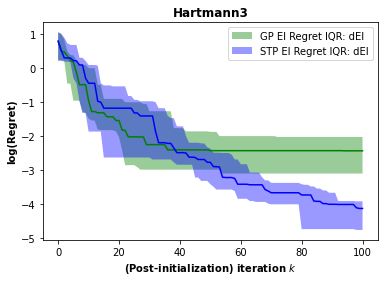

In [ ]:
### Visualize!

title = obj_func

plt.figure()

plt.plot(median_loser, color = 'Green')
plt.plot(median_winner, color = 'Blue')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_loser, upper_loser, facecolor = 'Green', alpha=0.4, label='GP EI Regret IQR: dEI')
plt.fill_between(xstar, lower_winner, upper_winner, facecolor = 'Blue', alpha=0.4, label='STP EI Regret IQR: dEI')

plt.title(title, weight = 'bold', family = 'Arial')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold', family = 'Arial') 
plt.ylabel('log(Regret)', weight = 'bold', family = 'Arial') 
plt.legend(loc=1) # add plot legend

plt.show() 

In [ ]:
time_lose, time_win

(3642.8169293403625, 26974.72700047493)